# Install Libraries


In [1]:
%pip install torch torchvision torchaudio --quiet
%pip install tensorflow --quiet
%pip install plotly --quiet
%pip install --upgrade nbformat --quiet
%pip install --upgrade nbformat --user --quiet
%pip install ipykernel jupyter --quiet
%pip install tensorflow-addons --quiet

ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/opt/conda/lib/python3.8/site-packages/nvidia/nvjitlink'

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '__init__.py'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/opt/conda/lib/python3.8/site-packages/platformdirs'

Note: you may need to restart the kernel to use updated packages.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

# Classifer (Simple CNN)

In [2]:
import torch.nn as nn

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):  # 10 classes for MNIST digits (0-9)
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels = 1 for grayscale
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size for fc1 (7x7 after pooling)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocess 5 Train - test dataset

In [3]:
import torch
from torchvision import datasets, transforms
from collections import Counter
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import random

# get imbalanced
def get_class_imabalnced(dataset, ratio):
  imbalanced_dataset = []
  for label in range(10):
    count = ratio[label]
    current_count = 0
    for data, target in dataset:
      if target == label and current_count < count:
        imbalanced_dataset.append((data, target))
        current_count += 1
  return imbalanced_dataset

def get_class_imabalnced2(dataset, ratio):
    imbalanced_dataset = []
    for label in range(10):
        count = ratio[label]
        current_count = 0

        # Shuffle data within the class:
        class_data = [(data, target) for data, target in dataset if target == label]
        random.shuffle(class_data)

        selected_indices = set()  # Keep track of selected indices

        for i, (data, target) in enumerate(class_data):  # Use enumerate
            if target == label and current_count < count and i not in selected_indices:
                imbalanced_dataset.append((data, target))
                current_count += 1
                selected_indices.add(i)
    return imbalanced_dataset

# Load dataset
mnist_dataset = datasets.MNIST(
  root="./data", 
  train=True, 
  download=True, 
  transform=transforms.ToTensor()
)

# Prepare data for k-fold cross-validation
X = [data for data, _ in mnist_dataset]
y = [target for _, target in mnist_dataset]

# Initialize k-fold cross-validation
num_folds = 3
batch_size = 256

# Assuming 'y' is your target variable containing class labels
min_samples_per_class = min(Counter(y).values())
max_desired_count = min_samples_per_class // num_folds  # Dividing by 3 for 3-fold cross-validation

print(f"Minimum samples per class: {min_samples_per_class}")
print(f"Maximum allowed desired_count: {max_desired_count}")

# Create an imbalanced dataset
train_counts = {
  0: 3000,
  1: 2000,
  2: 1000,
  3: 750,
  4: 500,
  5: 12,
  6: 10,
  7: 8,
  8: 6,
  9: 4,
}

test_counts = {
    0: max_desired_count,
    1: max_desired_count,
    2: max_desired_count,
    3: max_desired_count,
    4: max_desired_count,
    5: max_desired_count,
    6: max_desired_count,
    7: max_desired_count,
    8: max_desired_count,
    9: max_desired_count,
}

imbalanced_train_dataset_list = []

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
# Iterate over folds
folds_data = []
for fold, (train_index, test_index) in enumerate(kf.split(X,y)):
    print(f"Fold {fold + 1}")

    # Get the training data for this fold
    train_dataset_fold = [(X[i], y[i]) for i in train_index]

    # Apply the get_class_imabalnced function to enforce the desired distribution
    train_dataset = get_class_imabalnced2(train_dataset_fold, train_counts)

    imbalanced_train_dataset_list.append(train_dataset)

    # Create test dataset for this fold
    test_dataset_fold = [(X[i], y[i]) for i in test_index]
    test_dataset = get_class_imabalnced2(test_dataset_fold, test_counts)

    # Create datasets and dataloaders for this fold
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size , shuffle=True)

    folds_data.append([train_loader, test_loader])

    # Print class distribution for this fold
    class_counts_train = Counter([label for _, label in train_dataset])
    class_counts_test = Counter([label for _, label in test_dataset])
    print("Class distribution in Train dataset:", class_counts_train)
    print("Class distribution in Test dataset:", class_counts_test)

Minimum samples per class: 5421
Maximum allowed desired_count: 1807
Fold 1
Class distribution in Train dataset: Counter({0: 3000, 1: 2000, 2: 1000, 3: 750, 4: 500, 5: 12, 6: 10, 7: 8, 8: 6, 9: 4})
Class distribution in Test dataset: Counter({0: 1807, 1: 1807, 2: 1807, 3: 1807, 4: 1807, 5: 1807, 6: 1807, 7: 1807, 8: 1807, 9: 1807})
Fold 2
Class distribution in Train dataset: Counter({0: 3000, 1: 2000, 2: 1000, 3: 750, 4: 500, 5: 12, 6: 10, 7: 8, 8: 6, 9: 4})
Class distribution in Test dataset: Counter({0: 1807, 1: 1807, 2: 1807, 3: 1807, 4: 1807, 5: 1807, 6: 1807, 7: 1807, 8: 1807, 9: 1807})
Fold 3
Class distribution in Train dataset: Counter({0: 3000, 1: 2000, 2: 1000, 3: 750, 4: 500, 5: 12, 6: 10, 7: 8, 8: 6, 9: 4})
Class distribution in Test dataset: Counter({0: 1807, 1: 1807, 2: 1807, 3: 1807, 4: 1807, 5: 1807, 6: 1807, 7: 1807, 8: 1807, 9: 1807})


In [4]:
for w in folds_data[0][0]:
    print(w[0][0].shape)
    break

torch.Size([1, 28, 28])


In [5]:
# save rawdata
import numpy as np
pathsave = '/home/s2522002/source_code/rawdata/train_test_mnist.npy'
np.save(pathsave,folds_data)

In [6]:
rank_acc,rank_pre,rank_rec,rank_f1 = [],[],[],[]

# CNN Imb Train-Test

In [7]:
# Create model, optimizer, and loss function
#check gpu
import torch.optim as optim
import torch.nn as nn
import statistics

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set hyperparameter

num_epochs = 5
LR = 0.01
model = SimpleCNN().to(device)#ResNetMNIST().to(device)#SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.0, weight_decay=5e-4) #optim.Adam(model.parameters())

avg_accuracy_list = []
avg_sensitivity_list = []
avg_specificity_list = []
avg_precision_list = []

g_mean_list = []
f_measure_list = []
acsa_list = []
cm_list = []
acsa_list = []

# Training loop
for datatset in folds_data:
    imbalanced_train_loader = datatset[0]
    for epoch in tqdm(range(num_epochs),desc='Loading...'):
        for batch_idx, (data, target) in enumerate(imbalanced_train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    print("Training finished!")

    # measure ACSA, GM, and FM from imbalanced_test_loader
    import numpy as np
    from sklearn.metrics import confusion_matrix

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set the model to evaluation mode

    imbalanced_test_loader = datatset[1]
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in imbalanced_test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            _, predicted = torch.max(output.data, 1)

            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels)
    cm_list.append(cm)

    ########################## Test ############################################
    # Calculate class-wise accuracy, sensitivity, specificity, and precision
    class_accuracies = []
    class_sensitivities = []
    class_specificities = []
    class_precisions = []

    for i in range(cm.shape[0]):
      tp = cm[i, i]
      fp = np.sum(cm[:, i]) - tp
      fn = np.sum(cm[i, :]) - tp
      tn = np.sum(cm) - tp - fp - fn

      class_accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
      class_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
      class_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
      class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0

      class_accuracies.append(class_accuracy)
      class_sensitivities.append(class_sensitivity)
      class_specificities.append(class_specificity)
      class_precisions.append(class_precision)

    # Calculate the average accuracy, sensitivity, specificity, and precision
    avg_accuracy = np.mean(class_accuracies)
    avg_sensitivity = np.mean(class_sensitivities)
    avg_specificity = np.mean(class_specificities)
    avg_precision = np.mean(class_precisions)

    # Calculate G-mean and F-measure
    g_mean = np.sqrt(avg_sensitivity * avg_specificity)
    f_measure = 2 * (avg_precision * avg_sensitivity) / (avg_precision + avg_sensitivity) if (avg_precision + avg_sensitivity) > 0 else 0

    # Calculate ACSA (Average Class-wise Sensitivity and Accuracy)
    acsa = (avg_sensitivity + avg_accuracy) / 2

    ## Keep ALL values to list
    avg_accuracy_list.append(avg_accuracy)
    print(avg_accuracy_list)
    avg_sensitivity_list.append(avg_sensitivity)
    avg_specificity_list.append(avg_specificity)
    avg_precision_list.append(avg_precision)
    g_mean_list.append(g_mean)
    f_measure_list.append(f_measure)
    acsa_list.append(acsa)

print("Average Accuracy:", statistics.mean(avg_accuracy_list))
print("Average Sensitivity:", statistics.mean(avg_sensitivity_list))
print("Average Specificity:", statistics.mean(avg_specificity_list))
print("Average Precision:", statistics.mean(avg_precision_list))

print("\nG-mean:", statistics.mean(g_mean_list))
print("F-measure:", statistics.mean(f_measure_list))
print("\nACSA:", statistics.mean(acsa_list))

print(cm_list)

Loading...: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Training finished!
[0.844382955174322]


Loading...: 100%|██████████| 5/5 [00:00<00:00, 17.22it/s]


Training finished!
[0.844382955174322, 0.8902158273381294]


Loading...: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Training finished!
[0.844382955174322, 0.8902158273381294, 0.893049252905368]
Average Accuracy: 0.8758826784726065
Average Sensitivity: 0.3794133923630327
Average Specificity: 0.9310459324847814
Average Precision: 0.21621144273197385

G-mean: 0.5875302337920941
F-measure: 0.2735555243809017

ACSA: 0.6276480354178195
[array([[1784,   23,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3, 1803,    1,    0,    0,    0,    0,    0,    0,    0],
       [ 886,  507,  414,    0,    0,    0,    0,    0,    0,    0],
       [1036,  746,   16,    9,    0,    0,    0,    0,    0,    0],
       [1205,  562,   40,    0,    0,    0,    0,    0,    0,    0],
       [1298,  508,    1,    0,    0,    0,    0,    0,    0,    0],
       [1189,  564,   54,    0,    0,    0,    0,    0,    0,    0],
       [ 844,  956,    2,    5,    0,    0,    0,    0,    0,    0],
       [ 733, 1066,    8,    0,    0,    0,    0,    0,    0,    0],
       [ 861,  928,   16,    2,    0,    0,    0,    0,    0

In [8]:
rank_acc.append(avg_accuracy_list)
rank_pre.append(avg_precision_list)
rank_rec.append(avg_sensitivity_list)
rank_f1.append(f_measure_list)

# DeepCLSMOTE 

## Architecture

In [9]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import torch.nn.functional as F


print(torch.version.cuda) #10.1
t3 = time.time()
##############################################################################
"""args for AE"""

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 1#3    # number of channels in the input data

args['n_z'] = 20 #300 #600     # number of dimensions in latent space.

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.001        # learning rate for Adam optimizer .000
#args['epochs'] = 10         # how many epochs to run for (original used 200)
args['batch_size'] = 100   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from

args['dataset'] = 'mnist'  #'fmnist' # specify which dataset to use
args['num_class'] = 10

##############################################################################



## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),

            #3d and 32 by 32
            #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),

            nn.BatchNorm2d(self.dim_h * 8), # 40 X 8 = 320

            nn.LeakyReLU(0.2, inplace=True) )#,

        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
    def forward(self, x, labsn):

        x = self.conv(x)

        # Class images Bagging
        train_list = [[] for _ in range(args['num_class'])]
        list_class_latent = [[] for _ in range(args['num_class'])]
        for i, label in enumerate(labsn):
          train_list[label].append(torch.tensor(x[i].cpu().detach().numpy()))

        # For each class, we will get the latent representation
        for i, label in enumerate(labsn):
          class_sample = torch.stack(train_list[label])
          class_sample =  class_sample.squeeze().to(device) # Move x0 to the same device as self.fc
          class_sample_linear = self.fc(class_sample)
          
          if len(class_sample_linear.shape) == 1:
              class_sample_linear = class_sample_linear.unsqueeze(0)
          list_class_latent[label] = class_sample_linear

        # Mixed Class (For main reconstruction loss)
        x = x.squeeze()
        x = self.fc(x)

        #sys.exit(1)
        return x, list_class_latent


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            #nn.Sigmoid())
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        #print('input ',x.size())
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False


##############################################################################
"""functions to create SMOTE images"""

def biased_get_class1(c,data,target):

    xbeg = data[target == c]  # Filter data based on target value
    ybeg = target[target == c]  # Filter target based on target value

    return xbeg ,ybeg

def Generate_SMOTE(X, y,n_to_sample,cl):


    # fitting the model
    n_neigh = min(5 + 1,len(X))
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]
    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)


    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#xsamp, ysamp = SM(xclass,yclass)
###############################################################################
def calculate_diffs(z):
    """
    Calculate the differences between elements in the input list 'z'
    and return the total sum of all differences for each original element.

    Args:
        z (list): A list of lists containing numerical values.

    Returns:
        list: A list containing the total sum of differences for each original element in 'z'.
    """
    all_diffs_list = []  # List to store lists of differences
    for i, arr1 in enumerate(z):
        diffs_for_arr1 = []  # Store differences for this arr1
        for j, arr2 in enumerate(z):
            if i != j:  # Skip comparing with itself
                diffs = []  # Store diffs for this pair of arr1, arr2
                for el1 in arr1:
                    # Calculate the sum of Euclidean distances between el1 and all elements in arr2
                    diff_for_el1 = sum(np.linalg.norm(np.array([el1.cpu().detach().numpy()]) - np.array([el2.cpu().detach().numpy()])) for el2 in arr2)
                    diffs.append(diff_for_el1)  # Append diff for el1 to diffs
                diffs_for_arr1.append(diffs)  # Append the diffs list for the current arr2
        all_diffs_list.append(diffs_for_arr1)  # Append the diffs_for_arr1

    # Sum all elements within each array to get a single total sum
    total_sums = [sum(sum(inner_list) for inner_list in outer_list) for outer_list in all_diffs_list]

    return total_sums

###############################################################################


11.8


## Contrastive Loss

In [10]:
def calculate_diffs(z):
    """
    Calculate the differences between elements in the input list 'z'
    and return the total sum of all differences for each original element.

    Args:
        z (list): A list of lists containing numerical values.

    Returns:
        list: A list containing the total sum of differences for each original element in 'z'.
    """
    all_diffs_list = []  # List to store lists of differences
    for i, arr1 in enumerate(z):
        diffs_for_arr1 = []  # Store differences for this arr1
        for j, arr2 in enumerate(z):
            if i != j:  # Skip comparing with itself
                diffs = []  # Store diffs for this pair of arr1, arr2
                for el1 in arr1:
                    # Calculate the sum of Euclidean distances between el1 and all elements in arr2
                    diff_for_el1 = sum(np.linalg.norm(np.array([el1.cpu().detach().numpy()]) - np.array([el2.cpu().detach().numpy()])) for el2 in arr2)
                    diffs.append(diff_for_el1)  # Append diff for el1 to diffs
                diffs_for_arr1.append(diffs)  # Append the diffs list for the current arr2
        all_diffs_list.append(diffs_for_arr1)  # Append the diffs_for_arr1

    # Sum all elements within each array to get a single total sum
    total_sums = [sum(sum(inner_list) for inner_list in outer_list) for outer_list in all_diffs_list]

    return total_sums


In [11]:
class NTXentLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, z_i, z_j, temperature):
        self.temperature = temperature
        
        z = torch.cat([z_i, z_j], dim=0)
        z = F.normalize(z, dim=1)

        similarity = torch.matmul(z, z.T)
        N = z_i.shape[0]

        mask = (~torch.eye(2*N, dtype=bool)).to(z.device)
        sim = similarity / self.temperature
        exp_sim = torch.exp(sim) * mask

        positive_sim = torch.exp(F.cosine_similarity(z_i, z_j) / self.temperature)
        positives = torch.cat([positive_sim, positive_sim], dim=0)

        denominator = exp_sim.sum(dim=1)
        loss = -torch.log(positives / denominator)
        return loss.mean()

In [12]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn

base_temperature = 0.07
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, contrast_mode='all',
                 base_temperature=base_temperature):
        super(SupConLoss, self).__init__()
        #self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, temperature, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        self.temperature = temperature
        
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point. 
        # Edge case e.g.:- 
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan] 
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

## Traning - Gen - Evalution (SubCon)


Start...
cuda


Loading...:   0%|          | 0/29 [00:00<?, ?it/s]/JOBs/tmpdir/pbs.13853184.spcc-adm1/ipykernel_3235530/3291537558.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
  z_hat_to_concat.append(torch.tensor(tensor).to(device))
Loading...: 100%|██████████| 29/29 [00:02<00:00, 11.35it/s]


Epoch 0: MSE: 0.3398, Contrastive: 9.5991, Combined: 4.9694


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 1: MSE: 0.1010, Contrastive: 8.6593, Combined: 4.3802


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.34it/s]


Epoch 2: MSE: 0.0690, Contrastive: 8.1536, Combined: 4.1113


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.28it/s]


Epoch 3: MSE: 0.0564, Contrastive: 8.0683, Combined: 4.0624


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 4: MSE: 0.0429, Contrastive: 7.9304, Combined: 3.9866


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.36it/s]


Epoch 5: MSE: 0.0326, Contrastive: 7.8261, Combined: 3.9293


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.13it/s]


Epoch 6: MSE: 0.0262, Contrastive: 7.7907, Combined: 3.9085


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.35it/s]


Epoch 7: MSE: 0.0219, Contrastive: 7.7723, Combined: 3.8971


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.24it/s]


Epoch 8: MSE: 0.0201, Contrastive: 7.7647, Combined: 3.8924


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.23it/s]


Epoch 9: MSE: 0.0180, Contrastive: 7.7330, Combined: 3.8755


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.16it/s]


Epoch 10: MSE: 0.0166, Contrastive: 7.7199, Combined: 3.8682


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.03it/s]


Epoch 11: MSE: 0.0163, Contrastive: 7.7212, Combined: 3.8688


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.07it/s]


Epoch 12: MSE: 0.0155, Contrastive: 7.6964, Combined: 3.8560


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.33it/s]


Epoch 13: MSE: 0.0152, Contrastive: 7.6846, Combined: 3.8499


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.27it/s]


Epoch 14: MSE: 0.0145, Contrastive: 7.6820, Combined: 3.8483


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.16it/s]


Epoch 15: MSE: 0.0138, Contrastive: 7.6686, Combined: 3.8412


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.09it/s]


Epoch 16: MSE: 0.0144, Contrastive: 7.6846, Combined: 3.8495


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.94it/s]


Epoch 17: MSE: 0.0132, Contrastive: 7.6625, Combined: 3.8378


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.08it/s]


Epoch 18: MSE: 0.0132, Contrastive: 7.6580, Combined: 3.8356


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.14it/s]


Epoch 19: MSE: 0.0130, Contrastive: 7.6689, Combined: 3.8410


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.28it/s]


Epoch 20: MSE: 0.0125, Contrastive: 7.6765, Combined: 3.8445


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.12it/s]


Epoch 21: MSE: 0.0124, Contrastive: 7.6887, Combined: 3.8506


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.10it/s]


Epoch 22: MSE: 0.0124, Contrastive: 7.6786, Combined: 3.8455


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.97it/s]


Epoch 23: MSE: 0.0128, Contrastive: 7.6961, Combined: 3.8544


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.14it/s]


Epoch 24: MSE: 0.0123, Contrastive: 7.7159, Combined: 3.8641


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.17it/s]


Epoch 25: MSE: 0.0121, Contrastive: 7.7020, Combined: 3.8570


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.29it/s]


Epoch 26: MSE: 0.0123, Contrastive: 7.7096, Combined: 3.8609


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.23it/s]


Epoch 27: MSE: 0.0120, Contrastive: 7.6923, Combined: 3.8522


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.29it/s]


Epoch 28: MSE: 0.0120, Contrastive: 7.7044, Combined: 3.8582


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.16it/s]


Epoch 29: MSE: 0.0119, Contrastive: 7.7016, Combined: 3.8567


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.02it/s]


Epoch 30: MSE: 0.0118, Contrastive: 7.6939, Combined: 3.8529


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.98it/s]


Epoch 31: MSE: 0.0113, Contrastive: 7.6882, Combined: 3.8497


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.94it/s]


Epoch 32: MSE: 0.0113, Contrastive: 7.6822, Combined: 3.8467


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.07it/s]


Epoch 33: MSE: 0.0113, Contrastive: 7.6825, Combined: 3.8469


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.19it/s]


Epoch 34: MSE: 0.0109, Contrastive: 7.6863, Combined: 3.8486


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.14it/s]


Epoch 35: MSE: 0.0110, Contrastive: 7.6922, Combined: 3.8516


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.13it/s]


Epoch 36: MSE: 0.0111, Contrastive: 7.7023, Combined: 3.8567


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.15it/s]


Epoch 37: MSE: 0.0109, Contrastive: 7.6811, Combined: 3.8460


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.20it/s]


Epoch 38: MSE: 0.0108, Contrastive: 7.6880, Combined: 3.8494


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.21it/s]


Epoch 39: MSE: 0.0109, Contrastive: 7.6840, Combined: 3.8475


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.95it/s]


Epoch 40: MSE: 0.0108, Contrastive: 7.6790, Combined: 3.8449


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.95it/s]


Epoch 41: MSE: 0.0111, Contrastive: 7.7021, Combined: 3.8566


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.00it/s]


Epoch 42: MSE: 0.0107, Contrastive: 7.6948, Combined: 3.8528


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]


Epoch 43: MSE: 0.0105, Contrastive: 7.7022, Combined: 3.8564


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.34it/s]


Epoch 44: MSE: 0.0105, Contrastive: 7.6946, Combined: 3.8525


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.39it/s]


Epoch 45: MSE: 0.0103, Contrastive: 7.6883, Combined: 3.8493


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.43it/s]


Epoch 46: MSE: 0.0104, Contrastive: 7.6948, Combined: 3.8526


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.52it/s]


Epoch 47: MSE: 0.0103, Contrastive: 7.6749, Combined: 3.8426


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.36it/s]


Epoch 48: MSE: 0.0105, Contrastive: 7.6906, Combined: 3.8505


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.37it/s]


Epoch 49: MSE: 0.0102, Contrastive: 7.6775, Combined: 3.8439


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.29it/s]


Epoch 50: MSE: 0.0103, Contrastive: 7.6981, Combined: 3.8542


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.19it/s]


Epoch 51: MSE: 0.0105, Contrastive: 7.6945, Combined: 3.8525


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.04it/s]


Epoch 52: MSE: 0.0103, Contrastive: 7.7087, Combined: 3.8595


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.18it/s]


Epoch 53: MSE: 0.0103, Contrastive: 7.6803, Combined: 3.8453


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.15it/s]


Epoch 54: MSE: 0.0101, Contrastive: 7.6876, Combined: 3.8488


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.28it/s]


Epoch 55: MSE: 0.0097, Contrastive: 7.6924, Combined: 3.8510


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.15it/s]


Epoch 56: MSE: 0.0099, Contrastive: 7.6790, Combined: 3.8444


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.50it/s]


Epoch 57: MSE: 0.0101, Contrastive: 7.6873, Combined: 3.8487


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 58: MSE: 0.0100, Contrastive: 7.6949, Combined: 3.8524


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.47it/s]


Epoch 59: MSE: 0.0098, Contrastive: 7.6836, Combined: 3.8467


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.40it/s]


Epoch 60: MSE: 0.0098, Contrastive: 7.6741, Combined: 3.8419


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.33it/s]


Epoch 61: MSE: 0.0100, Contrastive: 7.6904, Combined: 3.8502


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.32it/s]


Epoch 62: MSE: 0.0097, Contrastive: 7.6877, Combined: 3.8487


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.41it/s]


Epoch 63: MSE: 0.0097, Contrastive: 7.6890, Combined: 3.8494


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.41it/s]


Epoch 64: MSE: 0.0095, Contrastive: 7.6892, Combined: 3.8494


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.21it/s]


Epoch 65: MSE: 0.0097, Contrastive: 7.6923, Combined: 3.8510


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.07it/s]


Epoch 66: MSE: 0.0096, Contrastive: 7.6804, Combined: 3.8450


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 67: MSE: 0.0098, Contrastive: 7.6847, Combined: 3.8473


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.42it/s]


Epoch 68: MSE: 0.0096, Contrastive: 7.6624, Combined: 3.8360


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.41it/s]


Epoch 69: MSE: 0.0098, Contrastive: 7.6642, Combined: 3.8370


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 70: MSE: 0.0098, Contrastive: 7.6849, Combined: 3.8474


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.39it/s]


Epoch 71: MSE: 0.0096, Contrastive: 7.6771, Combined: 3.8433


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 72: MSE: 0.0095, Contrastive: 7.6658, Combined: 3.8376


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.22it/s]


Epoch 73: MSE: 0.0096, Contrastive: 7.6705, Combined: 3.8400


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.37it/s]


Epoch 74: MSE: 0.0093, Contrastive: 7.6617, Combined: 3.8355


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.41it/s]


Epoch 75: MSE: 0.0098, Contrastive: 7.6545, Combined: 3.8322


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.32it/s]


Epoch 76: MSE: 0.0094, Contrastive: 7.6718, Combined: 3.8406


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.29it/s]


Epoch 77: MSE: 0.0092, Contrastive: 7.6858, Combined: 3.8475


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.40it/s]


Epoch 78: MSE: 0.0094, Contrastive: 7.6790, Combined: 3.8442


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 79: MSE: 0.0097, Contrastive: 7.6811, Combined: 3.8454


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 80: MSE: 0.0094, Contrastive: 7.6716, Combined: 3.8405


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.25it/s]


Epoch 81: MSE: 0.0089, Contrastive: 7.6617, Combined: 3.8353


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.05it/s]


Epoch 82: MSE: 0.0093, Contrastive: 7.6471, Combined: 3.8282


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.27it/s]


Epoch 83: MSE: 0.0092, Contrastive: 7.6592, Combined: 3.8342


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.29it/s]


Epoch 84: MSE: 0.0092, Contrastive: 7.6655, Combined: 3.8374


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.33it/s]


Epoch 85: MSE: 0.0091, Contrastive: 7.6631, Combined: 3.8361


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.41it/s]


Epoch 86: MSE: 0.0092, Contrastive: 7.6615, Combined: 3.8353


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 87: MSE: 0.0091, Contrastive: 7.6534, Combined: 3.8312


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.47it/s]


Epoch 88: MSE: 0.0088, Contrastive: 7.6494, Combined: 3.8291


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.31it/s]


Epoch 89: MSE: 0.0095, Contrastive: 7.6583, Combined: 3.8339


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.41it/s]


Epoch 90: MSE: 0.0089, Contrastive: 7.6792, Combined: 3.8441


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.39it/s]


Epoch 91: MSE: 0.0092, Contrastive: 7.6616, Combined: 3.8354


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.42it/s]


Epoch 92: MSE: 0.0090, Contrastive: 7.6746, Combined: 3.8418


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.31it/s]


Epoch 93: MSE: 0.0091, Contrastive: 7.6766, Combined: 3.8428


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]


Epoch 94: MSE: 0.0090, Contrastive: 7.6838, Combined: 3.8464


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.42it/s]


Epoch 95: MSE: 0.0091, Contrastive: 7.6716, Combined: 3.8404


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.27it/s]


Epoch 96: MSE: 0.0089, Contrastive: 7.6728, Combined: 3.8409


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.21it/s]


Epoch 97: MSE: 0.0089, Contrastive: 7.6784, Combined: 3.8437


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.05it/s]


Epoch 98: MSE: 0.0095, Contrastive: 7.6766, Combined: 3.8431


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 99: MSE: 0.0087, Contrastive: 7.6724, Combined: 3.8406


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.13it/s]


Epoch 100: MSE: 0.0086, Contrastive: 7.6706, Combined: 3.8396


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.97it/s]


Epoch 101: MSE: 0.0089, Contrastive: 7.6844, Combined: 3.8466


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.15it/s]


Epoch 102: MSE: 0.0083, Contrastive: 7.6646, Combined: 3.8364


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]


Epoch 103: MSE: 0.0083, Contrastive: 7.6691, Combined: 3.8387


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.19it/s]


Epoch 104: MSE: 0.0087, Contrastive: 7.6717, Combined: 3.8402


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 105: MSE: 0.0085, Contrastive: 7.6597, Combined: 3.8341


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.25it/s]


Epoch 106: MSE: 0.0089, Contrastive: 7.6715, Combined: 3.8402


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]


Epoch 107: MSE: 0.0085, Contrastive: 7.6845, Combined: 3.8465


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.14it/s]


Epoch 108: MSE: 0.0081, Contrastive: 7.6725, Combined: 3.8403


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.25it/s]


Epoch 109: MSE: 0.0084, Contrastive: 7.6720, Combined: 3.8402


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.22it/s]


Epoch 110: MSE: 0.0086, Contrastive: 7.6702, Combined: 3.8394


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.48it/s]


Epoch 111: MSE: 0.0084, Contrastive: 7.6815, Combined: 3.8450


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.40it/s]


Epoch 112: MSE: 0.0084, Contrastive: 7.6663, Combined: 3.8373


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.23it/s]


Epoch 113: MSE: 0.0085, Contrastive: 7.6761, Combined: 3.8423


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.16it/s]


Epoch 114: MSE: 0.0084, Contrastive: 7.6783, Combined: 3.8434


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.34it/s]


Epoch 115: MSE: 0.0084, Contrastive: 7.6726, Combined: 3.8405


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.41it/s]


Epoch 116: MSE: 0.0082, Contrastive: 7.6726, Combined: 3.8404


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.29it/s]


Epoch 117: MSE: 0.0083, Contrastive: 7.6755, Combined: 3.8419


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.23it/s]


Epoch 118: MSE: 0.0083, Contrastive: 7.6761, Combined: 3.8422


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.40it/s]


Epoch 119: MSE: 0.0082, Contrastive: 7.6675, Combined: 3.8379


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 120: MSE: 0.0081, Contrastive: 7.6755, Combined: 3.8418


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.32it/s]


Epoch 121: MSE: 0.0083, Contrastive: 7.6675, Combined: 3.8379


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.35it/s]


Epoch 122: MSE: 0.0082, Contrastive: 7.6608, Combined: 3.8345


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.28it/s]


Epoch 123: MSE: 0.0080, Contrastive: 7.6722, Combined: 3.8401


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.99it/s]


Epoch 124: MSE: 0.0084, Contrastive: 7.6841, Combined: 3.8462


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.08it/s]


Epoch 125: MSE: 0.0082, Contrastive: 7.6714, Combined: 3.8398


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.39it/s]


Epoch 126: MSE: 0.0085, Contrastive: 7.6783, Combined: 3.8434


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.13it/s]


Epoch 127: MSE: 0.0080, Contrastive: 7.6638, Combined: 3.8359


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.25it/s]


Epoch 128: MSE: 0.0081, Contrastive: 7.6742, Combined: 3.8411


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.08it/s]


Epoch 129: MSE: 0.0080, Contrastive: 7.6665, Combined: 3.8373


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.09it/s]


Epoch 130: MSE: 0.0081, Contrastive: 7.6657, Combined: 3.8369


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.12it/s]


Epoch 131: MSE: 0.0080, Contrastive: 7.6484, Combined: 3.8282


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.25it/s]


Epoch 132: MSE: 0.0080, Contrastive: 7.6615, Combined: 3.8347


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 133: MSE: 0.0079, Contrastive: 7.6495, Combined: 3.8287


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.35it/s]


Epoch 134: MSE: 0.0081, Contrastive: 7.6588, Combined: 3.8334


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.36it/s]


Epoch 135: MSE: 0.0079, Contrastive: 7.6454, Combined: 3.8267


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 136: MSE: 0.0079, Contrastive: 7.6519, Combined: 3.8299


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.32it/s]


Epoch 137: MSE: 0.0080, Contrastive: 7.6700, Combined: 3.8390


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.35it/s]


Epoch 138: MSE: 0.0080, Contrastive: 7.6541, Combined: 3.8310


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.37it/s]


Epoch 139: MSE: 0.0079, Contrastive: 7.6536, Combined: 3.8308


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.36it/s]


Epoch 140: MSE: 0.0078, Contrastive: 7.6440, Combined: 3.8259


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.47it/s]


Epoch 141: MSE: 0.0077, Contrastive: 7.6448, Combined: 3.8263


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 142: MSE: 0.0077, Contrastive: 7.6376, Combined: 3.8227


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.42it/s]


Epoch 143: MSE: 0.0077, Contrastive: 7.6434, Combined: 3.8255


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.53it/s]


Epoch 144: MSE: 0.0079, Contrastive: 7.6439, Combined: 3.8259


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 145: MSE: 0.0080, Contrastive: 7.6528, Combined: 3.8304


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.38it/s]


Epoch 146: MSE: 0.0079, Contrastive: 7.6295, Combined: 3.8187


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.27it/s]


Epoch 147: MSE: 0.0081, Contrastive: 7.6601, Combined: 3.8341


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.43it/s]


Epoch 148: MSE: 0.0083, Contrastive: 7.6463, Combined: 3.8273


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.48it/s]


Epoch 149: MSE: 0.0079, Contrastive: 7.6501, Combined: 3.8290


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.43it/s]


Epoch 150: MSE: 0.0079, Contrastive: 7.6508, Combined: 3.8294


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.34it/s]


Epoch 151: MSE: 0.0082, Contrastive: 7.6577, Combined: 3.8329


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.90it/s]


Epoch 152: MSE: 0.0080, Contrastive: 7.6514, Combined: 3.8297


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.04it/s]


Epoch 153: MSE: 0.0080, Contrastive: 7.6475, Combined: 3.8278


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.18it/s]


Epoch 154: MSE: 0.0075, Contrastive: 7.6588, Combined: 3.8332


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.27it/s]


Epoch 155: MSE: 0.0078, Contrastive: 7.6408, Combined: 3.8243


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.31it/s]


Epoch 156: MSE: 0.0079, Contrastive: 7.6394, Combined: 3.8237


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.36it/s]


Epoch 157: MSE: 0.0077, Contrastive: 7.6433, Combined: 3.8255


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.28it/s]


Epoch 158: MSE: 0.0075, Contrastive: 7.6337, Combined: 3.8206


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.28it/s]


Epoch 159: MSE: 0.0075, Contrastive: 7.6397, Combined: 3.8236


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.24it/s]


Epoch 160: MSE: 0.0077, Contrastive: 7.6458, Combined: 3.8268


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]


Epoch 161: MSE: 0.0077, Contrastive: 7.6475, Combined: 3.8276


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.31it/s]


Epoch 162: MSE: 0.0076, Contrastive: 7.6397, Combined: 3.8236


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.33it/s]


Epoch 163: MSE: 0.0076, Contrastive: 7.6430, Combined: 3.8253


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.17it/s]


Epoch 164: MSE: 0.0076, Contrastive: 7.6384, Combined: 3.8230


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.25it/s]


Epoch 165: MSE: 0.0075, Contrastive: 7.6608, Combined: 3.8342


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.12it/s]


Epoch 166: MSE: 0.0078, Contrastive: 7.6535, Combined: 3.8307


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.09it/s]


Epoch 167: MSE: 0.0076, Contrastive: 7.6482, Combined: 3.8279


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 168: MSE: 0.0074, Contrastive: 7.6470, Combined: 3.8272


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]


Epoch 169: MSE: 0.0076, Contrastive: 7.6350, Combined: 3.8213


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.17it/s]


Epoch 170: MSE: 0.0076, Contrastive: 7.6460, Combined: 3.8268


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.21it/s]


Epoch 171: MSE: 0.0073, Contrastive: 7.6530, Combined: 3.8301


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.17it/s]


Epoch 172: MSE: 0.0075, Contrastive: 7.6424, Combined: 3.8250


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.07it/s]


Epoch 173: MSE: 0.0072, Contrastive: 7.6353, Combined: 3.8213


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.04it/s]


Epoch 174: MSE: 0.0074, Contrastive: 7.6451, Combined: 3.8262


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.11it/s]


Epoch 175: MSE: 0.0077, Contrastive: 7.6483, Combined: 3.8280


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.25it/s]


Epoch 176: MSE: 0.0075, Contrastive: 7.6451, Combined: 3.8263


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.16it/s]


Epoch 177: MSE: 0.0076, Contrastive: 7.6428, Combined: 3.8252


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.15it/s]


Epoch 178: MSE: 0.0074, Contrastive: 7.6410, Combined: 3.8242


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.14it/s]


Epoch 179: MSE: 0.0075, Contrastive: 7.6496, Combined: 3.8285


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.02it/s]


Epoch 180: MSE: 0.0074, Contrastive: 7.6340, Combined: 3.8207


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.96it/s]


Epoch 181: MSE: 0.0072, Contrastive: 7.6267, Combined: 3.8169


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.02it/s]


Epoch 182: MSE: 0.0079, Contrastive: 7.6417, Combined: 3.8248


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.14it/s]


Epoch 183: MSE: 0.0075, Contrastive: 7.6376, Combined: 3.8225


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.10it/s]


Epoch 184: MSE: 0.0073, Contrastive: 7.6356, Combined: 3.8215


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.22it/s]


Epoch 185: MSE: 0.0073, Contrastive: 7.6329, Combined: 3.8201


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.12it/s]


Epoch 186: MSE: 0.0074, Contrastive: 7.6339, Combined: 3.8206


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.19it/s]


Epoch 187: MSE: 0.0075, Contrastive: 7.6369, Combined: 3.8222


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.14it/s]


Epoch 188: MSE: 0.0075, Contrastive: 7.6576, Combined: 3.8326


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.31it/s]


Epoch 189: MSE: 0.0076, Contrastive: 7.6540, Combined: 3.8308


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.33it/s]


Epoch 190: MSE: 0.0072, Contrastive: 7.6426, Combined: 3.8249


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]


Epoch 191: MSE: 0.0071, Contrastive: 7.6489, Combined: 3.8280


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.25it/s]


Epoch 192: MSE: 0.0071, Contrastive: 7.6482, Combined: 3.8276


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.08it/s]


Epoch 193: MSE: 0.0075, Contrastive: 7.6506, Combined: 3.8291


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.13it/s]


Epoch 194: MSE: 0.0076, Contrastive: 7.6543, Combined: 3.8309


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.21it/s]


Epoch 195: MSE: 0.0071, Contrastive: 7.6551, Combined: 3.8311


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 196: MSE: 0.0072, Contrastive: 7.6551, Combined: 3.8312


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.26it/s]


Epoch 197: MSE: 0.0071, Contrastive: 7.6579, Combined: 3.8325


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.17it/s]


Epoch 198: MSE: 0.0073, Contrastive: 7.6609, Combined: 3.8341


Loading...: 100%|██████████| 29/29 [00:01<00:00, 19.09it/s]


Epoch 199: MSE: 0.0074, Contrastive: 7.6554, Combined: 3.8314
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.05
------ Plot Latent Space ------


------------------------------
0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


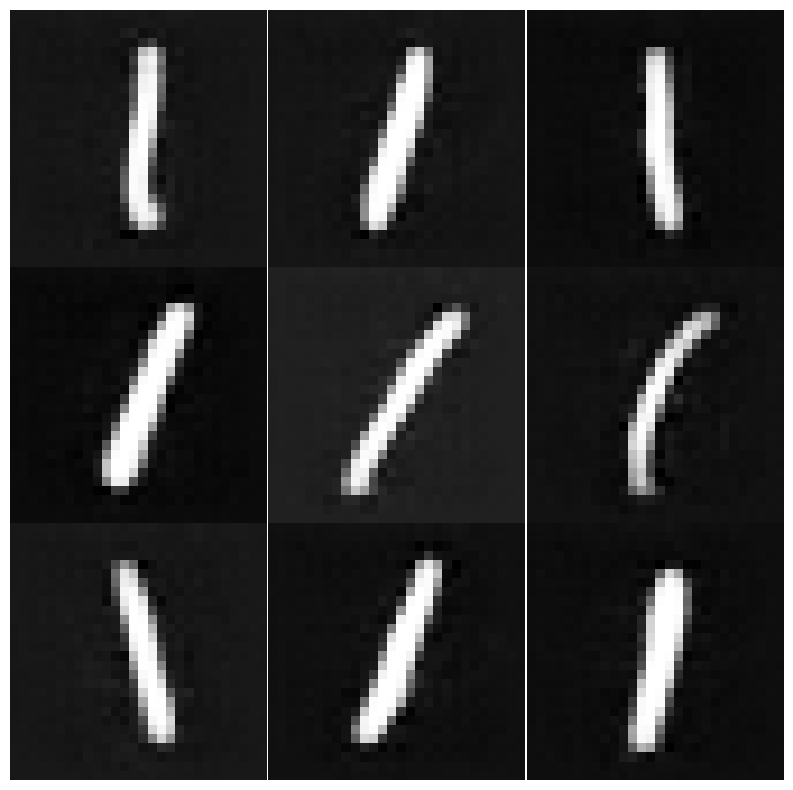

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


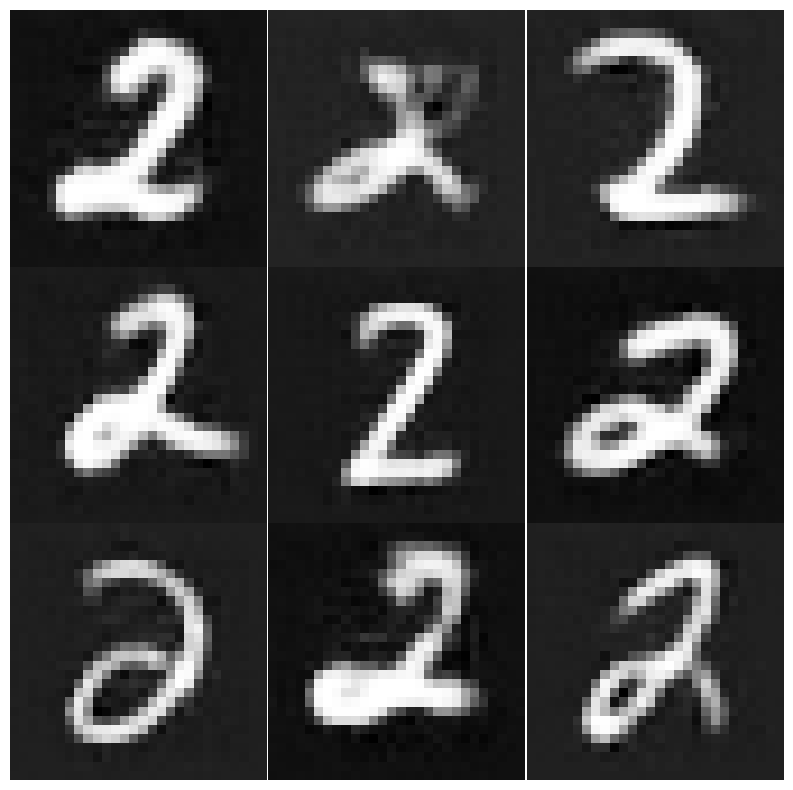

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


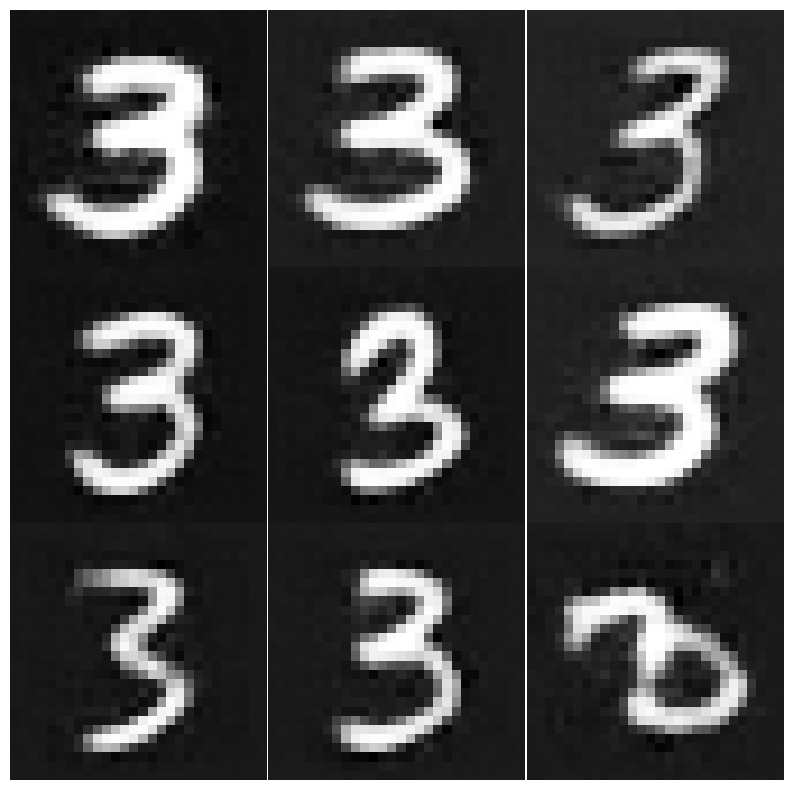

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


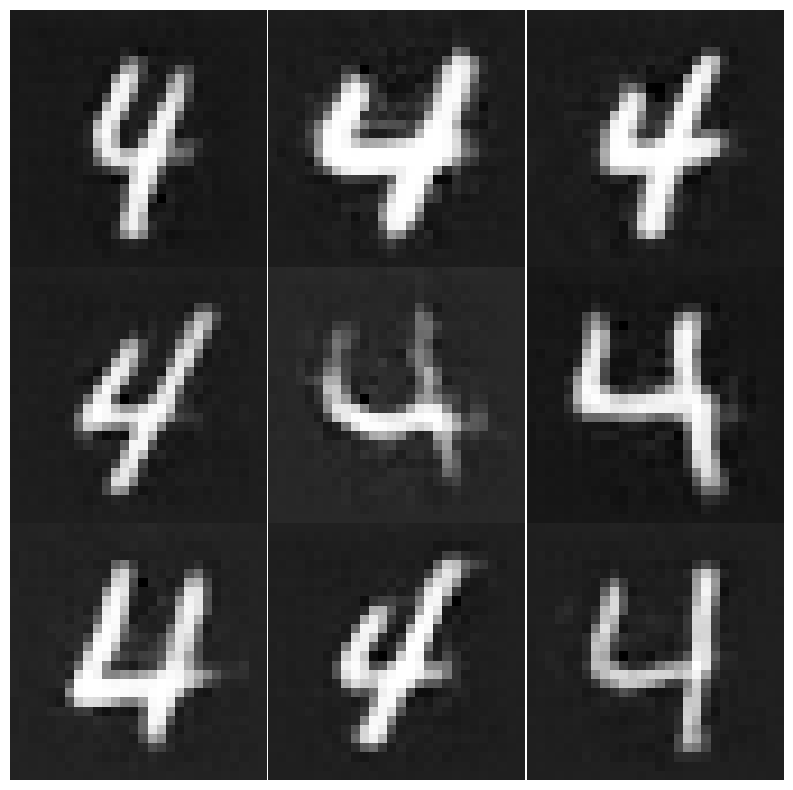

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


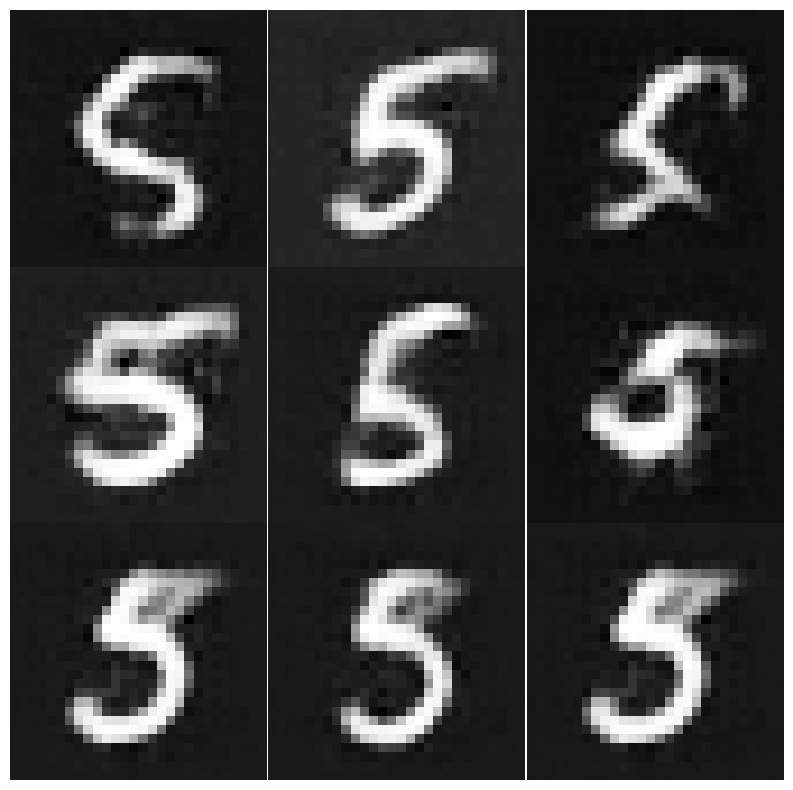

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


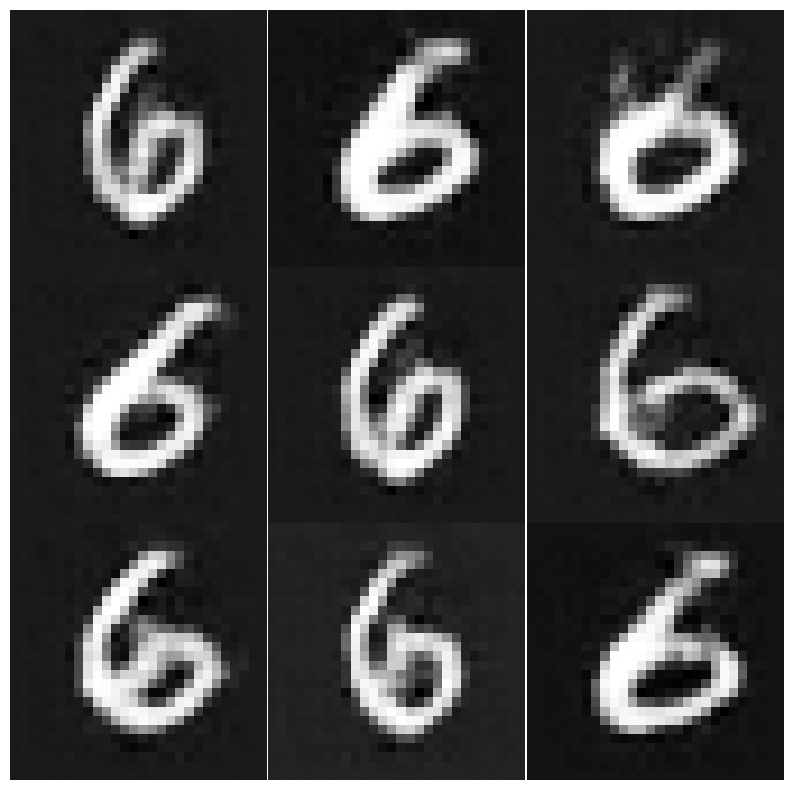

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


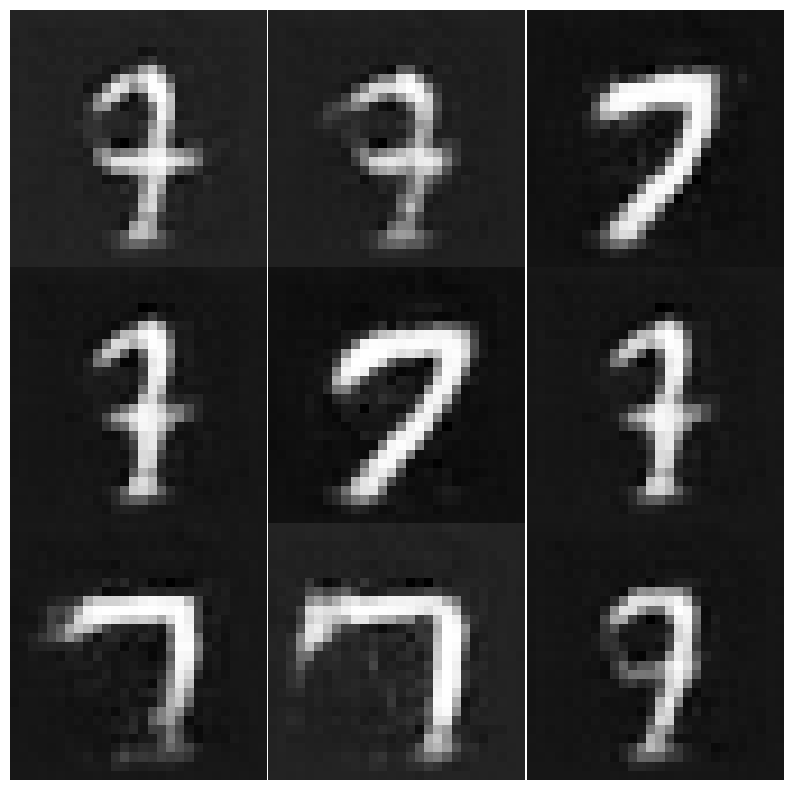

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


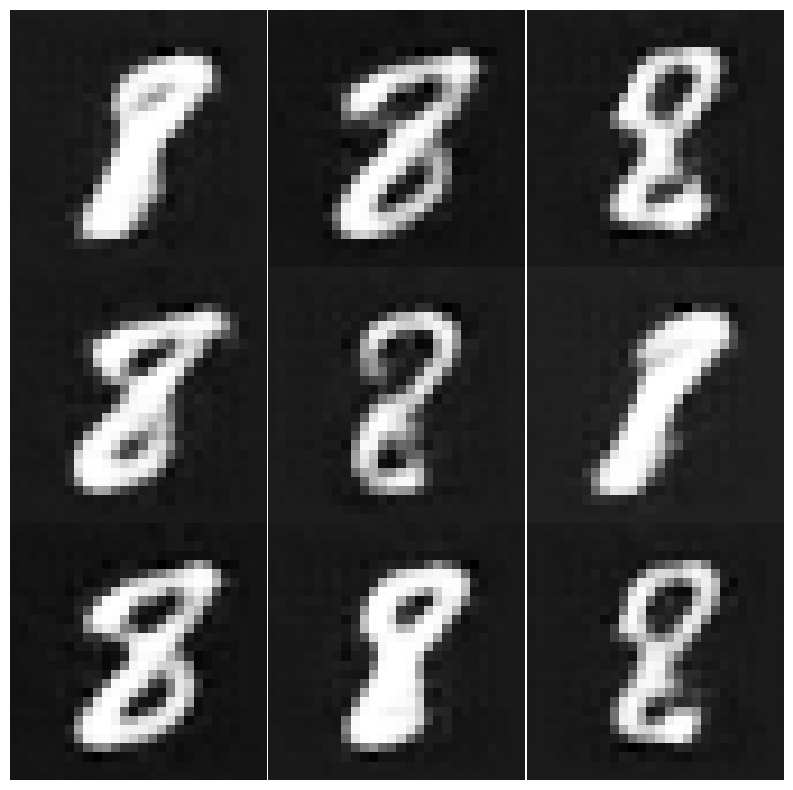

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


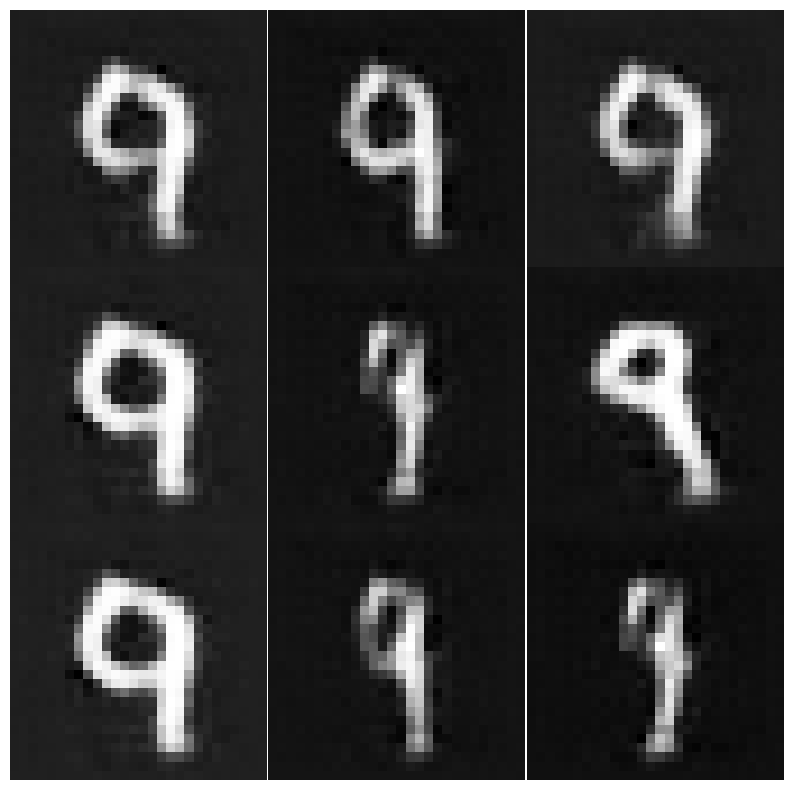

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.11
#Dataset = 1
------ Plot Balanced Imgs ------


------------------------------
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.280902
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.253453
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.201182
Train Epoch: 1 [4000/30000 (13%)]	Loss: 1.975468
Train Epoch: 1 [5000/30000 (17%)]	Loss: 1.326284
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.644602
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.406986
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.330196
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.101848
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.222332
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.318733
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.229660
Train Epoch: 1 [13000/30000 (43%)]	Loss: 0.192730
Train Epoch: 1 [14000/30000 (47%)]	Loss: 0.121599
Train Epoch: 1 [15000/30000 (50%)]	Loss: 0.067161
Train Epoch: 1 [16000/30

Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 0: MSE: 0.2158, Contrastive: 9.9492, Combined: 5.0825


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 1: MSE: 0.0827, Contrastive: 8.5904, Combined: 4.3366


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


Epoch 2: MSE: 0.0640, Contrastive: 8.2232, Combined: 4.1436


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 3: MSE: 0.0484, Contrastive: 8.1575, Combined: 4.1030


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]


Epoch 4: MSE: 0.0388, Contrastive: 7.8306, Combined: 3.9347


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 5: MSE: 0.0302, Contrastive: 7.7982, Combined: 3.9142


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 6: MSE: 0.0257, Contrastive: 7.7779, Combined: 3.9018


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 7: MSE: 0.0220, Contrastive: 7.7758, Combined: 3.8989


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]


Epoch 8: MSE: 0.0190, Contrastive: 7.7446, Combined: 3.8818


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 9: MSE: 0.0172, Contrastive: 7.7082, Combined: 3.8627


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 10: MSE: 0.0170, Contrastive: 7.7038, Combined: 3.8604


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 11: MSE: 0.0155, Contrastive: 7.6826, Combined: 3.8490


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 12: MSE: 0.0154, Contrastive: 7.6851, Combined: 3.8503


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.62it/s]


Epoch 13: MSE: 0.0151, Contrastive: 7.6535, Combined: 3.8343


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 14: MSE: 0.0147, Contrastive: 7.6749, Combined: 3.8448


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 15: MSE: 0.0145, Contrastive: 7.6607, Combined: 3.8376


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 16: MSE: 0.0138, Contrastive: 7.6593, Combined: 3.8366


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 17: MSE: 0.0137, Contrastive: 7.6593, Combined: 3.8365


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]


Epoch 18: MSE: 0.0133, Contrastive: 7.6548, Combined: 3.8341


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 19: MSE: 0.0131, Contrastive: 7.6621, Combined: 3.8376


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 20: MSE: 0.0133, Contrastive: 7.6719, Combined: 3.8426


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 21: MSE: 0.0128, Contrastive: 7.6585, Combined: 3.8357


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


Epoch 22: MSE: 0.0125, Contrastive: 7.6536, Combined: 3.8330


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 23: MSE: 0.0122, Contrastive: 7.6445, Combined: 3.8283


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 24: MSE: 0.0122, Contrastive: 7.6434, Combined: 3.8278


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 25: MSE: 0.0121, Contrastive: 7.6526, Combined: 3.8323


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 26: MSE: 0.0122, Contrastive: 7.6522, Combined: 3.8322


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 27: MSE: 0.0124, Contrastive: 7.6662, Combined: 3.8393


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 28: MSE: 0.0123, Contrastive: 7.6629, Combined: 3.8376


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 29: MSE: 0.0118, Contrastive: 7.6559, Combined: 3.8338


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 30: MSE: 0.0114, Contrastive: 7.6464, Combined: 3.8289


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 31: MSE: 0.0114, Contrastive: 7.6622, Combined: 3.8368


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.73it/s]


Epoch 32: MSE: 0.0111, Contrastive: 7.6535, Combined: 3.8323


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 33: MSE: 0.0116, Contrastive: 7.6697, Combined: 3.8406


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 34: MSE: 0.0115, Contrastive: 7.6867, Combined: 3.8491


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 35: MSE: 0.0117, Contrastive: 7.6618, Combined: 3.8368


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 36: MSE: 0.0110, Contrastive: 7.6624, Combined: 3.8367


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 37: MSE: 0.0112, Contrastive: 7.6601, Combined: 3.8356


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 38: MSE: 0.0115, Contrastive: 7.6736, Combined: 3.8425


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.75it/s]


Epoch 39: MSE: 0.0112, Contrastive: 7.6600, Combined: 3.8356


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 40: MSE: 0.0111, Contrastive: 7.6662, Combined: 3.8386


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 41: MSE: 0.0112, Contrastive: 7.6802, Combined: 3.8457


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]


Epoch 42: MSE: 0.0109, Contrastive: 7.6591, Combined: 3.8350


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 43: MSE: 0.0113, Contrastive: 7.6638, Combined: 3.8375


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 44: MSE: 0.0110, Contrastive: 7.6685, Combined: 3.8397


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.75it/s]


Epoch 45: MSE: 0.0109, Contrastive: 7.6659, Combined: 3.8384


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.73it/s]


Epoch 46: MSE: 0.0106, Contrastive: 7.6652, Combined: 3.8379


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 47: MSE: 0.0103, Contrastive: 7.6444, Combined: 3.8274


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.82it/s]


Epoch 48: MSE: 0.0103, Contrastive: 7.6583, Combined: 3.8343


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.73it/s]


Epoch 49: MSE: 0.0103, Contrastive: 7.6704, Combined: 3.8403


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 50: MSE: 0.0103, Contrastive: 7.6698, Combined: 3.8401


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.62it/s]


Epoch 51: MSE: 0.0103, Contrastive: 7.6626, Combined: 3.8364


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 52: MSE: 0.0103, Contrastive: 7.6611, Combined: 3.8357


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 53: MSE: 0.0100, Contrastive: 7.6624, Combined: 3.8362


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 54: MSE: 0.0104, Contrastive: 7.6712, Combined: 3.8408


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.75it/s]


Epoch 55: MSE: 0.0101, Contrastive: 7.6527, Combined: 3.8314


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 56: MSE: 0.0100, Contrastive: 7.6693, Combined: 3.8396


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.77it/s]


Epoch 57: MSE: 0.0101, Contrastive: 7.6765, Combined: 3.8433


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.74it/s]


Epoch 58: MSE: 0.0098, Contrastive: 7.6588, Combined: 3.8343


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 59: MSE: 0.0100, Contrastive: 7.6621, Combined: 3.8361


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 60: MSE: 0.0102, Contrastive: 7.6668, Combined: 3.8385


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 61: MSE: 0.0097, Contrastive: 7.6640, Combined: 3.8368


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.82it/s]


Epoch 62: MSE: 0.0096, Contrastive: 7.6603, Combined: 3.8350


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 63: MSE: 0.0097, Contrastive: 7.6695, Combined: 3.8396


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]


Epoch 64: MSE: 0.0095, Contrastive: 7.6600, Combined: 3.8348


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.78it/s]


Epoch 65: MSE: 0.0094, Contrastive: 7.6655, Combined: 3.8374


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 66: MSE: 0.0097, Contrastive: 7.6629, Combined: 3.8363


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 67: MSE: 0.0099, Contrastive: 7.6704, Combined: 3.8402


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.73it/s]


Epoch 68: MSE: 0.0096, Contrastive: 7.6656, Combined: 3.8376


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 69: MSE: 0.0098, Contrastive: 7.6644, Combined: 3.8371


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 70: MSE: 0.0093, Contrastive: 7.6538, Combined: 3.8316


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 71: MSE: 0.0094, Contrastive: 7.6577, Combined: 3.8335


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 72: MSE: 0.0091, Contrastive: 7.6619, Combined: 3.8355


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.75it/s]


Epoch 73: MSE: 0.0093, Contrastive: 7.6822, Combined: 3.8457


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.62it/s]


Epoch 74: MSE: 0.0096, Contrastive: 7.6702, Combined: 3.8399


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 75: MSE: 0.0091, Contrastive: 7.6796, Combined: 3.8443


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 76: MSE: 0.0092, Contrastive: 7.6739, Combined: 3.8415


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 77: MSE: 0.0093, Contrastive: 7.6614, Combined: 3.8353


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 78: MSE: 0.0092, Contrastive: 7.6554, Combined: 3.8323


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.45it/s]


Epoch 79: MSE: 0.0092, Contrastive: 7.6536, Combined: 3.8314


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 80: MSE: 0.0091, Contrastive: 7.6618, Combined: 3.8355


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 81: MSE: 0.0092, Contrastive: 7.6780, Combined: 3.8436


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 82: MSE: 0.0093, Contrastive: 7.6644, Combined: 3.8369


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 83: MSE: 0.0091, Contrastive: 7.6746, Combined: 3.8418


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 84: MSE: 0.0088, Contrastive: 7.6697, Combined: 3.8393


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 85: MSE: 0.0090, Contrastive: 7.6812, Combined: 3.8451


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 86: MSE: 0.0091, Contrastive: 7.6867, Combined: 3.8479


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


Epoch 87: MSE: 0.0091, Contrastive: 7.6820, Combined: 3.8455


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 88: MSE: 0.0090, Contrastive: 7.6928, Combined: 3.8509


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 89: MSE: 0.0089, Contrastive: 7.6791, Combined: 3.8440


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 90: MSE: 0.0086, Contrastive: 7.6861, Combined: 3.8474


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 91: MSE: 0.0090, Contrastive: 7.6805, Combined: 3.8447


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


Epoch 92: MSE: 0.0092, Contrastive: 7.6932, Combined: 3.8512


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 93: MSE: 0.0087, Contrastive: 7.6820, Combined: 3.8454


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


Epoch 94: MSE: 0.0091, Contrastive: 7.6930, Combined: 3.8511


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 95: MSE: 0.0089, Contrastive: 7.6794, Combined: 3.8441


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 96: MSE: 0.0086, Contrastive: 7.6836, Combined: 3.8461


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 97: MSE: 0.0087, Contrastive: 7.6761, Combined: 3.8424


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 98: MSE: 0.0087, Contrastive: 7.6801, Combined: 3.8444


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 99: MSE: 0.0085, Contrastive: 7.6739, Combined: 3.8412


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 100: MSE: 0.0088, Contrastive: 7.6760, Combined: 3.8424


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 101: MSE: 0.0085, Contrastive: 7.6647, Combined: 3.8366


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 102: MSE: 0.0087, Contrastive: 7.6715, Combined: 3.8401


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.74it/s]


Epoch 103: MSE: 0.0086, Contrastive: 7.6687, Combined: 3.8387


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 104: MSE: 0.0087, Contrastive: 7.6758, Combined: 3.8423


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.77it/s]


Epoch 105: MSE: 0.0088, Contrastive: 7.6576, Combined: 3.8332


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.62it/s]


Epoch 106: MSE: 0.0092, Contrastive: 7.6778, Combined: 3.8435


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 107: MSE: 0.0088, Contrastive: 7.6712, Combined: 3.8400


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]


Epoch 108: MSE: 0.0087, Contrastive: 7.6786, Combined: 3.8436


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 109: MSE: 0.0087, Contrastive: 7.6690, Combined: 3.8388


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 110: MSE: 0.0084, Contrastive: 7.6867, Combined: 3.8476


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 111: MSE: 0.0085, Contrastive: 7.6646, Combined: 3.8366


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 112: MSE: 0.0084, Contrastive: 7.6780, Combined: 3.8432


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 113: MSE: 0.0085, Contrastive: 7.6678, Combined: 3.8382


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 114: MSE: 0.0088, Contrastive: 7.6608, Combined: 3.8348


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.76it/s]


Epoch 115: MSE: 0.0086, Contrastive: 7.6665, Combined: 3.8376


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.77it/s]


Epoch 116: MSE: 0.0082, Contrastive: 7.6680, Combined: 3.8381


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]


Epoch 117: MSE: 0.0084, Contrastive: 7.6604, Combined: 3.8344


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]


Epoch 118: MSE: 0.0085, Contrastive: 7.6755, Combined: 3.8420


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.76it/s]


Epoch 119: MSE: 0.0082, Contrastive: 7.6599, Combined: 3.8341


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.78it/s]


Epoch 120: MSE: 0.0081, Contrastive: 7.6689, Combined: 3.8385


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 121: MSE: 0.0080, Contrastive: 7.6594, Combined: 3.8337


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.58it/s]


Epoch 122: MSE: 0.0083, Contrastive: 7.6667, Combined: 3.8375


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch 123: MSE: 0.0084, Contrastive: 7.6793, Combined: 3.8438


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]


Epoch 124: MSE: 0.0083, Contrastive: 7.6660, Combined: 3.8371


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.66it/s]


Epoch 125: MSE: 0.0082, Contrastive: 7.6646, Combined: 3.8364


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]


Epoch 126: MSE: 0.0084, Contrastive: 7.6681, Combined: 3.8383


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.74it/s]


Epoch 127: MSE: 0.0081, Contrastive: 7.6594, Combined: 3.8338


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.50it/s]


Epoch 128: MSE: 0.0084, Contrastive: 7.6604, Combined: 3.8344


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 129: MSE: 0.0080, Contrastive: 7.6692, Combined: 3.8386


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 130: MSE: 0.0082, Contrastive: 7.6613, Combined: 3.8347


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 131: MSE: 0.0081, Contrastive: 7.6570, Combined: 3.8325


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 132: MSE: 0.0082, Contrastive: 7.6650, Combined: 3.8366


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 133: MSE: 0.0079, Contrastive: 7.6589, Combined: 3.8334


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 134: MSE: 0.0080, Contrastive: 7.6595, Combined: 3.8337


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 135: MSE: 0.0078, Contrastive: 7.6630, Combined: 3.8354


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 136: MSE: 0.0078, Contrastive: 7.6617, Combined: 3.8348


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 137: MSE: 0.0083, Contrastive: 7.6616, Combined: 3.8349


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 138: MSE: 0.0081, Contrastive: 7.6582, Combined: 3.8331


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 139: MSE: 0.0080, Contrastive: 7.6579, Combined: 3.8329


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.74it/s]


Epoch 140: MSE: 0.0081, Contrastive: 7.6582, Combined: 3.8332


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 141: MSE: 0.0080, Contrastive: 7.6585, Combined: 3.8333


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 142: MSE: 0.0078, Contrastive: 7.6627, Combined: 3.8352


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.75it/s]


Epoch 143: MSE: 0.0076, Contrastive: 7.6625, Combined: 3.8351


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 144: MSE: 0.0077, Contrastive: 7.6740, Combined: 3.8408


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 145: MSE: 0.0076, Contrastive: 7.6521, Combined: 3.8299


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 146: MSE: 0.0082, Contrastive: 7.6558, Combined: 3.8320


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.78it/s]


Epoch 147: MSE: 0.0080, Contrastive: 7.6698, Combined: 3.8389


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 148: MSE: 0.0076, Contrastive: 7.6501, Combined: 3.8288


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 149: MSE: 0.0082, Contrastive: 7.6563, Combined: 3.8322


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 150: MSE: 0.0077, Contrastive: 7.6389, Combined: 3.8233


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 151: MSE: 0.0082, Contrastive: 7.6633, Combined: 3.8357


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 152: MSE: 0.0081, Contrastive: 7.6584, Combined: 3.8333


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.50it/s]


Epoch 153: MSE: 0.0078, Contrastive: 7.6655, Combined: 3.8367


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 154: MSE: 0.0077, Contrastive: 7.6530, Combined: 3.8303


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]


Epoch 155: MSE: 0.0076, Contrastive: 7.6521, Combined: 3.8298


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 156: MSE: 0.0076, Contrastive: 7.6498, Combined: 3.8287


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 157: MSE: 0.0078, Contrastive: 7.6579, Combined: 3.8328


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 158: MSE: 0.0076, Contrastive: 7.6598, Combined: 3.8337


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 159: MSE: 0.0075, Contrastive: 7.6553, Combined: 3.8314


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 160: MSE: 0.0075, Contrastive: 7.6481, Combined: 3.8278


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 161: MSE: 0.0075, Contrastive: 7.6439, Combined: 3.8257


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 162: MSE: 0.0074, Contrastive: 7.6357, Combined: 3.8215


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 163: MSE: 0.0077, Contrastive: 7.6408, Combined: 3.8243


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 164: MSE: 0.0075, Contrastive: 7.6415, Combined: 3.8245


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.79it/s]


Epoch 165: MSE: 0.0075, Contrastive: 7.6408, Combined: 3.8242


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.77it/s]


Epoch 166: MSE: 0.0074, Contrastive: 7.6387, Combined: 3.8230


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]


Epoch 167: MSE: 0.0075, Contrastive: 7.6363, Combined: 3.8219


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.81it/s]


Epoch 168: MSE: 0.0077, Contrastive: 7.6352, Combined: 3.8215


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 169: MSE: 0.0078, Contrastive: 7.6473, Combined: 3.8275


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.77it/s]


Epoch 170: MSE: 0.0074, Contrastive: 7.6438, Combined: 3.8256


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 171: MSE: 0.0074, Contrastive: 7.6480, Combined: 3.8277


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 172: MSE: 0.0073, Contrastive: 7.6561, Combined: 3.8317


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]


Epoch 173: MSE: 0.0075, Contrastive: 7.6563, Combined: 3.8319


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 174: MSE: 0.0077, Contrastive: 7.6492, Combined: 3.8284


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.79it/s]


Epoch 175: MSE: 0.0073, Contrastive: 7.6536, Combined: 3.8305


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]


Epoch 176: MSE: 0.0071, Contrastive: 7.6381, Combined: 3.8226


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]


Epoch 177: MSE: 0.0073, Contrastive: 7.6444, Combined: 3.8259


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.74it/s]


Epoch 178: MSE: 0.0076, Contrastive: 7.6447, Combined: 3.8261


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 179: MSE: 0.0075, Contrastive: 7.6451, Combined: 3.8263


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 180: MSE: 0.0075, Contrastive: 7.6459, Combined: 3.8267


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.77it/s]


Epoch 181: MSE: 0.0073, Contrastive: 7.6470, Combined: 3.8271


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 182: MSE: 0.0071, Contrastive: 7.6380, Combined: 3.8225


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 183: MSE: 0.0070, Contrastive: 7.6317, Combined: 3.8194


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 184: MSE: 0.0072, Contrastive: 7.6239, Combined: 3.8156


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 185: MSE: 0.0072, Contrastive: 7.6314, Combined: 3.8193


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 186: MSE: 0.0070, Contrastive: 7.6283, Combined: 3.8176


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 187: MSE: 0.0071, Contrastive: 7.6263, Combined: 3.8167


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 188: MSE: 0.0068, Contrastive: 7.6304, Combined: 3.8186


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 189: MSE: 0.0071, Contrastive: 7.6365, Combined: 3.8218


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 190: MSE: 0.0070, Contrastive: 7.6434, Combined: 3.8252


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.45it/s]


Epoch 191: MSE: 0.0069, Contrastive: 7.6305, Combined: 3.8187


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 192: MSE: 0.0072, Contrastive: 7.6432, Combined: 3.8252


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 193: MSE: 0.0071, Contrastive: 7.6275, Combined: 3.8173


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 194: MSE: 0.0071, Contrastive: 7.6400, Combined: 3.8236


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 195: MSE: 0.0071, Contrastive: 7.6470, Combined: 3.8271


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 196: MSE: 0.0070, Contrastive: 7.6384, Combined: 3.8227


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.45it/s]


Epoch 197: MSE: 0.0068, Contrastive: 7.6285, Combined: 3.8176


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 198: MSE: 0.0067, Contrastive: 7.6332, Combined: 3.8200


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 199: MSE: 0.0071, Contrastive: 7.6316, Combined: 3.8194
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.23
------ Plot Latent Space ------


------------------------------
0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


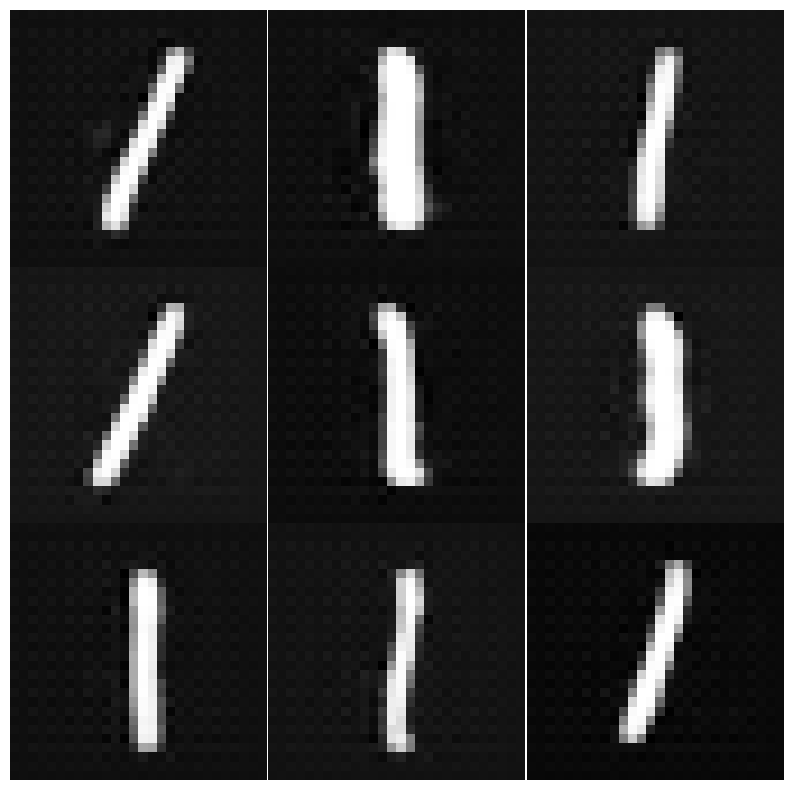

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


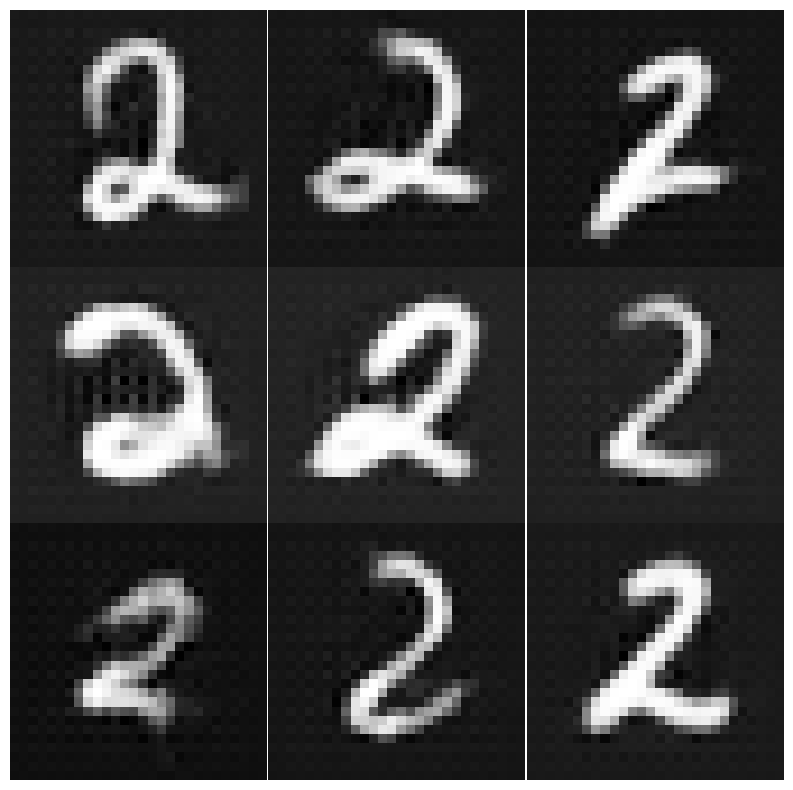

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


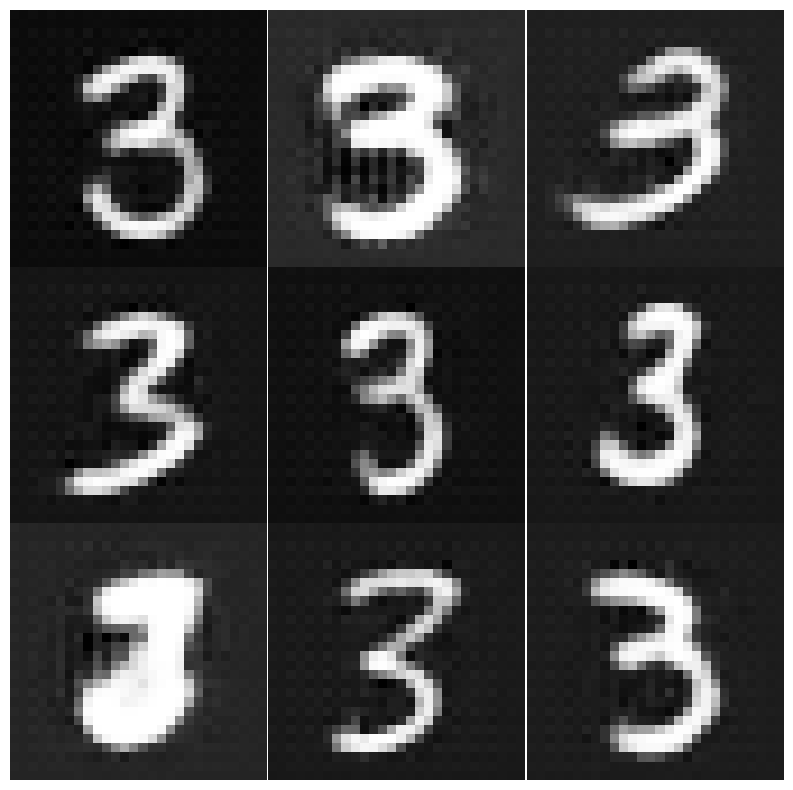

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


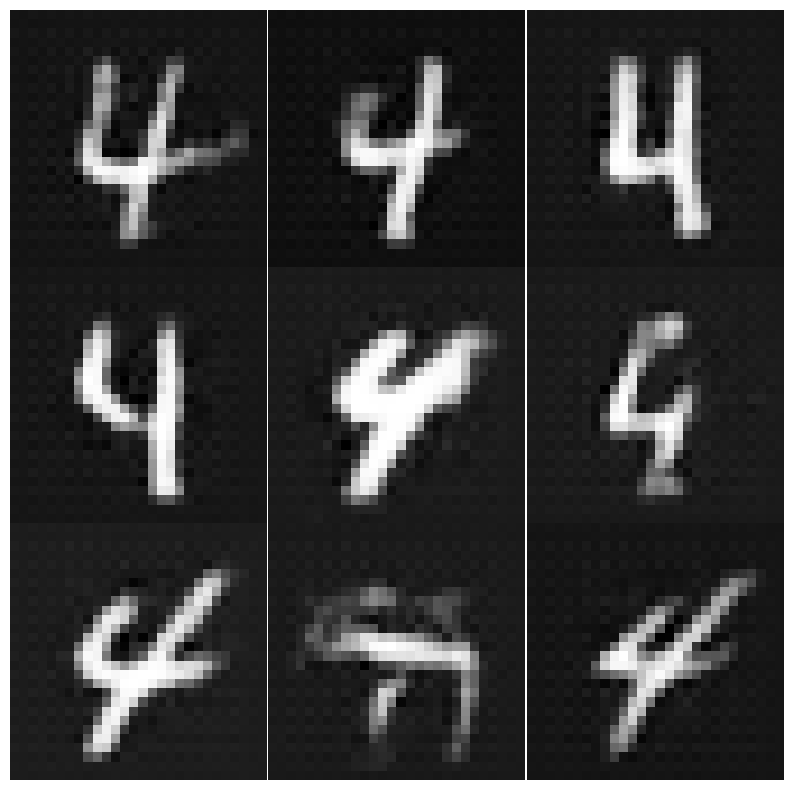

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


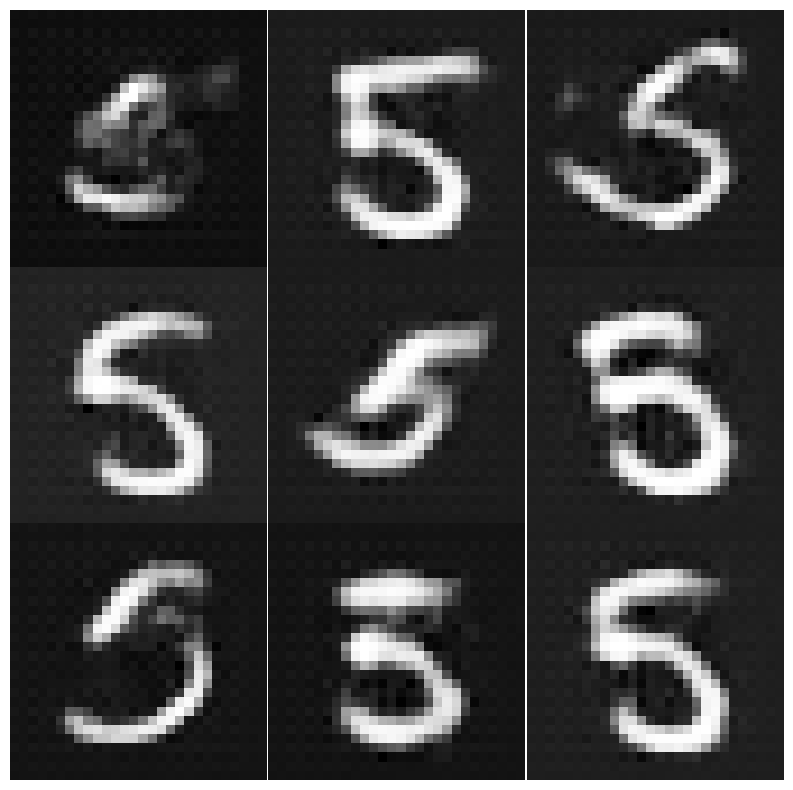

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


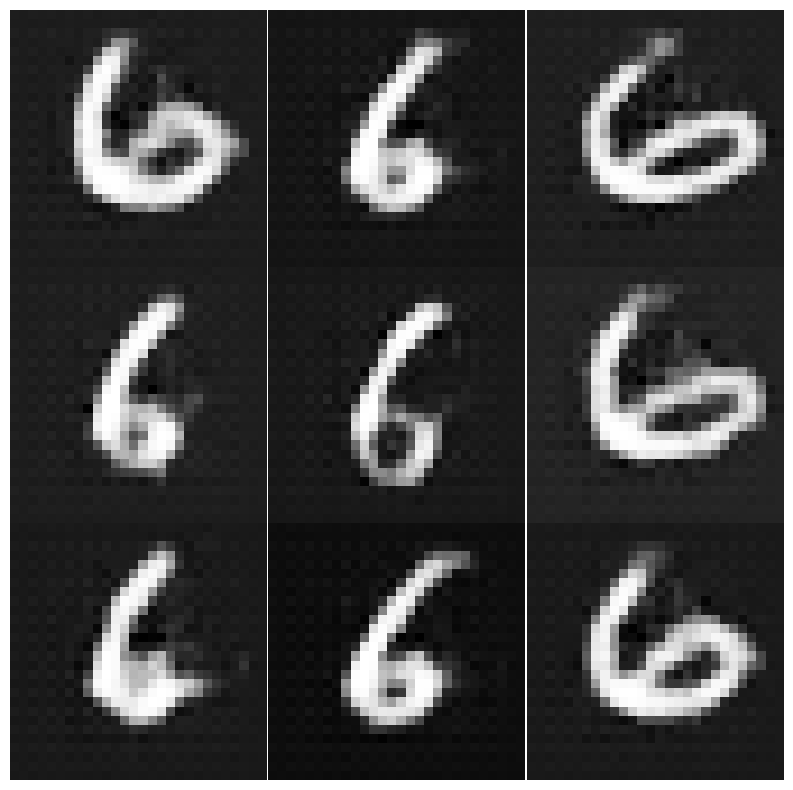

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


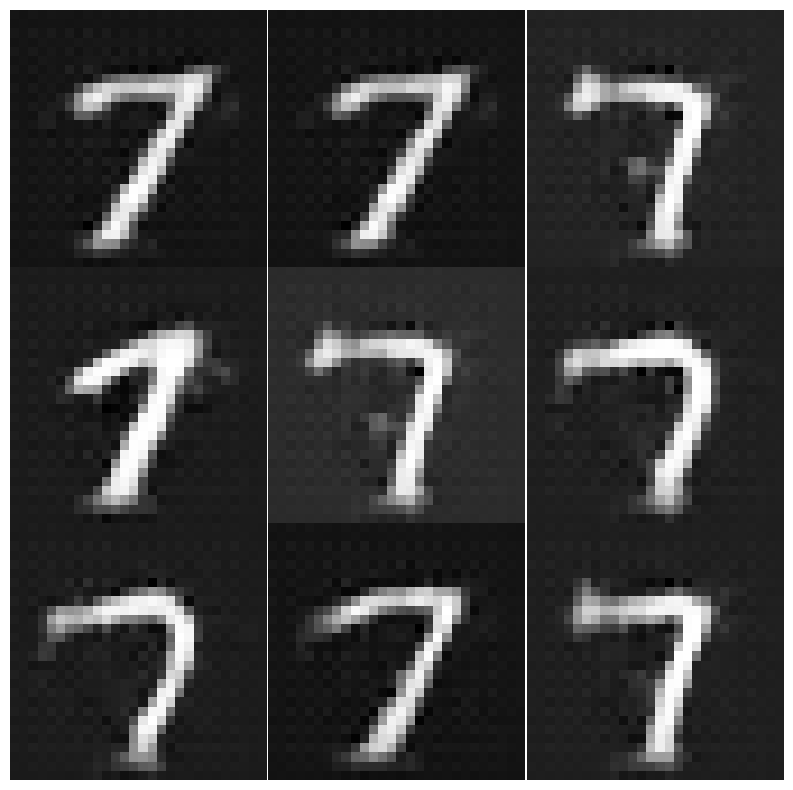

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


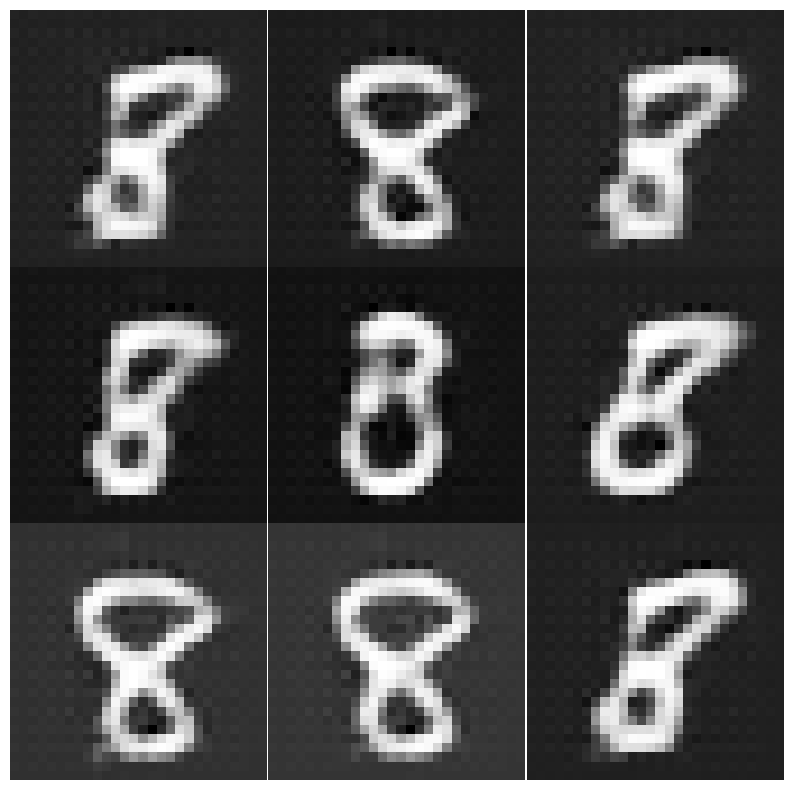

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


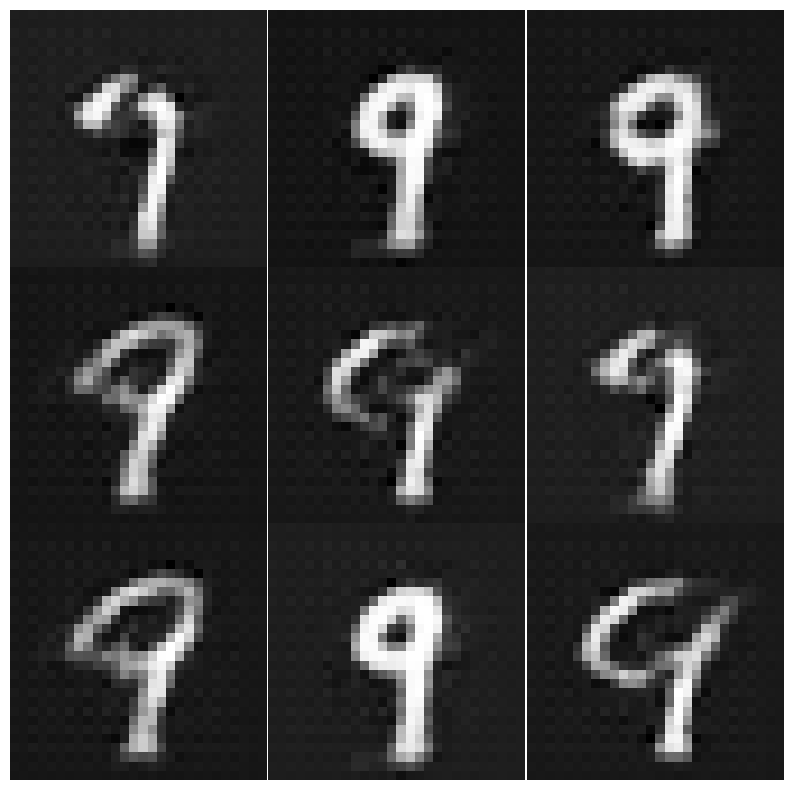

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.11
#Dataset = 1
------ Plot Balanced Imgs ------


------------------------------
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.276687
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.256647
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.197470
Train Epoch: 1 [4000/30000 (13%)]	Loss: 2.029466
Train Epoch: 1 [5000/30000 (17%)]	Loss: 1.457169
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.653974
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.647407
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.350918
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.658983
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.234632
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.106903
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.242206
Train Epoch: 1 [13000/30000 (43%)]	Loss: 0.051602
Train Epoch: 1 [14000/30000 (47%)]	Loss: 0.058995
Train Epoch: 1 [15000/30000 (50%)]	Loss: 0.050108
Train Epoch: 1 [16000/30

Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 0: MSE: 0.2596, Contrastive: 9.7791, Combined: 5.0193


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 1: MSE: 0.0799, Contrastive: 8.1855, Combined: 4.1327


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 2: MSE: 0.0572, Contrastive: 8.0302, Combined: 4.0437


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


Epoch 3: MSE: 0.0428, Contrastive: 7.9747, Combined: 4.0087


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 4: MSE: 0.0364, Contrastive: 7.9325, Combined: 3.9845


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 5: MSE: 0.0273, Contrastive: 7.8157, Combined: 3.9215


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 6: MSE: 0.0227, Contrastive: 7.7559, Combined: 3.8893


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 7: MSE: 0.0197, Contrastive: 7.7406, Combined: 3.8801


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 8: MSE: 0.0180, Contrastive: 7.7173, Combined: 3.8677


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 9: MSE: 0.0166, Contrastive: 7.6959, Combined: 3.8563


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 10: MSE: 0.0156, Contrastive: 7.6669, Combined: 3.8412


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 11: MSE: 0.0158, Contrastive: 7.6741, Combined: 3.8450


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 12: MSE: 0.0148, Contrastive: 7.6514, Combined: 3.8331


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 13: MSE: 0.0147, Contrastive: 7.6706, Combined: 3.8426


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 14: MSE: 0.0145, Contrastive: 7.6754, Combined: 3.8450


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 15: MSE: 0.0136, Contrastive: 7.6773, Combined: 3.8455


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 16: MSE: 0.0137, Contrastive: 7.6718, Combined: 3.8428


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 17: MSE: 0.0134, Contrastive: 7.6582, Combined: 3.8358


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 18: MSE: 0.0128, Contrastive: 7.6628, Combined: 3.8378


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 19: MSE: 0.0127, Contrastive: 7.6761, Combined: 3.8444


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 20: MSE: 0.0129, Contrastive: 7.6701, Combined: 3.8415


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 21: MSE: 0.0129, Contrastive: 7.6941, Combined: 3.8535


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]


Epoch 22: MSE: 0.0124, Contrastive: 7.6882, Combined: 3.8503


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 23: MSE: 0.0122, Contrastive: 7.6938, Combined: 3.8530


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 24: MSE: 0.0121, Contrastive: 7.6996, Combined: 3.8558


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 25: MSE: 0.0118, Contrastive: 7.6834, Combined: 3.8476


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 26: MSE: 0.0123, Contrastive: 7.6970, Combined: 3.8546


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 27: MSE: 0.0118, Contrastive: 7.6972, Combined: 3.8545


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 28: MSE: 0.0117, Contrastive: 7.7027, Combined: 3.8572


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 29: MSE: 0.0119, Contrastive: 7.7153, Combined: 3.8636


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 30: MSE: 0.0118, Contrastive: 7.7291, Combined: 3.8705


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 31: MSE: 0.0114, Contrastive: 7.7076, Combined: 3.8595


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.50it/s]


Epoch 32: MSE: 0.0113, Contrastive: 7.7209, Combined: 3.8661


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 33: MSE: 0.0110, Contrastive: 7.7209, Combined: 3.8659


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 34: MSE: 0.0111, Contrastive: 7.7154, Combined: 3.8633


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


Epoch 35: MSE: 0.0107, Contrastive: 7.7140, Combined: 3.8623


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 36: MSE: 0.0111, Contrastive: 7.7278, Combined: 3.8695


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 37: MSE: 0.0109, Contrastive: 7.7171, Combined: 3.8640


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 38: MSE: 0.0106, Contrastive: 7.7106, Combined: 3.8606


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 39: MSE: 0.0108, Contrastive: 7.7060, Combined: 3.8584


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 40: MSE: 0.0104, Contrastive: 7.7122, Combined: 3.8613


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 41: MSE: 0.0107, Contrastive: 7.7081, Combined: 3.8594


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 42: MSE: 0.0105, Contrastive: 7.7114, Combined: 3.8609


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 43: MSE: 0.0104, Contrastive: 7.7114, Combined: 3.8609


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 44: MSE: 0.0102, Contrastive: 7.7316, Combined: 3.8709


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 45: MSE: 0.0101, Contrastive: 7.7292, Combined: 3.8697


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 46: MSE: 0.0101, Contrastive: 7.7209, Combined: 3.8655


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 47: MSE: 0.0098, Contrastive: 7.7176, Combined: 3.8637


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 48: MSE: 0.0106, Contrastive: 7.7251, Combined: 3.8678


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 49: MSE: 0.0107, Contrastive: 7.7404, Combined: 3.8756


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 50: MSE: 0.0102, Contrastive: 7.7203, Combined: 3.8653


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 51: MSE: 0.0098, Contrastive: 7.7227, Combined: 3.8663


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 52: MSE: 0.0099, Contrastive: 7.7172, Combined: 3.8635


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 53: MSE: 0.0095, Contrastive: 7.7032, Combined: 3.8563


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.62it/s]


Epoch 54: MSE: 0.0095, Contrastive: 7.7191, Combined: 3.8643


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


Epoch 55: MSE: 0.0098, Contrastive: 7.7036, Combined: 3.8567


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 56: MSE: 0.0102, Contrastive: 7.7120, Combined: 3.8611


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.39it/s]


Epoch 57: MSE: 0.0096, Contrastive: 7.7138, Combined: 3.8617


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 58: MSE: 0.0098, Contrastive: 7.7182, Combined: 3.8640


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 59: MSE: 0.0102, Contrastive: 7.7121, Combined: 3.8611


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 60: MSE: 0.0097, Contrastive: 7.7057, Combined: 3.8577


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 61: MSE: 0.0093, Contrastive: 7.7064, Combined: 3.8579


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 62: MSE: 0.0092, Contrastive: 7.7011, Combined: 3.8551


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 63: MSE: 0.0092, Contrastive: 7.6944, Combined: 3.8518


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 64: MSE: 0.0094, Contrastive: 7.7036, Combined: 3.8565


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 65: MSE: 0.0090, Contrastive: 7.7086, Combined: 3.8588


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 66: MSE: 0.0092, Contrastive: 7.7071, Combined: 3.8582


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 67: MSE: 0.0091, Contrastive: 7.7020, Combined: 3.8555


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 68: MSE: 0.0095, Contrastive: 7.6999, Combined: 3.8547


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 69: MSE: 0.0094, Contrastive: 7.7092, Combined: 3.8593


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.50it/s]


Epoch 70: MSE: 0.0092, Contrastive: 7.7064, Combined: 3.8578


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 71: MSE: 0.0093, Contrastive: 7.7086, Combined: 3.8589


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 72: MSE: 0.0090, Contrastive: 7.7029, Combined: 3.8560


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 73: MSE: 0.0089, Contrastive: 7.7161, Combined: 3.8625


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 74: MSE: 0.0093, Contrastive: 7.7175, Combined: 3.8634


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.62it/s]


Epoch 75: MSE: 0.0088, Contrastive: 7.7246, Combined: 3.8667


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 76: MSE: 0.0087, Contrastive: 7.7186, Combined: 3.8637


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 77: MSE: 0.0091, Contrastive: 7.7022, Combined: 3.8557


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 78: MSE: 0.0088, Contrastive: 7.6981, Combined: 3.8534


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 79: MSE: 0.0089, Contrastive: 7.6972, Combined: 3.8530


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 80: MSE: 0.0092, Contrastive: 7.7142, Combined: 3.8617


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 81: MSE: 0.0091, Contrastive: 7.7089, Combined: 3.8590


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 82: MSE: 0.0087, Contrastive: 7.6990, Combined: 3.8539


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 83: MSE: 0.0088, Contrastive: 7.7200, Combined: 3.8644


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.78it/s]


Epoch 84: MSE: 0.0088, Contrastive: 7.7181, Combined: 3.8634


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 85: MSE: 0.0085, Contrastive: 7.7055, Combined: 3.8570


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 86: MSE: 0.0083, Contrastive: 7.7063, Combined: 3.8573


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 87: MSE: 0.0086, Contrastive: 7.7072, Combined: 3.8579


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 88: MSE: 0.0085, Contrastive: 7.6955, Combined: 3.8520


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 89: MSE: 0.0084, Contrastive: 7.6896, Combined: 3.8490


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 90: MSE: 0.0088, Contrastive: 7.7021, Combined: 3.8554


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 91: MSE: 0.0087, Contrastive: 7.7129, Combined: 3.8608


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 92: MSE: 0.0083, Contrastive: 7.6867, Combined: 3.8475


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 93: MSE: 0.0084, Contrastive: 7.6985, Combined: 3.8534


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 94: MSE: 0.0085, Contrastive: 7.6856, Combined: 3.8470


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 95: MSE: 0.0086, Contrastive: 7.7147, Combined: 3.8617


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 96: MSE: 0.0086, Contrastive: 7.7053, Combined: 3.8569


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 97: MSE: 0.0086, Contrastive: 7.7105, Combined: 3.8596


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 98: MSE: 0.0086, Contrastive: 7.6960, Combined: 3.8523


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 99: MSE: 0.0082, Contrastive: 7.6965, Combined: 3.8524


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 100: MSE: 0.0086, Contrastive: 7.7049, Combined: 3.8568


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 101: MSE: 0.0085, Contrastive: 7.7005, Combined: 3.8545


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 102: MSE: 0.0087, Contrastive: 7.7153, Combined: 3.8620


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 103: MSE: 0.0086, Contrastive: 7.7065, Combined: 3.8575


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 104: MSE: 0.0086, Contrastive: 7.6990, Combined: 3.8538


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 105: MSE: 0.0090, Contrastive: 7.7105, Combined: 3.8597


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


Epoch 106: MSE: 0.0083, Contrastive: 7.7015, Combined: 3.8549


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 107: MSE: 0.0083, Contrastive: 7.7010, Combined: 3.8546


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 108: MSE: 0.0081, Contrastive: 7.7126, Combined: 3.8604


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


Epoch 109: MSE: 0.0082, Contrastive: 7.6980, Combined: 3.8531


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]


Epoch 110: MSE: 0.0081, Contrastive: 7.6962, Combined: 3.8521


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 111: MSE: 0.0084, Contrastive: 7.7119, Combined: 3.8601


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.37it/s]


Epoch 112: MSE: 0.0082, Contrastive: 7.7063, Combined: 3.8573


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


Epoch 113: MSE: 0.0083, Contrastive: 7.6956, Combined: 3.8520


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 114: MSE: 0.0080, Contrastive: 7.6971, Combined: 3.8525


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 115: MSE: 0.0083, Contrastive: 7.7009, Combined: 3.8546


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 116: MSE: 0.0081, Contrastive: 7.6938, Combined: 3.8509


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 117: MSE: 0.0083, Contrastive: 7.6922, Combined: 3.8502


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 118: MSE: 0.0085, Contrastive: 7.7013, Combined: 3.8549


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 119: MSE: 0.0082, Contrastive: 7.7053, Combined: 3.8567


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 120: MSE: 0.0081, Contrastive: 7.6998, Combined: 3.8540


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 121: MSE: 0.0084, Contrastive: 7.7048, Combined: 3.8566


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.55it/s]


Epoch 122: MSE: 0.0082, Contrastive: 7.6975, Combined: 3.8528


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 123: MSE: 0.0083, Contrastive: 7.7154, Combined: 3.8619


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 124: MSE: 0.0082, Contrastive: 7.7081, Combined: 3.8582


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 125: MSE: 0.0082, Contrastive: 7.7024, Combined: 3.8553


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 126: MSE: 0.0080, Contrastive: 7.6987, Combined: 3.8534


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]


Epoch 127: MSE: 0.0078, Contrastive: 7.6932, Combined: 3.8505


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


Epoch 128: MSE: 0.0078, Contrastive: 7.6837, Combined: 3.8458


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.62it/s]


Epoch 129: MSE: 0.0083, Contrastive: 7.6949, Combined: 3.8516


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 130: MSE: 0.0080, Contrastive: 7.7040, Combined: 3.8560


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 131: MSE: 0.0079, Contrastive: 7.6999, Combined: 3.8539


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 132: MSE: 0.0080, Contrastive: 7.6973, Combined: 3.8526


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 133: MSE: 0.0079, Contrastive: 7.6976, Combined: 3.8528


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 134: MSE: 0.0081, Contrastive: 7.6947, Combined: 3.8514


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 135: MSE: 0.0080, Contrastive: 7.6945, Combined: 3.8513


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 136: MSE: 0.0082, Contrastive: 7.7021, Combined: 3.8551


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.74it/s]


Epoch 137: MSE: 0.0080, Contrastive: 7.7005, Combined: 3.8543


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 138: MSE: 0.0078, Contrastive: 7.6849, Combined: 3.8463


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 139: MSE: 0.0078, Contrastive: 7.6886, Combined: 3.8482


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 140: MSE: 0.0079, Contrastive: 7.7118, Combined: 3.8599


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 141: MSE: 0.0081, Contrastive: 7.7040, Combined: 3.8560


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 142: MSE: 0.0078, Contrastive: 7.7021, Combined: 3.8550


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 143: MSE: 0.0078, Contrastive: 7.7089, Combined: 3.8584


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 144: MSE: 0.0080, Contrastive: 7.6938, Combined: 3.8509


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 145: MSE: 0.0081, Contrastive: 7.6972, Combined: 3.8527


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 146: MSE: 0.0077, Contrastive: 7.6958, Combined: 3.8518


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 147: MSE: 0.0078, Contrastive: 7.7019, Combined: 3.8549


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 148: MSE: 0.0082, Contrastive: 7.7185, Combined: 3.8633


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 149: MSE: 0.0079, Contrastive: 7.6990, Combined: 3.8534


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 150: MSE: 0.0077, Contrastive: 7.6968, Combined: 3.8522


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.73it/s]


Epoch 151: MSE: 0.0080, Contrastive: 7.6929, Combined: 3.8505


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 152: MSE: 0.0077, Contrastive: 7.7057, Combined: 3.8567


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.79it/s]


Epoch 153: MSE: 0.0078, Contrastive: 7.6996, Combined: 3.8537


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 154: MSE: 0.0075, Contrastive: 7.7004, Combined: 3.8540


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 155: MSE: 0.0077, Contrastive: 7.6872, Combined: 3.8475


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]


Epoch 156: MSE: 0.0077, Contrastive: 7.7105, Combined: 3.8591


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.80it/s]


Epoch 157: MSE: 0.0075, Contrastive: 7.6881, Combined: 3.8478


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.81it/s]


Epoch 158: MSE: 0.0075, Contrastive: 7.6882, Combined: 3.8478


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 159: MSE: 0.0078, Contrastive: 7.6830, Combined: 3.8454


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.79it/s]


Epoch 160: MSE: 0.0076, Contrastive: 7.6936, Combined: 3.8506


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]


Epoch 161: MSE: 0.0074, Contrastive: 7.7016, Combined: 3.8545


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.80it/s]


Epoch 162: MSE: 0.0071, Contrastive: 7.6808, Combined: 3.8439


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.78it/s]


Epoch 163: MSE: 0.0074, Contrastive: 7.6917, Combined: 3.8496


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 164: MSE: 0.0072, Contrastive: 7.6994, Combined: 3.8533


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 165: MSE: 0.0072, Contrastive: 7.6908, Combined: 3.8490


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]


Epoch 166: MSE: 0.0074, Contrastive: 7.6877, Combined: 3.8475


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 167: MSE: 0.0074, Contrastive: 7.7093, Combined: 3.8584


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.73it/s]


Epoch 168: MSE: 0.0071, Contrastive: 7.6829, Combined: 3.8450


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.69it/s]


Epoch 169: MSE: 0.0075, Contrastive: 7.6857, Combined: 3.8466


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.77it/s]


Epoch 170: MSE: 0.0074, Contrastive: 7.6927, Combined: 3.8501


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.76it/s]


Epoch 171: MSE: 0.0073, Contrastive: 7.6908, Combined: 3.8491


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 172: MSE: 0.0070, Contrastive: 7.6903, Combined: 3.8487


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 173: MSE: 0.0073, Contrastive: 7.6969, Combined: 3.8521


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 174: MSE: 0.0073, Contrastive: 7.7024, Combined: 3.8548


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 175: MSE: 0.0076, Contrastive: 7.7021, Combined: 3.8549


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


Epoch 176: MSE: 0.0076, Contrastive: 7.6974, Combined: 3.8525


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 177: MSE: 0.0073, Contrastive: 7.6936, Combined: 3.8504


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 178: MSE: 0.0069, Contrastive: 7.6987, Combined: 3.8528


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 179: MSE: 0.0071, Contrastive: 7.6890, Combined: 3.8480


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 180: MSE: 0.0068, Contrastive: 7.6780, Combined: 3.8424


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 181: MSE: 0.0070, Contrastive: 7.6826, Combined: 3.8448


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 182: MSE: 0.0068, Contrastive: 7.6834, Combined: 3.8451


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 183: MSE: 0.0069, Contrastive: 7.6951, Combined: 3.8510


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 184: MSE: 0.0070, Contrastive: 7.6954, Combined: 3.8512


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.67it/s]


Epoch 185: MSE: 0.0071, Contrastive: 7.7040, Combined: 3.8556


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 186: MSE: 0.0070, Contrastive: 7.6931, Combined: 3.8500


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]


Epoch 187: MSE: 0.0068, Contrastive: 7.6993, Combined: 3.8530


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 188: MSE: 0.0069, Contrastive: 7.6915, Combined: 3.8492


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 189: MSE: 0.0067, Contrastive: 7.6967, Combined: 3.8517


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.50it/s]


Epoch 190: MSE: 0.0069, Contrastive: 7.6992, Combined: 3.8530


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]


Epoch 191: MSE: 0.0071, Contrastive: 7.6917, Combined: 3.8494


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 192: MSE: 0.0070, Contrastive: 7.6906, Combined: 3.8488


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


Epoch 193: MSE: 0.0068, Contrastive: 7.6834, Combined: 3.8451


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]


Epoch 194: MSE: 0.0068, Contrastive: 7.7009, Combined: 3.8538


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 195: MSE: 0.0070, Contrastive: 7.7037, Combined: 3.8554


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 196: MSE: 0.0068, Contrastive: 7.6944, Combined: 3.8506


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]


Epoch 197: MSE: 0.0067, Contrastive: 7.6887, Combined: 3.8477


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]


Epoch 198: MSE: 0.0069, Contrastive: 7.6995, Combined: 3.8532


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]


Epoch 199: MSE: 0.0068, Contrastive: 7.7035, Combined: 3.8551
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.22
------ Plot Latent Space ------


------------------------------
0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


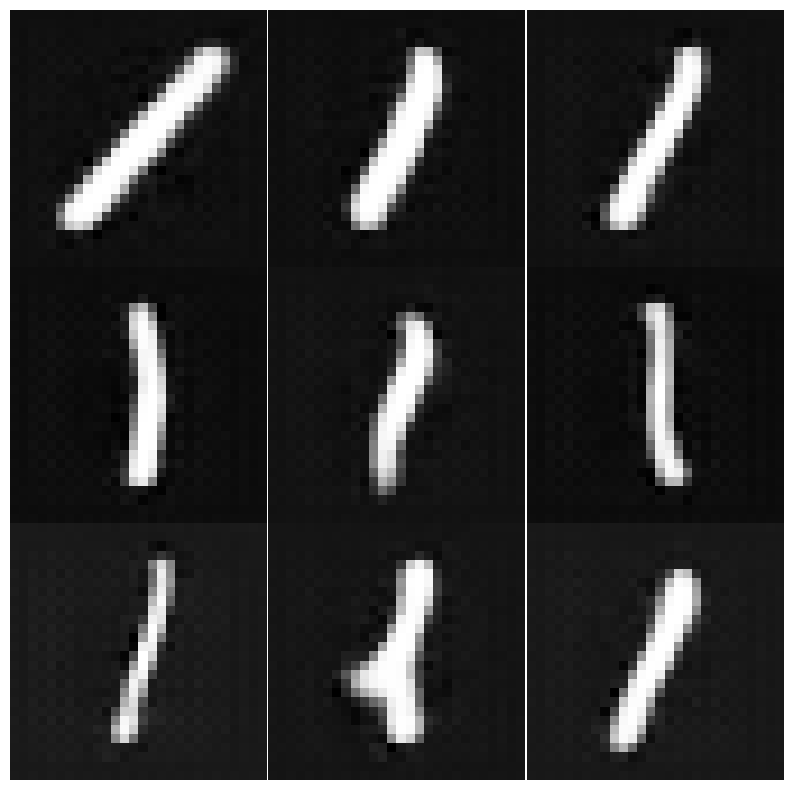

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


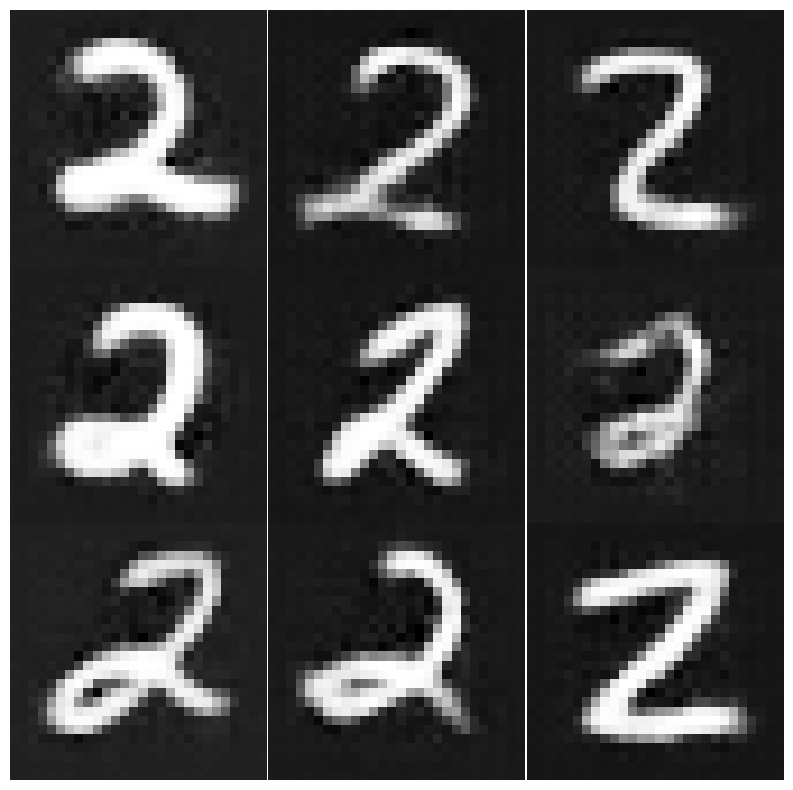

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


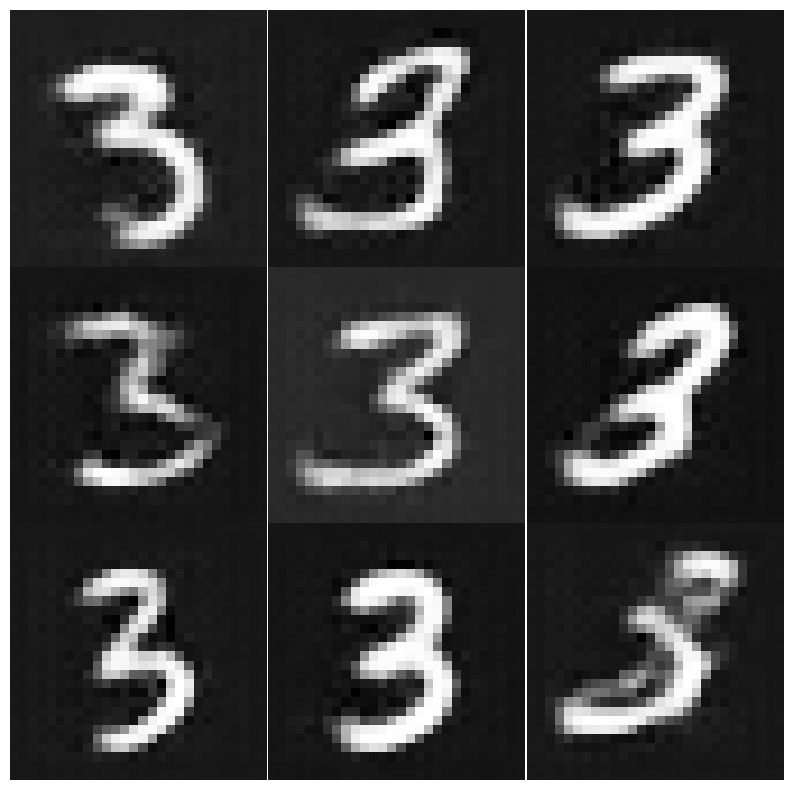

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


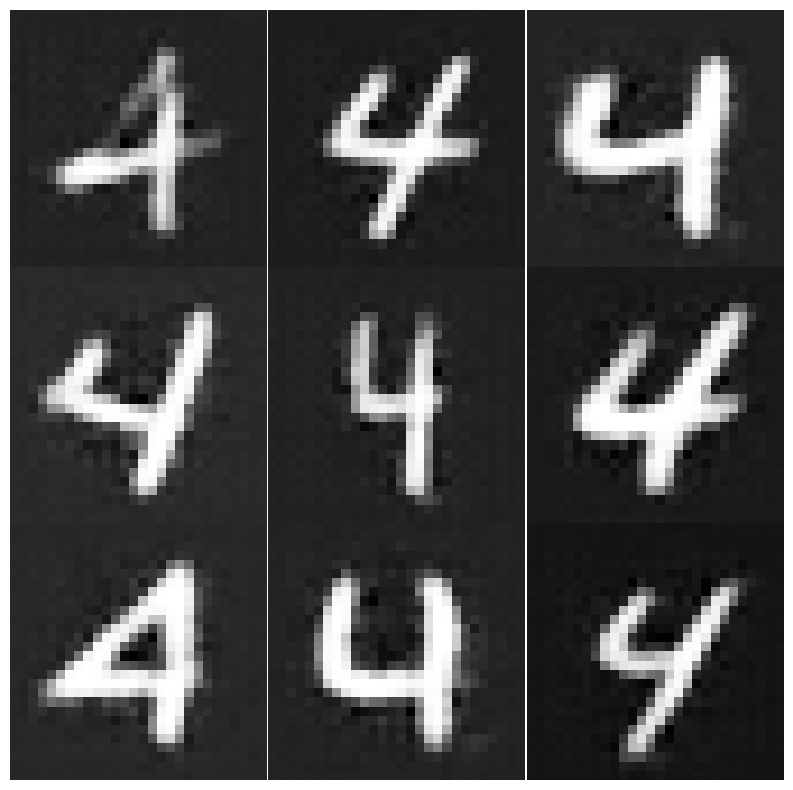

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


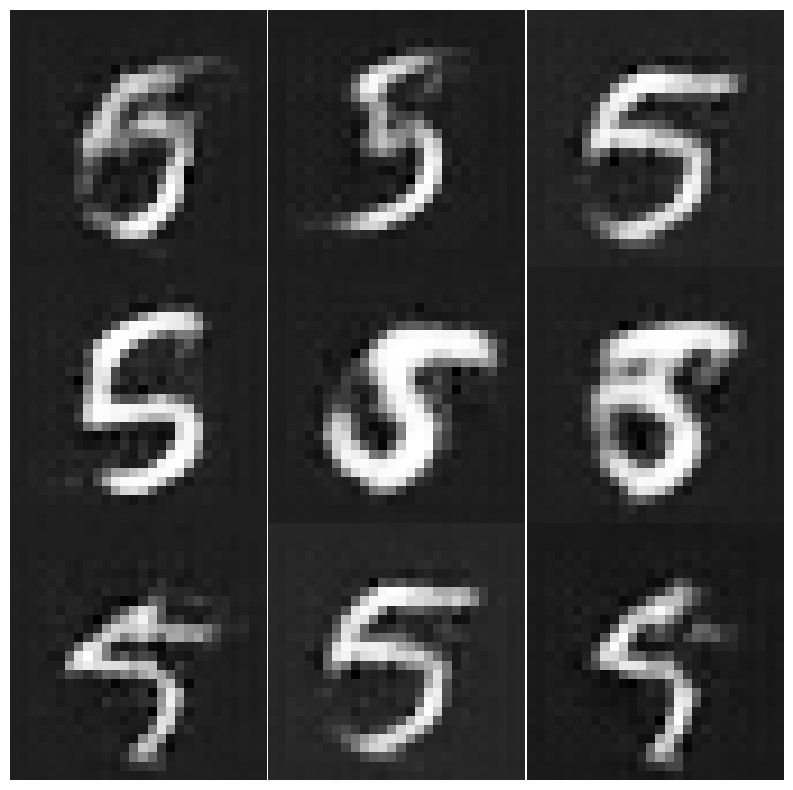

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


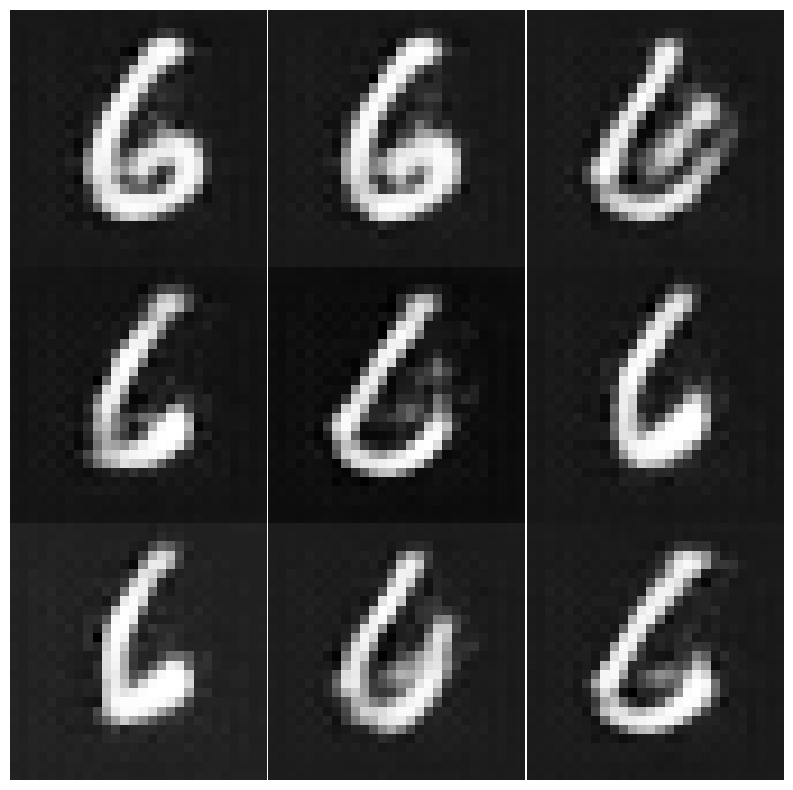

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


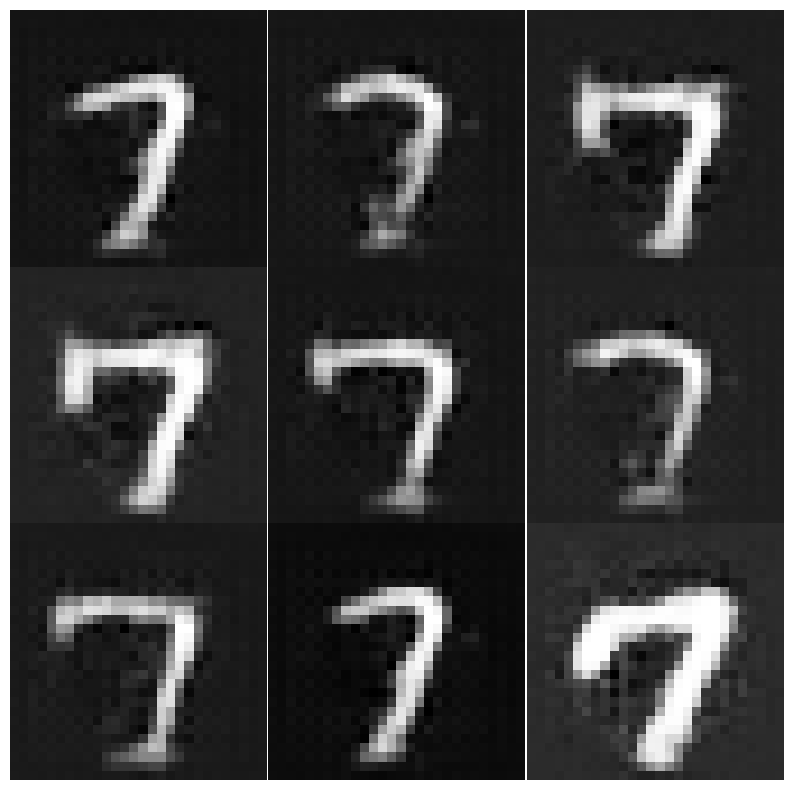

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


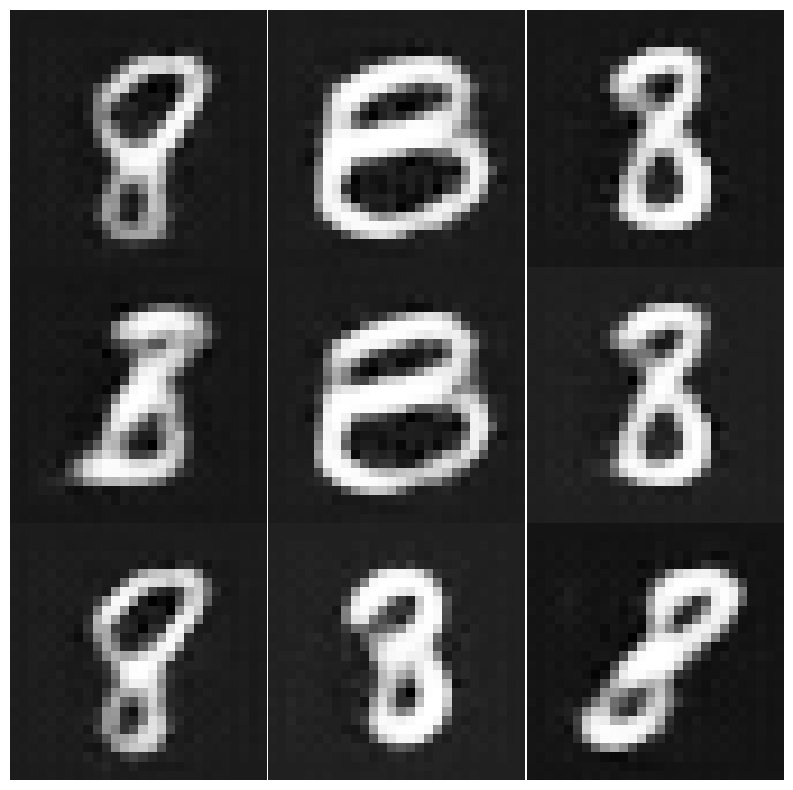

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


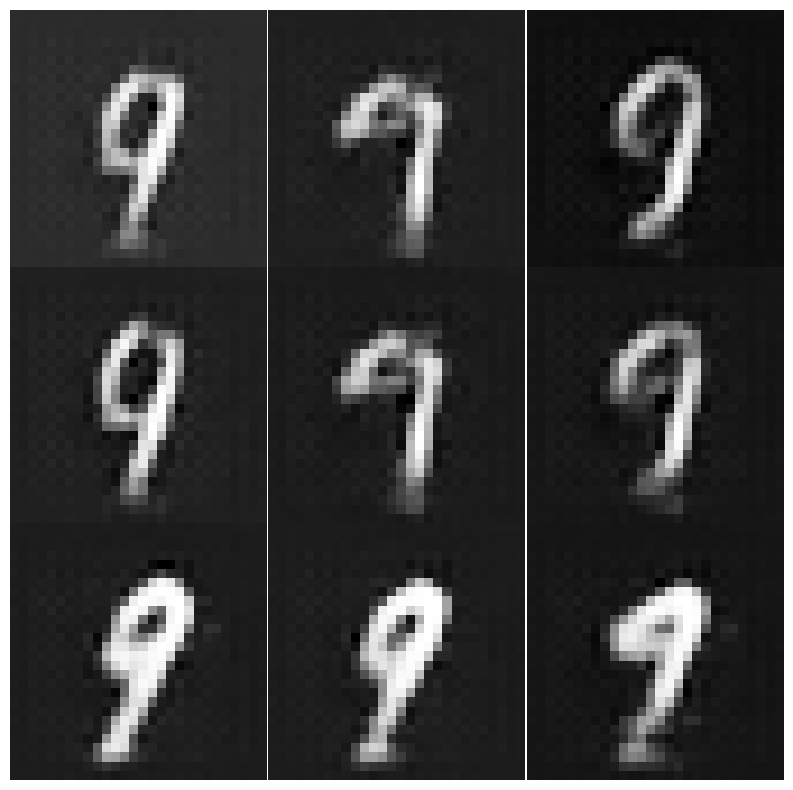

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.11
#Dataset = 1
------ Plot Balanced Imgs ------


------------------------------
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.293590
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.255499
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.193057
Train Epoch: 1 [4000/30000 (13%)]	Loss: 2.035472
Train Epoch: 1 [5000/30000 (17%)]	Loss: 1.578660
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.788328
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.457355
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.450689
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.303740
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.292746
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.202108
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.326279
Train Epoch: 1 [13000/30000 (43%)]	Loss: 0.167416
Train Epoch: 1 [14000/30000 (47%)]	Loss: 0.054822
Train Epoch: 1 [15000/30000 (50%)]	Loss: 0.163505
Train Epoch: 1 [16000/30

In [13]:
args['epochs'] = 200 # how many epochs to run for (original used 200)

trainingDataset_loss = []
avg_accuracy_list = []
avg_sensitivity_list = []
avg_specificity_list = []
avg_precision_list = []

g_mean_list = []
f_measure_list = []
acsa_list = []
cm_list = []

temperature = 0.1      # SupCon temperature
alpha = 0.5

t3=0
for dataset,imbalanced_train in zip(folds_data,imbalanced_train_dataset_list):  #len(ids)
    print()
    print('Start...')
    encoder = Encoder(args)
    decoder = Decoder(args)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    train_on_gpu = torch.cuda.is_available()

    #decoder loss function
    criterion = nn.MSELoss()
    criterion = criterion.to(device)
    

    #criterion2 = NTXentLoss(temperature=0.5).to(device)
    criterion2 = SupConLoss().to(device)
    
    batch_size = 100
    num_workers = 0

    train_loader = dataset[0]

    classes = ('0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9')

    best_loss = np.inf

    list_zhat_test,list_labs_test = [],[]

    t0 = time.time()
    if args['train']:
        enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
        dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

        for epoch in range(args['epochs']):
            train_loss = 0.0
            tmse_loss = 0.0
            tdiscr_loss = 0.0
            
            epoch_mse = 0.0
            epoch_contrast = 0.0
            
            encoder.train()
            decoder.train()
            
            for images,labs in tqdm(train_loader,desc='Loading...'):

                # zero gradients for each batch
                enc_optim.zero_grad()   
                dec_optim.zero_grad()
                
                images, labs = images.to(device), labs.to(device)
                labsn = labs.detach().cpu().numpy()

                # run images
                z_hat,class_hat = encoder(images,labsn)
                
                # sort z_hat and class_hat by labels
                sort_z_hat = [[] for _ in range(args['num_class'])]
                sort_labs = [[] for _ in range(args['num_class'])]
                for i, label in enumerate(labsn):
                    sort_z_hat[label].append(z_hat[i].cpu().detach().numpy())
                    sort_labs[label].append(labsn[i])
                     
                # Create a sorted labels tensor
                sorted_labels_list = []
                for sublist in sort_labs:
                    sorted_labels_list.extend(sublist)
                sorted_labels = torch.tensor(sorted_labels_list).long().to(device)
                     
                # Check if sort_z_hat is empty
                z_hat_to_concat = []
                for tensor in sort_z_hat:
                    if len(tensor) != 0:
                        z_hat_to_concat.append(torch.tensor(tensor).to(device))
                        
                if z_hat_to_concat:
                    combined_z_hat = torch.cat(z_hat_to_concat, dim=0)
                    #print('combined_z_hat',combined_z_hat.shape)
                else:
                    print('No valid tensors to concatenate, using zero tensor')
                    combined_z_hat = torch.zeros((1, args['n_z'])).to(device)

                # Check if class_hat is empty
                class_hat_to_concat = []
                for tensor in class_hat:
                    if len(tensor) != 0:
                        class_hat_to_concat.append(tensor)
                if class_hat_to_concat:
                    combined_class_hat = torch.cat(class_hat_to_concat, dim=0)
                    #print('combined_class_hat',combined_class_hat.shape)
                else:
                    print('No valid tensors to concatenate, using zero tensor')
                    combined_class_hat = torch.zeros((1, args['n_z'])).to(device)


                # *Option* L2 normalization
                combined_z_hat = F.normalize(combined_z_hat, dim=1)
                combined_class_hat = F.normalize(combined_class_hat, dim=1)
                
                features = torch.stack([combined_z_hat, combined_class_hat], dim=1)
                # The new shape of the 'features' tensor is [100, 2, 300]
                #print(features.shape)
                
                mse2 = criterion2(features=features, labels=sorted_labels, temperature=temperature)
                
                if epoch == args['epochs']-1:
                      list_labs_test = np.append(list_labs_test, labsn )
                      list_zhat_test = np.append(list_zhat_test,z_hat.cpu().detach().numpy())

                x_hat = decoder(z_hat)

                # --- MSE loss ---
                mse = criterion(x_hat, images)
     
                # --- Combined loss ---
                #alpha = 1 - min(0.5, epoch / 200) # (1 - alpha) will gradually increase

                comb_loss = alpha * mse + (1 - alpha) * mse2
                comb_loss.backward()
                
                # --- Step optimizers ---
                enc_optim.step()
                dec_optim.step()
                
                # accumulate for logging
                epoch_mse += mse.item() * images.size(0)
                epoch_contrast += mse2.item() * images.size(0)         

            # --- Log epoch losses ---
            avg_mse = epoch_mse / len(train_loader.dataset)
            avg_contrast = epoch_contrast / len(train_loader.dataset)
            avg_comb = avg_mse * alpha + avg_contrast * (1-alpha)
            print(f"Epoch {epoch}: MSE: {avg_mse:.4f}, Contrastive: {avg_contrast:.4f}, Combined: {avg_comb:.4f}")
            trainingDataset_loss.append(train_loss)
            
        #save model
        path_enc = '/home/s2522002/source_code/model/enc_mnist.pth'
        path_dec = '/home/s2522002/source_code/model/dec_mnist.pth'
        print(path_enc)
        print(path_dec)
        torch.save(encoder.state_dict(), path_enc)
        torch.save(decoder.state_dict(), path_dec)
        print()

    t1 = time.time()
    print('total time(min): {:.2f}'.format((t1 - t0)/60))
    
    ################  PLOT TRAIN DISTRIBUTION ######################
    import numpy as np
    import plotly.express as px
    
    copy_list_zhat_test = list_zhat_test.copy()
    
    first_dim = len(list_zhat_test) // args['n_z']
    list_zhat_test_reshape =  copy_list_zhat_test.reshape(first_dim, args['n_z'])
    
    from sklearn.manifold import TSNE
    print('------ Plot Latent Space ------')
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(list_zhat_test_reshape)
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=list_labs_test)
    fig.show()
    print('------------------------------')
    
    ############ GENERATE ###########################################################
    import collections
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset
    import numpy as np
    import time
    import os
    import matplotlib.pyplot as plt
    np.printoptions(precision=5,suppress=True)
    
    #path on the computer where the models are stored
    latent_img,latent_lab = [],[]
    modpth = '/home/s2522002/source_code/model'    
    
    encf = []
    decf = []
    for p in range(1):
        enc = modpth + '/' + '/enc_mnist.pth'
        dec = modpth + '/' + '/dec_mnist.pth'
        encf.append(enc)
        decf.append(dec)
    
    for m in range(1):
        print(m)
    
        classes = ('0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9')
    
        #generate some images
        train_on_gpu = torch.cuda.is_available()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        path_enc = encf[m]
        path_dec = decf[m]
    
        encoder = Encoder(args)
        # Load the encoder state dictionary and map to the available device
        encoder.load_state_dict(torch.load(path_enc, map_location=device), strict=False)
        encoder = encoder.to(device)
    
        decoder = Decoder(args)
        decoder.load_state_dict(torch.load(path_dec, map_location=device), strict=False)
        decoder = decoder.to(device)
    
        encoder.eval()
        decoder.eval()
    
        imbal = [3000, 2000, 1000, 750, 500, 12, 10, 8, 6, 4]
    
        resx = []
        resy = []
        
        data = [item[0] for item in imbalanced_train]
        target = [item[1] for item in imbalanced_train]
        data = torch.stack(data)
        target = torch.tensor(target)

        t0 = time.time()
        for i in range(1,10):
    
            xclass, yclass = biased_get_class1(i,data,target)
    
            print(xclass.shape) 
            print('class',yclass[0]) 
    
            #encode xclass to feature space
            xclass = xclass.to(device)
            xclass,_ = encoder(xclass,yclass)
            print(xclass.shape) 

            xclass = xclass.detach().cpu().numpy()

            latent_img = np.append(latent_img, xclass)
            latent_lab = np.append(latent_lab, yclass)
            
            n = imbal[0] - imbal[i]
    
            #SMOTE
            xsamp, ysamp = Generate_SMOTE(xclass,yclass,n,i)
            print('after smote',xsamp.shape) #(4500, 600)
            ysamp = np.array(ysamp)
            print('after smote',ysamp.shape) #4500
            xsamp = torch.Tensor(xsamp)
            xsamp = xsamp.to(device)
            
            print('after smote&to tensor',xsamp.shape) 
           
            ximg = decoder(xsamp)
    
            ximn = ximg.detach().cpu().numpy()
            print('after decoder',ximn.shape) #(4500, 3, 32, 32)
           
            resx.append(ximn)
            resy.append(ysamp)
    
            # Squeeze the first dimension to get a compatible shape for imshow
            
            plt.figure(figsize=(10,10))
            for k in range(9):
              plt.subplot(3,3,k+1)
              ximn_squeezed = ximn[k].squeeze()
              plt.imshow(ximn_squeezed, cmap='gray')
              plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.show()
    
        t1 = time.time()
        resx1 = np.vstack(resx)
        resy1 = np.hstack(resy)
    
        print('after generate',resx1.shape) #(34720, 3, 32, 32)
        print('after generate',resy1.shape) #(34720,)
    
        resx1 = resx1.reshape(resx1.shape[0],-1)
        print('reshape',resx1.shape) #(34720, 3072)
    
        dec_x1 = data.reshape(data.shape[0],-1)
        print('decx1(imb imported) ',dec_x1.shape)
        combx = np.vstack((resx1,dec_x1))
        comby = np.hstack((resy1,target))
    
        print('combined',combx.shape) #(45000, 3, 32, 32)
        print('combined',comby.shape) #(45000,)
    
        ifile = '/home/s2522002/source_code/sampling/balimg_mnist/trn_img.txt'
        np.savetxt(ifile, combx)

        lfile = '/home/s2522002/source_code/sampling/ballab_mnist/trn_lab.txt'
        np.savetxt(lfile,comby)
    
        print()
        #sys.exit(1)
    
    
    print('final time(min): {:.2f}'.format((t1 - t0)/60))

    #  PLOT BALANCED DISTRIBUTION ##########################################################
    from sklearn.manifold import TSNE
    dtrnimg = '/home/s2522002/source_code/sampling/balimg_mnist'
    dtrnlab = '/home/s2522002/source_code/sampling/ballab_mnist'
    
    ids = os.listdir(dtrnimg)
    idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
    
    ids = os.listdir(dtrnlab)
    idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
    
    print("#Dataset =",len(ids))
    # Load the training images and labels
    trnimgfile = idtri_f[0]
    trnlabfile = idtrl_f[0]
    dec_x = np.loadtxt(trnimgfile)
    dec_y = np.loadtxt(trnlabfile)

    print('------ Plot Balanced Imgs ------')

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(dec_x)
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=dec_y)
    fig.show()
    
    print('------------------------------')
    #  IMPORT BALANCED IMAGES ###########################################################
    from sklearn.model_selection import KFold
    import numpy as np
    import collections
    import torch
    from torch.utils.data import TensorDataset
    
    dtrnimg = '/home/s2522002/source_code/sampling/balimg_mnist'
    dtrnlab = '/home/s2522002/source_code/sampling/ballab_mnist'
    
    ids = os.listdir(dtrnimg)
    idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
    
    ids = os.listdir(dtrnlab)
    idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
    
    print("#Dataset =",len(ids))
    
    trnimgfile = idtri_f[0]
    trnlabfile = idtrl_f[0]
    dec_x = np.loadtxt(trnimgfile)
    dec_y = np.loadtxt(trnlabfile)
    
    #Reshape
    dec_x = dec_x.reshape(dec_x.shape[0],args['n_channel'] ,28,28)
    
    batch_size = 100
    num_workers = 0
    
    #torch.Tensor returns float so if want long then use torch.tensor
    tensor_x = torch.Tensor(dec_x)
    tensor_y = torch.tensor(dec_y,dtype=torch.long)
    mnist_bal = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(mnist_bal,
                    batch_size=batch_size,shuffle=True,num_workers=num_workers)
    
    print(np.shape(dec_x))
    print(np.shape(dec_y))
    
    print(collections.Counter(dec_y))
    
    print('train imgs after reshape ',dec_x.shape)

    ###########################  TRAIN CNN  ####################################################
    # Create model, optimizer, and loss function
    #check gpu
    import torch.optim as optim
    import torch.nn as nn
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #set hyperparameters
    EPOCH = 2
    pre_epoch = 0
    BATCH_SIZE = 100
    LR = 0.01
    
    model = SimpleCNN().to(device)#ResNetMNIST().to(device)#SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #optim.Adam(model.parameters())
    
    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
    
            output = model(data)
    
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
            if (batch_idx + 1) % 10 == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch + 1,
                        (batch_idx+1) * len(data),
                        len(train_loader.dataset),
                        100.0 * (batch_idx+1) / len(train_loader),
                        loss.item(),
                    )
                )
    
    print("Training finished!")


    ########################### TEST CNN ####################################################
    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set the model to evaluation mode
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in dataset[1]:
            data = data.to(device)
            target = target.to(device)
    
            output = model(data)
            _, predicted = torch.max(output.data, 1)
    
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)
    cm_list.append(cm)
    
    # Calculate class-wise accuracy, sensitivity, specificity, and precision
    class_accuracies = []
    class_sensitivities = []
    class_specificities = []
    class_precisions = []
    
    for i in range(cm.shape[0]):
      tp = cm[i, i]
      fp = np.sum(cm[:, i]) - tp
      fn = np.sum(cm[i, :]) - tp
      tn = np.sum(cm) - tp - fp - fn
    
      class_accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
      class_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
      class_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
      class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
      class_accuracies.append(class_accuracy)
      class_sensitivities.append(class_sensitivity)
      class_specificities.append(class_specificity)
      class_precisions.append(class_precision)
    
    # Calculate the average accuracy, sensitivity, specificity, and precision
    avg_accuracy = np.mean(class_accuracies)
    avg_sensitivity = np.mean(class_sensitivities)
    avg_specificity = np.mean(class_specificities)
    avg_precision = np.mean(class_precisions)
    
    # Calculate G-mean and F-measure
    g_mean = np.sqrt(avg_sensitivity * avg_specificity)
    f_measure = 2 * (avg_precision * avg_sensitivity) / (avg_precision + avg_sensitivity) if (avg_precision + avg_sensitivity) > 0 else 0
    
    print("\nAverage Accuracy:", avg_accuracy)
    print("Average Sensitivity:", avg_sensitivity)
    print("Average Specificity:", avg_specificity)
    print("Average Precision:", avg_precision)
    
    print("\nG-mean:", g_mean)
    print("F-measure:", f_measure)
    
    # Calculate ACSA (Average Class-wise Sensitivity and Accuracy)
    acsa = (avg_sensitivity + avg_accuracy) / 2
    print("\nACSA:", acsa)
    
    avg_accuracy_list.append(avg_accuracy)
    print(avg_accuracy_list)
    avg_sensitivity_list.append(avg_sensitivity)
    avg_specificity_list.append(avg_specificity)
    avg_precision_list.append(avg_precision)
    g_mean_list.append(g_mean)
    f_measure_list.append(f_measure)
    acsa_list.append(acsa)

t4 = time.time()
print('final time(min): {:.2f}'.format((t4 - t3)/60))

### Avg via folders

In [14]:
import statistics
print("Average Accuracy:", statistics.mean(avg_accuracy_list))
print("Average Sensitivity:", statistics.mean(avg_sensitivity_list))
print("Average Specificity:", statistics.mean(avg_specificity_list))
print("Average Precision:", statistics.mean(avg_precision_list))

print("\nG-mean:", statistics.mean(g_mean_list))
print("F-measure:", statistics.mean(f_measure_list))
print("\nACSA:", statistics.mean(acsa_list))
print(cm_list)

Average Accuracy: 0.9479948349013098
Average Sensitivity: 0.7399741745065486
Average Specificity: 0.9711082416118387
Average Precision: 0.7945675108625928

G-mean: 0.8476992042993491
F-measure: 0.7662894916317371

ACSA: 0.8439845047039292
[array([[1787,    3,    4,   10,    1,    2,    0,    0,    0,    0],
       [   1, 1772,   14,    8,    3,    0,    0,    0,    8,    1],
       [   9,    2, 1758,   25,    6,    0,    0,    0,    7,    0],
       [   2,    9,   35, 1753,    1,    2,    0,    2,    3,    0],
       [  12,   19,   15,   19, 1730,    0,    0,    2,    1,    9],
       [  73,   66,   25,  440,   20, 1121,   23,    7,   31,    1],
       [  77,  198,  118,   37,   51,   50, 1274,    0,    2,    0],
       [  88,    7,  156,  196,   49,    0,    0, 1230,   19,   62],
       [  78,   56,  147,  910,   30,   14,    5,    5,  560,    2],
       [  93,   21,   45,  363,  652,    7,    0,  180,   13,  433]]), array([[1797,    1,    3,    1,    4,    0,    1,    0,    0,    0],

## Traning - Gen - Evalution (SelfSubCon)


Start...
cuda


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch 0: MSE: 0.3344, Contrastive: 2.4746, Combined: 1.4045


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 1: MSE: 0.1030, Contrastive: 2.2283, Combined: 1.1657


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]


Epoch 2: MSE: 0.0713, Contrastive: 1.7771, Combined: 0.9242


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 3: MSE: 0.0498, Contrastive: 1.6544, Combined: 0.8521


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 4: MSE: 0.0349, Contrastive: 1.4439, Combined: 0.7394


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 5: MSE: 0.0278, Contrastive: 1.3568, Combined: 0.6923


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 6: MSE: 0.0229, Contrastive: 1.2937, Combined: 0.6583


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 7: MSE: 0.0203, Contrastive: 1.2021, Combined: 0.6112


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 8: MSE: 0.0185, Contrastive: 1.1205, Combined: 0.5695


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 9: MSE: 0.0177, Contrastive: 1.0682, Combined: 0.5429


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 10: MSE: 0.0159, Contrastive: 1.0364, Combined: 0.5262


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]


Epoch 11: MSE: 0.0147, Contrastive: 1.0364, Combined: 0.5255


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.37it/s]


Epoch 12: MSE: 0.0142, Contrastive: 1.0743, Combined: 0.5443


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 13: MSE: 0.0136, Contrastive: 1.0469, Combined: 0.5302


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.58it/s]


Epoch 14: MSE: 0.0131, Contrastive: 1.0329, Combined: 0.5230


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.53it/s]


Epoch 15: MSE: 0.0123, Contrastive: 1.0297, Combined: 0.5210


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.61it/s]


Epoch 16: MSE: 0.0118, Contrastive: 1.0535, Combined: 0.5327


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 17: MSE: 0.0114, Contrastive: 0.9907, Combined: 0.5011


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.62it/s]


Epoch 18: MSE: 0.0112, Contrastive: 0.9777, Combined: 0.4944


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 19: MSE: 0.0111, Contrastive: 0.9842, Combined: 0.4977


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 20: MSE: 0.0106, Contrastive: 0.9665, Combined: 0.4886


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 21: MSE: 0.0101, Contrastive: 0.9070, Combined: 0.4586


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 22: MSE: 0.0100, Contrastive: 0.8946, Combined: 0.4523


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.71it/s]


Epoch 23: MSE: 0.0101, Contrastive: 0.8792, Combined: 0.4446


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.77it/s]


Epoch 24: MSE: 0.0096, Contrastive: 0.9056, Combined: 0.4576


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.93it/s]


Epoch 25: MSE: 0.0094, Contrastive: 0.8911, Combined: 0.4502


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 26: MSE: 0.0092, Contrastive: 0.8682, Combined: 0.4387


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 27: MSE: 0.0090, Contrastive: 0.8513, Combined: 0.4301


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 28: MSE: 0.0089, Contrastive: 0.8429, Combined: 0.4259


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 29: MSE: 0.0087, Contrastive: 0.8392, Combined: 0.4240


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 30: MSE: 0.0085, Contrastive: 0.8397, Combined: 0.4241


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 31: MSE: 0.0084, Contrastive: 0.8355, Combined: 0.4219


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 32: MSE: 0.0084, Contrastive: 0.8481, Combined: 0.4283


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.93it/s]


Epoch 33: MSE: 0.0082, Contrastive: 0.8490, Combined: 0.4286


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch 34: MSE: 0.0080, Contrastive: 0.8097, Combined: 0.4089


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]


Epoch 35: MSE: 0.0083, Contrastive: 0.7992, Combined: 0.4038


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 36: MSE: 0.0078, Contrastive: 0.7861, Combined: 0.3969


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 37: MSE: 0.0076, Contrastive: 0.7970, Combined: 0.4023


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 38: MSE: 0.0078, Contrastive: 0.7731, Combined: 0.3904


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 39: MSE: 0.0075, Contrastive: 0.7577, Combined: 0.3826


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


Epoch 40: MSE: 0.0075, Contrastive: 0.7531, Combined: 0.3803


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


Epoch 41: MSE: 0.0074, Contrastive: 0.7495, Combined: 0.3784


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 42: MSE: 0.0076, Contrastive: 0.7428, Combined: 0.3752


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 43: MSE: 0.0077, Contrastive: 0.7446, Combined: 0.3761


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.25it/s]


Epoch 44: MSE: 0.0071, Contrastive: 0.7176, Combined: 0.3623


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 45: MSE: 0.0071, Contrastive: 0.7270, Combined: 0.3670


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.99it/s]


Epoch 46: MSE: 0.0070, Contrastive: 0.7210, Combined: 0.3640


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 47: MSE: 0.0071, Contrastive: 0.7140, Combined: 0.3605


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]


Epoch 48: MSE: 0.0068, Contrastive: 0.7019, Combined: 0.3544


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.24it/s]


Epoch 49: MSE: 0.0071, Contrastive: 0.7130, Combined: 0.3601


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch 50: MSE: 0.0069, Contrastive: 0.7016, Combined: 0.3543


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.73it/s]


Epoch 51: MSE: 0.0070, Contrastive: 0.6885, Combined: 0.3478


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 52: MSE: 0.0070, Contrastive: 0.6976, Combined: 0.3523


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 53: MSE: 0.0067, Contrastive: 0.6792, Combined: 0.3429


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.71it/s]


Epoch 54: MSE: 0.0066, Contrastive: 0.6671, Combined: 0.3368


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 55: MSE: 0.0065, Contrastive: 0.6768, Combined: 0.3416


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.86it/s]


Epoch 56: MSE: 0.0064, Contrastive: 0.6512, Combined: 0.3288


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 57: MSE: 0.0064, Contrastive: 0.6456, Combined: 0.3260


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 58: MSE: 0.0063, Contrastive: 0.6467, Combined: 0.3265


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.78it/s]


Epoch 59: MSE: 0.0061, Contrastive: 0.6444, Combined: 0.3253


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.81it/s]


Epoch 60: MSE: 0.0061, Contrastive: 0.6527, Combined: 0.3294


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]


Epoch 61: MSE: 0.0060, Contrastive: 0.6477, Combined: 0.3268


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 62: MSE: 0.0060, Contrastive: 0.6247, Combined: 0.3154


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.99it/s]


Epoch 63: MSE: 0.0061, Contrastive: 0.6140, Combined: 0.3101


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 64: MSE: 0.0061, Contrastive: 0.6233, Combined: 0.3147


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]


Epoch 65: MSE: 0.0057, Contrastive: 0.6149, Combined: 0.3103


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]


Epoch 66: MSE: 0.0060, Contrastive: 0.6058, Combined: 0.3059


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.71it/s]


Epoch 67: MSE: 0.0058, Contrastive: 0.5995, Combined: 0.3027


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]


Epoch 68: MSE: 0.0060, Contrastive: 0.5922, Combined: 0.2991


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]


Epoch 69: MSE: 0.0058, Contrastive: 0.5876, Combined: 0.2967


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]


Epoch 70: MSE: 0.0056, Contrastive: 0.5801, Combined: 0.2928


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 71: MSE: 0.0054, Contrastive: 0.5798, Combined: 0.2926


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 72: MSE: 0.0057, Contrastive: 0.5938, Combined: 0.2997


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.60it/s]


Epoch 73: MSE: 0.0053, Contrastive: 0.5636, Combined: 0.2845


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.93it/s]


Epoch 74: MSE: 0.0056, Contrastive: 0.5626, Combined: 0.2841


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 75: MSE: 0.0055, Contrastive: 0.5626, Combined: 0.2841


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]


Epoch 76: MSE: 0.0055, Contrastive: 0.5585, Combined: 0.2820


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch 77: MSE: 0.0053, Contrastive: 0.5485, Combined: 0.2769


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch 78: MSE: 0.0054, Contrastive: 0.5493, Combined: 0.2774


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch 79: MSE: 0.0053, Contrastive: 0.5345, Combined: 0.2699


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch 80: MSE: 0.0053, Contrastive: 0.5463, Combined: 0.2758


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]


Epoch 81: MSE: 0.0055, Contrastive: 0.5403, Combined: 0.2729


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]


Epoch 82: MSE: 0.0052, Contrastive: 0.5301, Combined: 0.2676


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]


Epoch 83: MSE: 0.0055, Contrastive: 0.5363, Combined: 0.2709


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.61it/s]


Epoch 84: MSE: 0.0053, Contrastive: 0.5275, Combined: 0.2664


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.72it/s]


Epoch 85: MSE: 0.0051, Contrastive: 0.5235, Combined: 0.2643


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 86: MSE: 0.0051, Contrastive: 0.5251, Combined: 0.2651


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 87: MSE: 0.0053, Contrastive: 0.5208, Combined: 0.2630


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 88: MSE: 0.0051, Contrastive: 0.5138, Combined: 0.2595


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]


Epoch 89: MSE: 0.0053, Contrastive: 0.5107, Combined: 0.2580


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]


Epoch 90: MSE: 0.0051, Contrastive: 0.5121, Combined: 0.2586


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 91: MSE: 0.0049, Contrastive: 0.5050, Combined: 0.2550


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]


Epoch 92: MSE: 0.0049, Contrastive: 0.4983, Combined: 0.2516


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 93: MSE: 0.0049, Contrastive: 0.5024, Combined: 0.2537


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]


Epoch 94: MSE: 0.0050, Contrastive: 0.4985, Combined: 0.2517


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.81it/s]


Epoch 95: MSE: 0.0048, Contrastive: 0.4980, Combined: 0.2514


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.81it/s]


Epoch 96: MSE: 0.0048, Contrastive: 0.4823, Combined: 0.2436


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 97: MSE: 0.0048, Contrastive: 0.4825, Combined: 0.2436


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 98: MSE: 0.0050, Contrastive: 0.4854, Combined: 0.2452


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.05it/s]


Epoch 99: MSE: 0.0047, Contrastive: 0.4846, Combined: 0.2446


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]


Epoch 100: MSE: 0.0047, Contrastive: 0.4813, Combined: 0.2430


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]


Epoch 101: MSE: 0.0048, Contrastive: 0.4735, Combined: 0.2391


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 102: MSE: 0.0048, Contrastive: 0.4704, Combined: 0.2376


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 103: MSE: 0.0047, Contrastive: 0.4696, Combined: 0.2372


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.39it/s]


Epoch 104: MSE: 0.0048, Contrastive: 0.4697, Combined: 0.2373


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


Epoch 105: MSE: 0.0047, Contrastive: 0.4690, Combined: 0.2369


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]


Epoch 106: MSE: 0.0049, Contrastive: 0.4602, Combined: 0.2325


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.37it/s]


Epoch 107: MSE: 0.0049, Contrastive: 0.4619, Combined: 0.2334


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 108: MSE: 0.0046, Contrastive: 0.4645, Combined: 0.2346


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]


Epoch 109: MSE: 0.0047, Contrastive: 0.4599, Combined: 0.2323


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 110: MSE: 0.0046, Contrastive: 0.4544, Combined: 0.2295


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 111: MSE: 0.0048, Contrastive: 0.4481, Combined: 0.2265


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


Epoch 112: MSE: 0.0046, Contrastive: 0.4560, Combined: 0.2303


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]


Epoch 113: MSE: 0.0044, Contrastive: 0.4521, Combined: 0.2282


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 114: MSE: 0.0044, Contrastive: 0.4589, Combined: 0.2317


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 115: MSE: 0.0044, Contrastive: 0.4517, Combined: 0.2280


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 116: MSE: 0.0043, Contrastive: 0.4456, Combined: 0.2250


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 117: MSE: 0.0044, Contrastive: 0.4440, Combined: 0.2242


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 118: MSE: 0.0043, Contrastive: 0.4408, Combined: 0.2226


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 119: MSE: 0.0042, Contrastive: 0.4375, Combined: 0.2208


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 120: MSE: 0.0044, Contrastive: 0.4402, Combined: 0.2223


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 121: MSE: 0.0043, Contrastive: 0.4391, Combined: 0.2217


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 122: MSE: 0.0042, Contrastive: 0.4378, Combined: 0.2210


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


Epoch 123: MSE: 0.0042, Contrastive: 0.4382, Combined: 0.2212


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.45it/s]


Epoch 124: MSE: 0.0044, Contrastive: 0.4343, Combined: 0.2194


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 125: MSE: 0.0043, Contrastive: 0.4253, Combined: 0.2148


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]


Epoch 126: MSE: 0.0044, Contrastive: 0.4275, Combined: 0.2160


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]


Epoch 127: MSE: 0.0042, Contrastive: 0.4231, Combined: 0.2136


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 128: MSE: 0.0046, Contrastive: 0.4283, Combined: 0.2164


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.37it/s]


Epoch 129: MSE: 0.0044, Contrastive: 0.4229, Combined: 0.2136


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 130: MSE: 0.0041, Contrastive: 0.4206, Combined: 0.2123


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 131: MSE: 0.0041, Contrastive: 0.4160, Combined: 0.2101


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 132: MSE: 0.0041, Contrastive: 0.4166, Combined: 0.2104


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


Epoch 133: MSE: 0.0041, Contrastive: 0.4180, Combined: 0.2110


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


Epoch 134: MSE: 0.0043, Contrastive: 0.4160, Combined: 0.2101


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 135: MSE: 0.0039, Contrastive: 0.4134, Combined: 0.2086


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 136: MSE: 0.0040, Contrastive: 0.4096, Combined: 0.2068


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]


Epoch 137: MSE: 0.0040, Contrastive: 0.4152, Combined: 0.2096


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.45it/s]


Epoch 138: MSE: 0.0040, Contrastive: 0.4108, Combined: 0.2074


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 139: MSE: 0.0042, Contrastive: 0.4103, Combined: 0.2073


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 140: MSE: 0.0039, Contrastive: 0.4024, Combined: 0.2032


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 141: MSE: 0.0040, Contrastive: 0.4106, Combined: 0.2073


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]


Epoch 142: MSE: 0.0039, Contrastive: 0.4046, Combined: 0.2043


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.46it/s]


Epoch 143: MSE: 0.0040, Contrastive: 0.4052, Combined: 0.2046


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]


Epoch 144: MSE: 0.0038, Contrastive: 0.4062, Combined: 0.2050


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 145: MSE: 0.0039, Contrastive: 0.4024, Combined: 0.2031


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 146: MSE: 0.0038, Contrastive: 0.3971, Combined: 0.2005


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 147: MSE: 0.0039, Contrastive: 0.4027, Combined: 0.2033


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 148: MSE: 0.0038, Contrastive: 0.4019, Combined: 0.2028


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]


Epoch 149: MSE: 0.0037, Contrastive: 0.3980, Combined: 0.2008


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 150: MSE: 0.0037, Contrastive: 0.3995, Combined: 0.2016


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


Epoch 151: MSE: 0.0038, Contrastive: 0.3957, Combined: 0.1997


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 152: MSE: 0.0038, Contrastive: 0.4013, Combined: 0.2026


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]


Epoch 153: MSE: 0.0039, Contrastive: 0.3979, Combined: 0.2009


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 154: MSE: 0.0037, Contrastive: 0.3929, Combined: 0.1983


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch 155: MSE: 0.0036, Contrastive: 0.3931, Combined: 0.1984


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 156: MSE: 0.0036, Contrastive: 0.3875, Combined: 0.1955


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]


Epoch 157: MSE: 0.0035, Contrastive: 0.3887, Combined: 0.1961


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


Epoch 158: MSE: 0.0036, Contrastive: 0.3876, Combined: 0.1956


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 159: MSE: 0.0038, Contrastive: 0.3956, Combined: 0.1997


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 160: MSE: 0.0039, Contrastive: 0.3907, Combined: 0.1973


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 161: MSE: 0.0036, Contrastive: 0.3865, Combined: 0.1951


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 162: MSE: 0.0036, Contrastive: 0.3841, Combined: 0.1938


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 163: MSE: 0.0036, Contrastive: 0.3827, Combined: 0.1931


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 164: MSE: 0.0035, Contrastive: 0.3830, Combined: 0.1933


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.24it/s]


Epoch 165: MSE: 0.0034, Contrastive: 0.3819, Combined: 0.1926


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]


Epoch 166: MSE: 0.0037, Contrastive: 0.3833, Combined: 0.1935


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 167: MSE: 0.0035, Contrastive: 0.3779, Combined: 0.1907


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.39it/s]


Epoch 168: MSE: 0.0035, Contrastive: 0.3748, Combined: 0.1892


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 169: MSE: 0.0035, Contrastive: 0.3806, Combined: 0.1920


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.37it/s]


Epoch 170: MSE: 0.0034, Contrastive: 0.3753, Combined: 0.1893


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 171: MSE: 0.0034, Contrastive: 0.3787, Combined: 0.1911


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 172: MSE: 0.0033, Contrastive: 0.3778, Combined: 0.1906


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]


Epoch 173: MSE: 0.0036, Contrastive: 0.3818, Combined: 0.1927


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 174: MSE: 0.0036, Contrastive: 0.3767, Combined: 0.1901


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]


Epoch 175: MSE: 0.0034, Contrastive: 0.3742, Combined: 0.1888


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.16it/s]


Epoch 176: MSE: 0.0034, Contrastive: 0.3705, Combined: 0.1869


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]


Epoch 177: MSE: 0.0034, Contrastive: 0.3732, Combined: 0.1883


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 178: MSE: 0.0034, Contrastive: 0.3680, Combined: 0.1857


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.16it/s]


Epoch 179: MSE: 0.0035, Contrastive: 0.3723, Combined: 0.1879


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 180: MSE: 0.0034, Contrastive: 0.3731, Combined: 0.1882


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 181: MSE: 0.0034, Contrastive: 0.3660, Combined: 0.1847


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 182: MSE: 0.0035, Contrastive: 0.3702, Combined: 0.1868


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 183: MSE: 0.0034, Contrastive: 0.3740, Combined: 0.1887


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 184: MSE: 0.0034, Contrastive: 0.3668, Combined: 0.1851


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 185: MSE: 0.0035, Contrastive: 0.3655, Combined: 0.1845


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 186: MSE: 0.0035, Contrastive: 0.3693, Combined: 0.1864


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


Epoch 187: MSE: 0.0034, Contrastive: 0.3657, Combined: 0.1846


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 188: MSE: 0.0033, Contrastive: 0.3645, Combined: 0.1839


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 189: MSE: 0.0032, Contrastive: 0.3577, Combined: 0.1805


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 190: MSE: 0.0032, Contrastive: 0.3545, Combined: 0.1789


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 191: MSE: 0.0034, Contrastive: 0.3644, Combined: 0.1839


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.52it/s]


Epoch 192: MSE: 0.0032, Contrastive: 0.3624, Combined: 0.1828


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


Epoch 193: MSE: 0.0034, Contrastive: 0.3646, Combined: 0.1840


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.51it/s]


Epoch 194: MSE: 0.0032, Contrastive: 0.3630, Combined: 0.1831


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]


Epoch 195: MSE: 0.0033, Contrastive: 0.3650, Combined: 0.1842


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 196: MSE: 0.0034, Contrastive: 0.3619, Combined: 0.1827


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 197: MSE: 0.0031, Contrastive: 0.3558, Combined: 0.1795


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 198: MSE: 0.0033, Contrastive: 0.3581, Combined: 0.1807


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 199: MSE: 0.0033, Contrastive: 0.3584, Combined: 0.1809
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.34
------ Plot Latent Space ------


------------------------------
0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


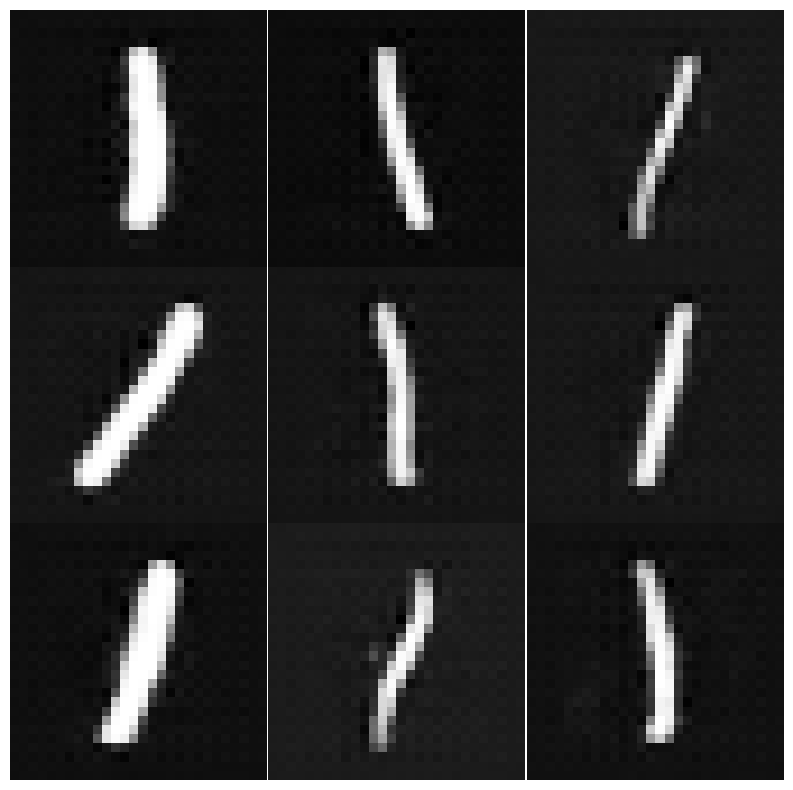

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


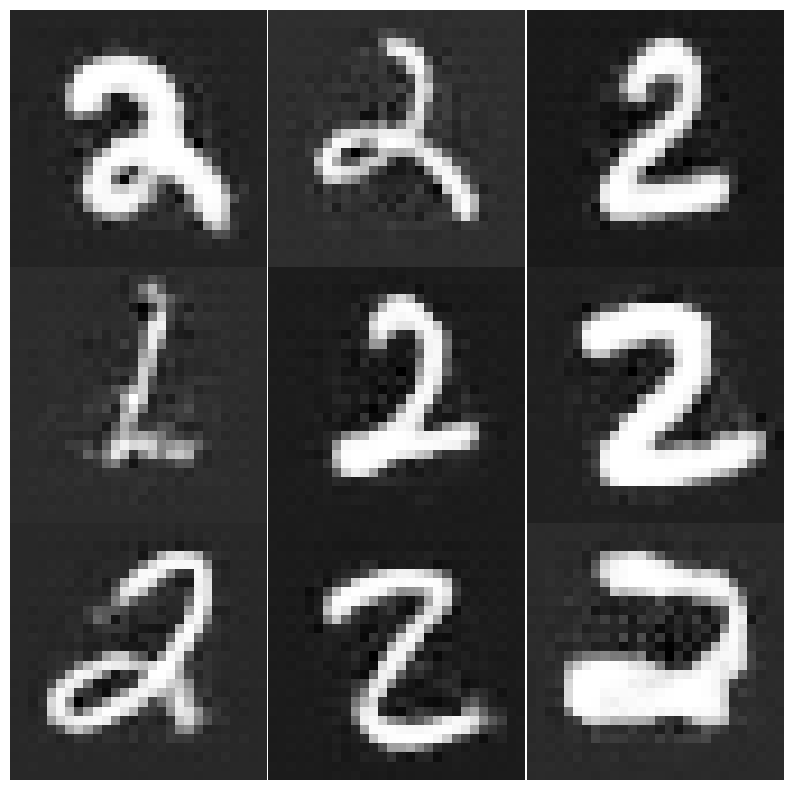

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


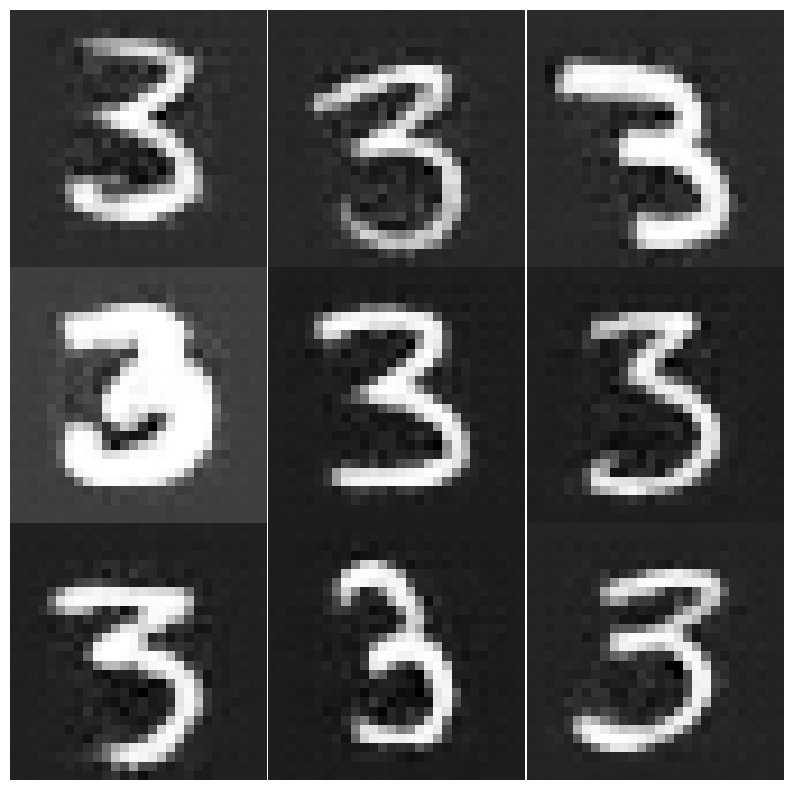

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


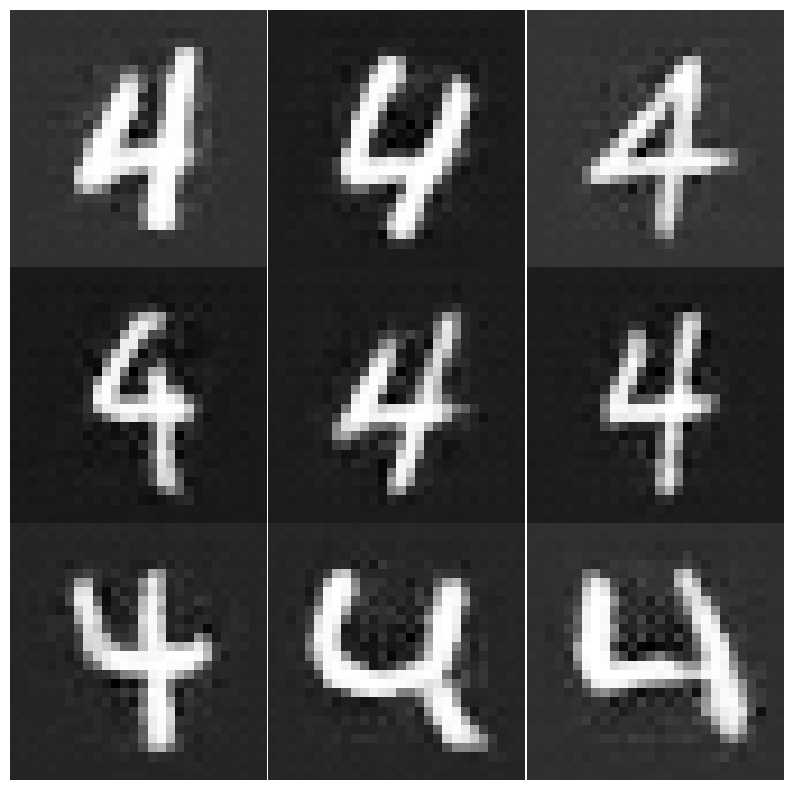

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


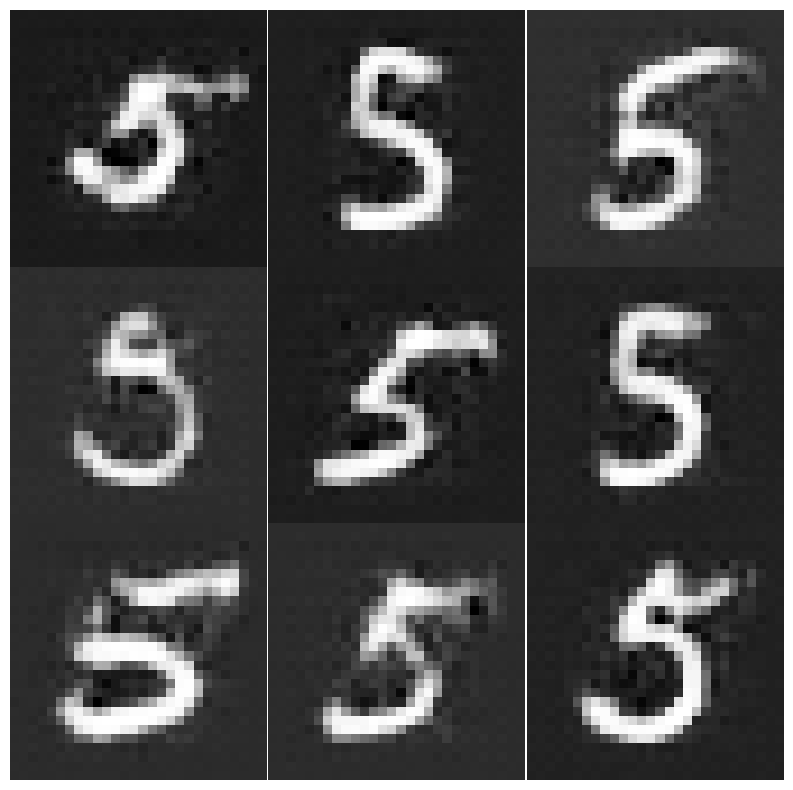

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


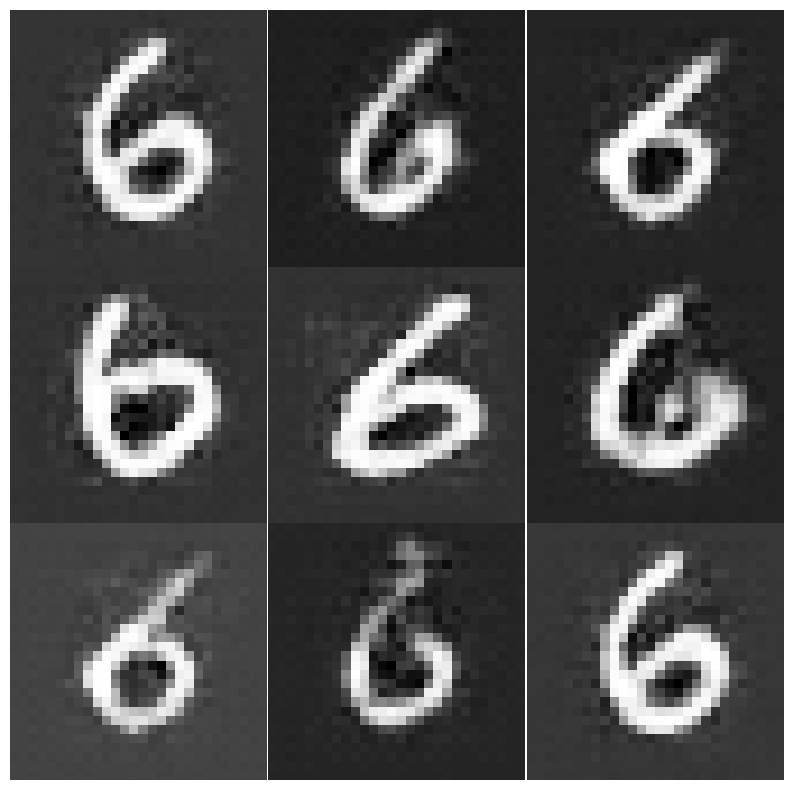

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


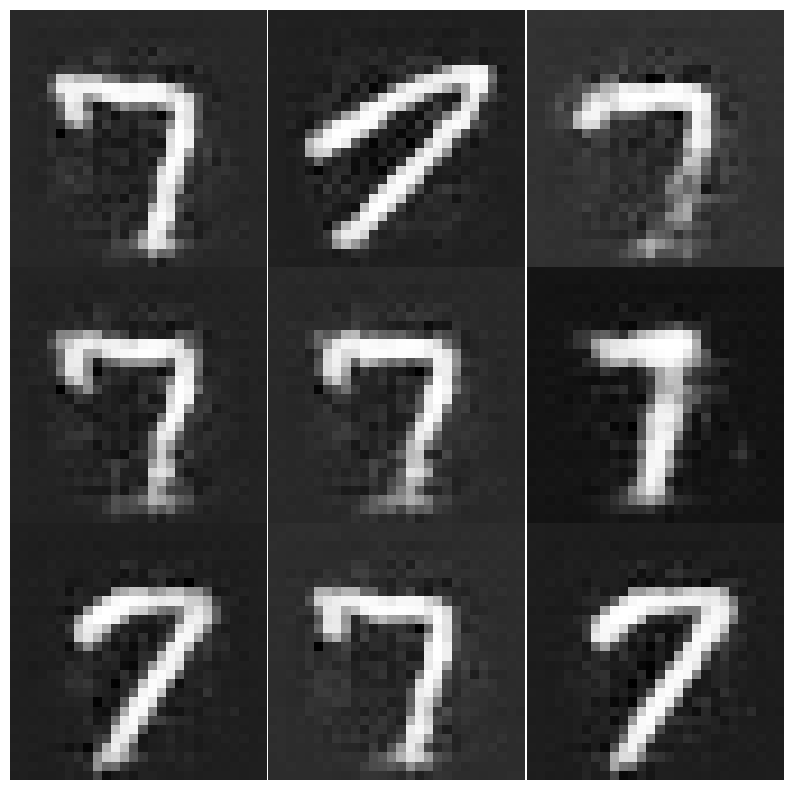

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


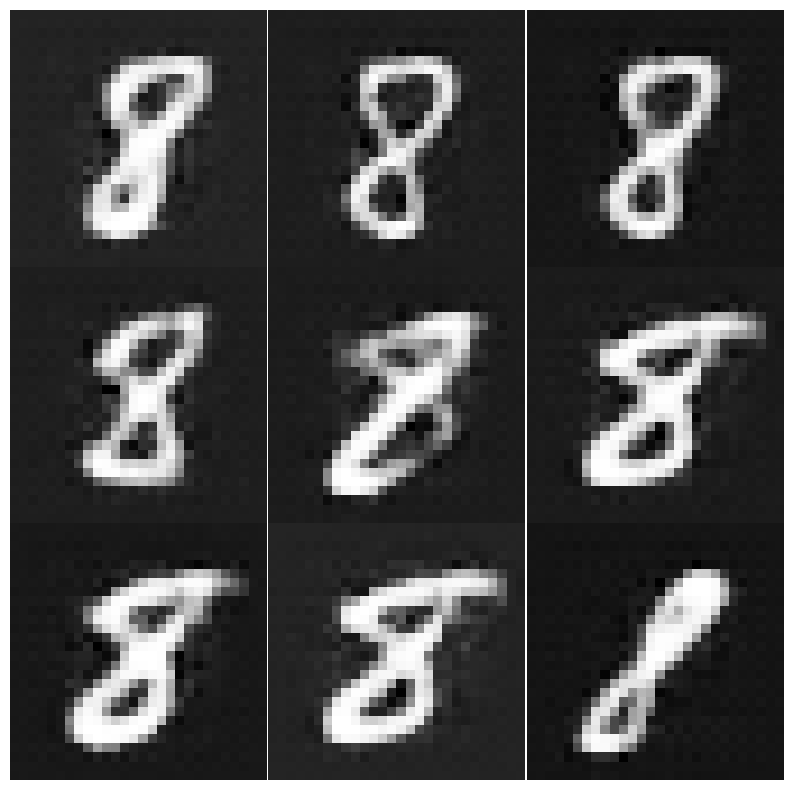

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


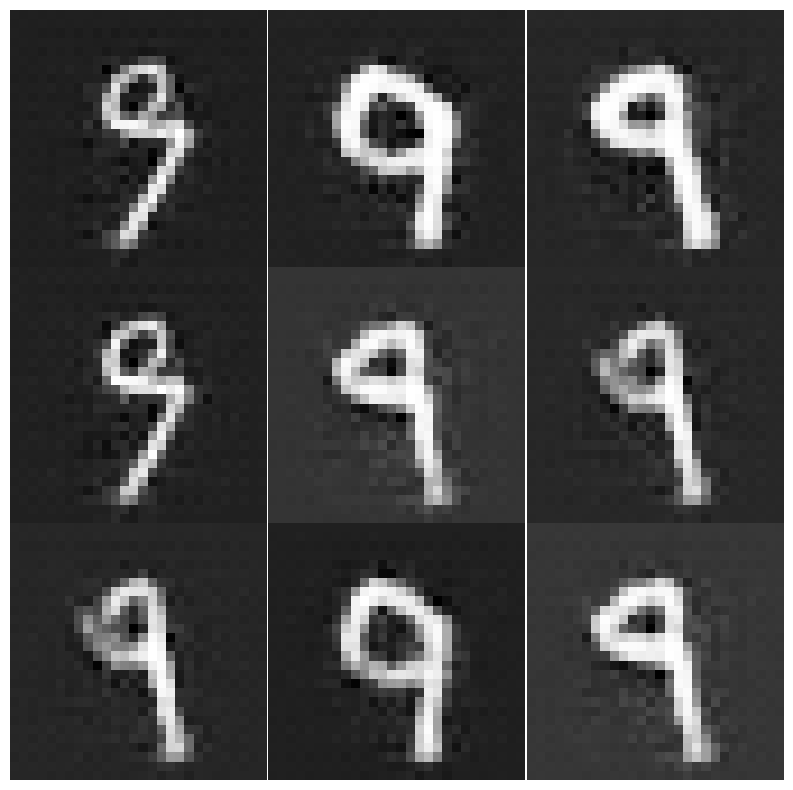

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.10
#Dataset = 1
------ Plot Balanced Imgs ------


------------------------------
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.291191
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.253474
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.187455
Train Epoch: 1 [4000/30000 (13%)]	Loss: 1.977232
Train Epoch: 1 [5000/30000 (17%)]	Loss: 1.508223
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.652193
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.341862
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.377139
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.309798
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.223958
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.075603
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.069952
Train Epoch: 1 [13000/30000 (43%)]	Loss: 0.077496
Train Epoch: 1 [14000/30000 (47%)]	Loss: 0.244278
Train Epoch: 1 [15000/30000 (50%)]	Loss: 0.107600
Train Epoch: 1 [16000/30

Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 0: MSE: 0.4013, Contrastive: 2.3852, Combined: 1.3932


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]


Epoch 1: MSE: 0.0951, Contrastive: 2.1319, Combined: 1.1135


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]


Epoch 2: MSE: 0.0704, Contrastive: 2.1505, Combined: 1.1104


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 3: MSE: 0.0511, Contrastive: 1.6536, Combined: 0.8523


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]


Epoch 4: MSE: 0.0407, Contrastive: 1.6006, Combined: 0.8206


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 5: MSE: 0.0321, Contrastive: 1.3735, Combined: 0.7028


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch 6: MSE: 0.0263, Contrastive: 1.2672, Combined: 0.6468


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 7: MSE: 0.0222, Contrastive: 1.1711, Combined: 0.5967


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]


Epoch 8: MSE: 0.0196, Contrastive: 1.0654, Combined: 0.5425


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]


Epoch 9: MSE: 0.0177, Contrastive: 1.0233, Combined: 0.5205


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch 10: MSE: 0.0161, Contrastive: 1.0012, Combined: 0.5086


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.76it/s]


Epoch 11: MSE: 0.0148, Contrastive: 0.9158, Combined: 0.4653


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.99it/s]


Epoch 12: MSE: 0.0146, Contrastive: 0.9607, Combined: 0.4876


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]


Epoch 13: MSE: 0.0139, Contrastive: 0.8712, Combined: 0.4425


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 14: MSE: 0.0132, Contrastive: 0.8975, Combined: 0.4554


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 15: MSE: 0.0130, Contrastive: 0.8936, Combined: 0.4533


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]


Epoch 16: MSE: 0.0122, Contrastive: 0.8852, Combined: 0.4487


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 17: MSE: 0.0117, Contrastive: 0.8301, Combined: 0.4209


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]


Epoch 18: MSE: 0.0115, Contrastive: 0.8149, Combined: 0.4132


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.72it/s]


Epoch 19: MSE: 0.0111, Contrastive: 0.8420, Combined: 0.4266


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.61it/s]


Epoch 20: MSE: 0.0109, Contrastive: 0.8402, Combined: 0.4255


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]


Epoch 21: MSE: 0.0105, Contrastive: 0.8244, Combined: 0.4175


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch 22: MSE: 0.0098, Contrastive: 0.8331, Combined: 0.4215


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 23: MSE: 0.0097, Contrastive: 0.8201, Combined: 0.4149


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 24: MSE: 0.0101, Contrastive: 0.7990, Combined: 0.4046


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 25: MSE: 0.0095, Contrastive: 0.7924, Combined: 0.4009


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 26: MSE: 0.0094, Contrastive: 0.7684, Combined: 0.3889


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 27: MSE: 0.0089, Contrastive: 0.7857, Combined: 0.3973


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 28: MSE: 0.0090, Contrastive: 0.8307, Combined: 0.4198


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 29: MSE: 0.0085, Contrastive: 0.7643, Combined: 0.3864


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 30: MSE: 0.0082, Contrastive: 0.7701, Combined: 0.3892


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch 31: MSE: 0.0083, Contrastive: 0.7593, Combined: 0.3838


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]


Epoch 32: MSE: 0.0082, Contrastive: 0.7662, Combined: 0.3872


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 33: MSE: 0.0083, Contrastive: 0.7487, Combined: 0.3785


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 34: MSE: 0.0082, Contrastive: 0.7338, Combined: 0.3710


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 35: MSE: 0.0078, Contrastive: 0.7238, Combined: 0.3658


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 36: MSE: 0.0078, Contrastive: 0.7181, Combined: 0.3629


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 37: MSE: 0.0077, Contrastive: 0.7119, Combined: 0.3598


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 38: MSE: 0.0077, Contrastive: 0.6914, Combined: 0.3496


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.04it/s]


Epoch 39: MSE: 0.0076, Contrastive: 0.7028, Combined: 0.3552


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 40: MSE: 0.0073, Contrastive: 0.6930, Combined: 0.3502


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 41: MSE: 0.0073, Contrastive: 0.6773, Combined: 0.3423


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]


Epoch 42: MSE: 0.0073, Contrastive: 0.7037, Combined: 0.3555


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 43: MSE: 0.0072, Contrastive: 0.6777, Combined: 0.3424


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 44: MSE: 0.0070, Contrastive: 0.6775, Combined: 0.3423


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 45: MSE: 0.0070, Contrastive: 0.6747, Combined: 0.3408


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 46: MSE: 0.0068, Contrastive: 0.6725, Combined: 0.3397


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]


Epoch 47: MSE: 0.0069, Contrastive: 0.6718, Combined: 0.3393


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.02it/s]


Epoch 48: MSE: 0.0069, Contrastive: 0.6784, Combined: 0.3427


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]


Epoch 49: MSE: 0.0069, Contrastive: 0.6586, Combined: 0.3327


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]


Epoch 50: MSE: 0.0067, Contrastive: 0.6517, Combined: 0.3292


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 51: MSE: 0.0065, Contrastive: 0.6440, Combined: 0.3253


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.02it/s]


Epoch 52: MSE: 0.0065, Contrastive: 0.6432, Combined: 0.3248


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 53: MSE: 0.0066, Contrastive: 0.6326, Combined: 0.3196


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 54: MSE: 0.0063, Contrastive: 0.6226, Combined: 0.3145


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 55: MSE: 0.0063, Contrastive: 0.6292, Combined: 0.3177


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.01it/s]


Epoch 56: MSE: 0.0062, Contrastive: 0.6301, Combined: 0.3181


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 57: MSE: 0.0062, Contrastive: 0.6201, Combined: 0.3132


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 58: MSE: 0.0062, Contrastive: 0.6135, Combined: 0.3098


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.01it/s]


Epoch 59: MSE: 0.0064, Contrastive: 0.6165, Combined: 0.3114


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 60: MSE: 0.0059, Contrastive: 0.6089, Combined: 0.3074


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.02it/s]


Epoch 61: MSE: 0.0060, Contrastive: 0.6029, Combined: 0.3045


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 62: MSE: 0.0062, Contrastive: 0.6091, Combined: 0.3077


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 63: MSE: 0.0059, Contrastive: 0.5807, Combined: 0.2933


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 64: MSE: 0.0059, Contrastive: 0.5748, Combined: 0.2904


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 65: MSE: 0.0059, Contrastive: 0.5918, Combined: 0.2988


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 66: MSE: 0.0058, Contrastive: 0.5965, Combined: 0.3011


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 67: MSE: 0.0059, Contrastive: 0.5894, Combined: 0.2976


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.16it/s]


Epoch 68: MSE: 0.0058, Contrastive: 0.5841, Combined: 0.2950


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.25it/s]


Epoch 69: MSE: 0.0056, Contrastive: 0.5708, Combined: 0.2882


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 70: MSE: 0.0055, Contrastive: 0.5641, Combined: 0.2848


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]


Epoch 71: MSE: 0.0056, Contrastive: 0.5697, Combined: 0.2877


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]


Epoch 72: MSE: 0.0056, Contrastive: 0.5562, Combined: 0.2809


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 73: MSE: 0.0057, Contrastive: 0.5431, Combined: 0.2744


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.83it/s]


Epoch 74: MSE: 0.0056, Contrastive: 0.5436, Combined: 0.2746


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]


Epoch 75: MSE: 0.0057, Contrastive: 0.5434, Combined: 0.2745


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.77it/s]


Epoch 76: MSE: 0.0053, Contrastive: 0.5387, Combined: 0.2720


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 77: MSE: 0.0053, Contrastive: 0.5456, Combined: 0.2754


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 78: MSE: 0.0054, Contrastive: 0.5415, Combined: 0.2735


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 79: MSE: 0.0052, Contrastive: 0.5444, Combined: 0.2748


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 80: MSE: 0.0051, Contrastive: 0.5340, Combined: 0.2696


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.01it/s]


Epoch 81: MSE: 0.0053, Contrastive: 0.5269, Combined: 0.2661


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


Epoch 82: MSE: 0.0052, Contrastive: 0.5258, Combined: 0.2655


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 83: MSE: 0.0049, Contrastive: 0.5227, Combined: 0.2638


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


Epoch 84: MSE: 0.0050, Contrastive: 0.5143, Combined: 0.2596


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 85: MSE: 0.0050, Contrastive: 0.5142, Combined: 0.2596


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.18it/s]


Epoch 86: MSE: 0.0050, Contrastive: 0.5115, Combined: 0.2583


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 87: MSE: 0.0051, Contrastive: 0.5094, Combined: 0.2572


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 88: MSE: 0.0052, Contrastive: 0.5076, Combined: 0.2564


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 89: MSE: 0.0051, Contrastive: 0.4995, Combined: 0.2523


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 90: MSE: 0.0052, Contrastive: 0.4989, Combined: 0.2520


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 91: MSE: 0.0050, Contrastive: 0.5053, Combined: 0.2552


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.79it/s]


Epoch 92: MSE: 0.0048, Contrastive: 0.4928, Combined: 0.2488


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 93: MSE: 0.0050, Contrastive: 0.4922, Combined: 0.2486


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]


Epoch 94: MSE: 0.0047, Contrastive: 0.4916, Combined: 0.2481


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 95: MSE: 0.0049, Contrastive: 0.4891, Combined: 0.2470


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.86it/s]


Epoch 96: MSE: 0.0051, Contrastive: 0.4892, Combined: 0.2471


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.84it/s]


Epoch 97: MSE: 0.0049, Contrastive: 0.4819, Combined: 0.2434


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 98: MSE: 0.0048, Contrastive: 0.4853, Combined: 0.2451


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 99: MSE: 0.0048, Contrastive: 0.4784, Combined: 0.2416


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.37it/s]


Epoch 100: MSE: 0.0046, Contrastive: 0.4748, Combined: 0.2397


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 101: MSE: 0.0047, Contrastive: 0.4670, Combined: 0.2358


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.05it/s]


Epoch 102: MSE: 0.0047, Contrastive: 0.4702, Combined: 0.2374


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 103: MSE: 0.0046, Contrastive: 0.4751, Combined: 0.2399


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]


Epoch 104: MSE: 0.0047, Contrastive: 0.4719, Combined: 0.2383


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]


Epoch 105: MSE: 0.0046, Contrastive: 0.4665, Combined: 0.2355


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 106: MSE: 0.0046, Contrastive: 0.4656, Combined: 0.2351


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 107: MSE: 0.0044, Contrastive: 0.4618, Combined: 0.2331


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 108: MSE: 0.0045, Contrastive: 0.4593, Combined: 0.2319


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.16it/s]


Epoch 109: MSE: 0.0045, Contrastive: 0.4610, Combined: 0.2327


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 110: MSE: 0.0046, Contrastive: 0.4548, Combined: 0.2297


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.24it/s]


Epoch 111: MSE: 0.0045, Contrastive: 0.4542, Combined: 0.2294


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 112: MSE: 0.0046, Contrastive: 0.4503, Combined: 0.2275


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 113: MSE: 0.0044, Contrastive: 0.4526, Combined: 0.2285


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.02it/s]


Epoch 114: MSE: 0.0044, Contrastive: 0.4497, Combined: 0.2271


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 115: MSE: 0.0043, Contrastive: 0.4436, Combined: 0.2240


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


Epoch 116: MSE: 0.0044, Contrastive: 0.4472, Combined: 0.2258


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 117: MSE: 0.0048, Contrastive: 0.4422, Combined: 0.2235


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 118: MSE: 0.0044, Contrastive: 0.4426, Combined: 0.2235


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 119: MSE: 0.0044, Contrastive: 0.4434, Combined: 0.2239


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 120: MSE: 0.0043, Contrastive: 0.4329, Combined: 0.2186


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]


Epoch 121: MSE: 0.0042, Contrastive: 0.4377, Combined: 0.2210


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]


Epoch 122: MSE: 0.0043, Contrastive: 0.4352, Combined: 0.2197


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 123: MSE: 0.0044, Contrastive: 0.4327, Combined: 0.2186


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.43it/s]


Epoch 124: MSE: 0.0043, Contrastive: 0.4330, Combined: 0.2187


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 125: MSE: 0.0042, Contrastive: 0.4226, Combined: 0.2134


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.02it/s]


Epoch 126: MSE: 0.0043, Contrastive: 0.4220, Combined: 0.2131


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 127: MSE: 0.0044, Contrastive: 0.4296, Combined: 0.2170


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]


Epoch 128: MSE: 0.0043, Contrastive: 0.4268, Combined: 0.2156


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 129: MSE: 0.0042, Contrastive: 0.4218, Combined: 0.2130


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 130: MSE: 0.0045, Contrastive: 0.4213, Combined: 0.2129


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 131: MSE: 0.0040, Contrastive: 0.4167, Combined: 0.2104


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.39it/s]


Epoch 132: MSE: 0.0043, Contrastive: 0.4189, Combined: 0.2116


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 133: MSE: 0.0042, Contrastive: 0.4196, Combined: 0.2119


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


Epoch 134: MSE: 0.0040, Contrastive: 0.4157, Combined: 0.2098


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]


Epoch 135: MSE: 0.0040, Contrastive: 0.4119, Combined: 0.2080


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 136: MSE: 0.0040, Contrastive: 0.4118, Combined: 0.2079


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 137: MSE: 0.0041, Contrastive: 0.4109, Combined: 0.2075


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.05it/s]


Epoch 138: MSE: 0.0039, Contrastive: 0.4155, Combined: 0.2097


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.24it/s]


Epoch 139: MSE: 0.0041, Contrastive: 0.4117, Combined: 0.2079


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 140: MSE: 0.0041, Contrastive: 0.4192, Combined: 0.2116


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 141: MSE: 0.0041, Contrastive: 0.4073, Combined: 0.2057


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 142: MSE: 0.0041, Contrastive: 0.4093, Combined: 0.2067


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.25it/s]


Epoch 143: MSE: 0.0039, Contrastive: 0.4088, Combined: 0.2064


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 144: MSE: 0.0040, Contrastive: 0.4069, Combined: 0.2054


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 145: MSE: 0.0039, Contrastive: 0.4006, Combined: 0.2022


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 146: MSE: 0.0040, Contrastive: 0.3989, Combined: 0.2014


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]


Epoch 147: MSE: 0.0039, Contrastive: 0.3991, Combined: 0.2015


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.39it/s]


Epoch 148: MSE: 0.0040, Contrastive: 0.4008, Combined: 0.2024


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.25it/s]


Epoch 149: MSE: 0.0041, Contrastive: 0.3945, Combined: 0.1993


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 150: MSE: 0.0039, Contrastive: 0.3950, Combined: 0.1995


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 151: MSE: 0.0039, Contrastive: 0.3959, Combined: 0.1999


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 152: MSE: 0.0038, Contrastive: 0.3968, Combined: 0.2003


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 153: MSE: 0.0038, Contrastive: 0.3954, Combined: 0.1996


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 154: MSE: 0.0038, Contrastive: 0.3906, Combined: 0.1972


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 155: MSE: 0.0038, Contrastive: 0.3872, Combined: 0.1955


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 156: MSE: 0.0039, Contrastive: 0.3937, Combined: 0.1988


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 157: MSE: 0.0040, Contrastive: 0.3916, Combined: 0.1978


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 158: MSE: 0.0036, Contrastive: 0.3868, Combined: 0.1952


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.25it/s]


Epoch 159: MSE: 0.0036, Contrastive: 0.3819, Combined: 0.1927


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 160: MSE: 0.0037, Contrastive: 0.3871, Combined: 0.1954


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


Epoch 161: MSE: 0.0037, Contrastive: 0.3856, Combined: 0.1947


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 162: MSE: 0.0037, Contrastive: 0.3903, Combined: 0.1970


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 163: MSE: 0.0036, Contrastive: 0.3811, Combined: 0.1923


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 164: MSE: 0.0036, Contrastive: 0.3836, Combined: 0.1936


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 165: MSE: 0.0036, Contrastive: 0.3781, Combined: 0.1908


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.18it/s]


Epoch 166: MSE: 0.0036, Contrastive: 0.3801, Combined: 0.1918


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]


Epoch 167: MSE: 0.0036, Contrastive: 0.3790, Combined: 0.1913


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 168: MSE: 0.0036, Contrastive: 0.3808, Combined: 0.1922


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 169: MSE: 0.0036, Contrastive: 0.3797, Combined: 0.1917


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 170: MSE: 0.0036, Contrastive: 0.3783, Combined: 0.1909


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 171: MSE: 0.0036, Contrastive: 0.3731, Combined: 0.1884


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 172: MSE: 0.0037, Contrastive: 0.3735, Combined: 0.1886


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 173: MSE: 0.0036, Contrastive: 0.3681, Combined: 0.1858


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 174: MSE: 0.0035, Contrastive: 0.3711, Combined: 0.1873


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]


Epoch 175: MSE: 0.0035, Contrastive: 0.3704, Combined: 0.1869


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 176: MSE: 0.0035, Contrastive: 0.3680, Combined: 0.1857


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 177: MSE: 0.0034, Contrastive: 0.3718, Combined: 0.1876


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


Epoch 178: MSE: 0.0036, Contrastive: 0.3687, Combined: 0.1861


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 179: MSE: 0.0036, Contrastive: 0.3687, Combined: 0.1862


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 180: MSE: 0.0035, Contrastive: 0.3726, Combined: 0.1881


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 181: MSE: 0.0033, Contrastive: 0.3612, Combined: 0.1822


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


Epoch 182: MSE: 0.0034, Contrastive: 0.3636, Combined: 0.1835


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]


Epoch 183: MSE: 0.0033, Contrastive: 0.3594, Combined: 0.1814


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.35it/s]


Epoch 184: MSE: 0.0034, Contrastive: 0.3674, Combined: 0.1854


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 185: MSE: 0.0032, Contrastive: 0.3629, Combined: 0.1831


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 186: MSE: 0.0034, Contrastive: 0.3638, Combined: 0.1836


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.05it/s]


Epoch 187: MSE: 0.0033, Contrastive: 0.3655, Combined: 0.1844


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.04it/s]


Epoch 188: MSE: 0.0034, Contrastive: 0.3671, Combined: 0.1853


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.02it/s]


Epoch 189: MSE: 0.0033, Contrastive: 0.3626, Combined: 0.1830


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 190: MSE: 0.0033, Contrastive: 0.3619, Combined: 0.1826


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


Epoch 191: MSE: 0.0031, Contrastive: 0.3593, Combined: 0.1812


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


Epoch 192: MSE: 0.0033, Contrastive: 0.3606, Combined: 0.1820


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 193: MSE: 0.0032, Contrastive: 0.3639, Combined: 0.1836


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.19it/s]


Epoch 194: MSE: 0.0034, Contrastive: 0.3604, Combined: 0.1819


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


Epoch 195: MSE: 0.0032, Contrastive: 0.3597, Combined: 0.1814


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]


Epoch 196: MSE: 0.0033, Contrastive: 0.3632, Combined: 0.1833


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 197: MSE: 0.0033, Contrastive: 0.3580, Combined: 0.1807


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.24it/s]


Epoch 198: MSE: 0.0034, Contrastive: 0.3573, Combined: 0.1803


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 199: MSE: 0.0031, Contrastive: 0.3577, Combined: 0.1804
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.35
------ Plot Latent Space ------


------------------------------
0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


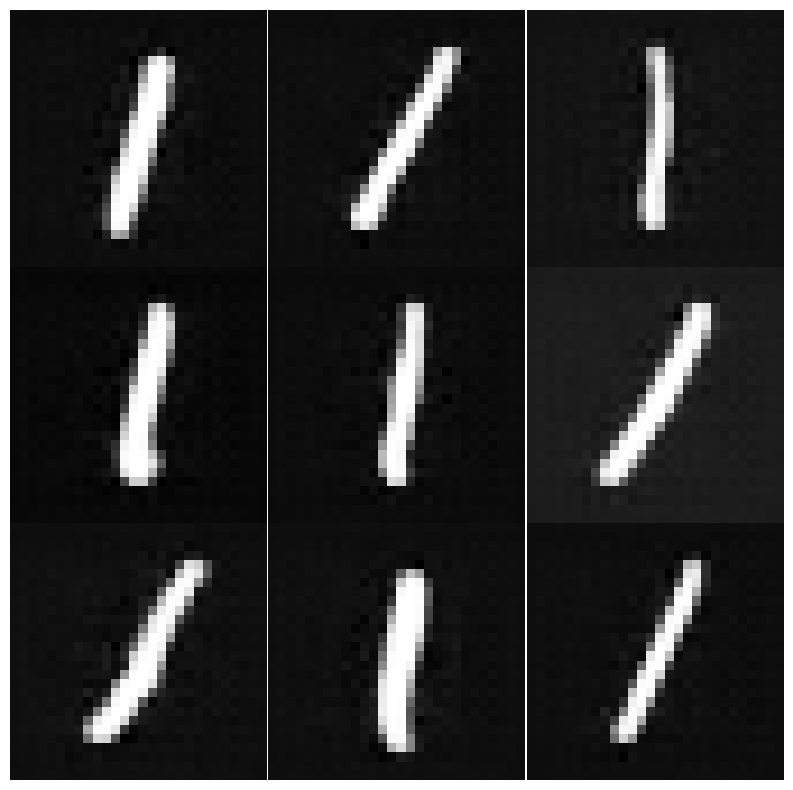

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


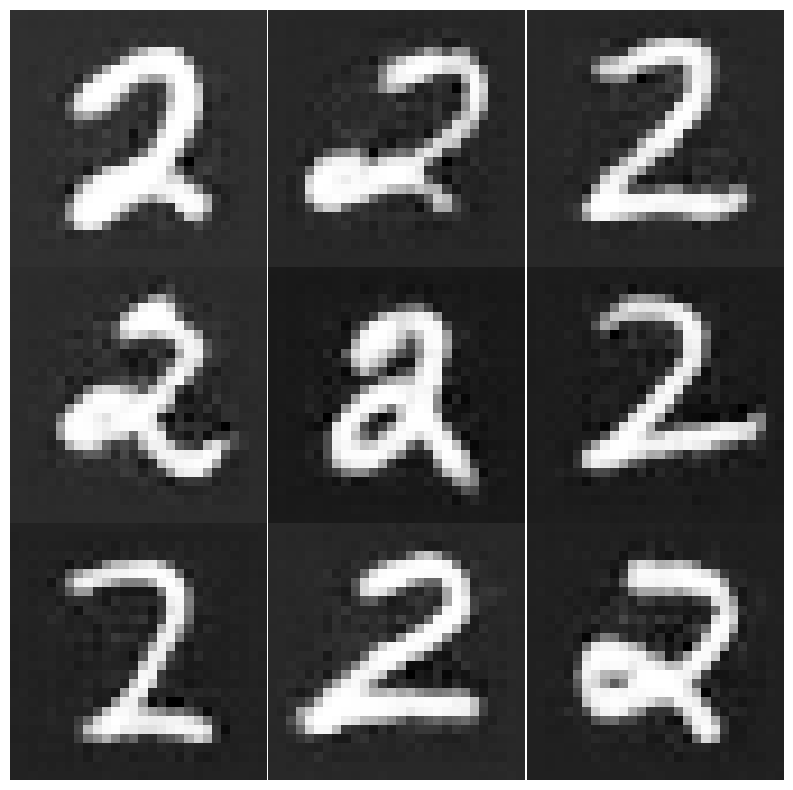

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


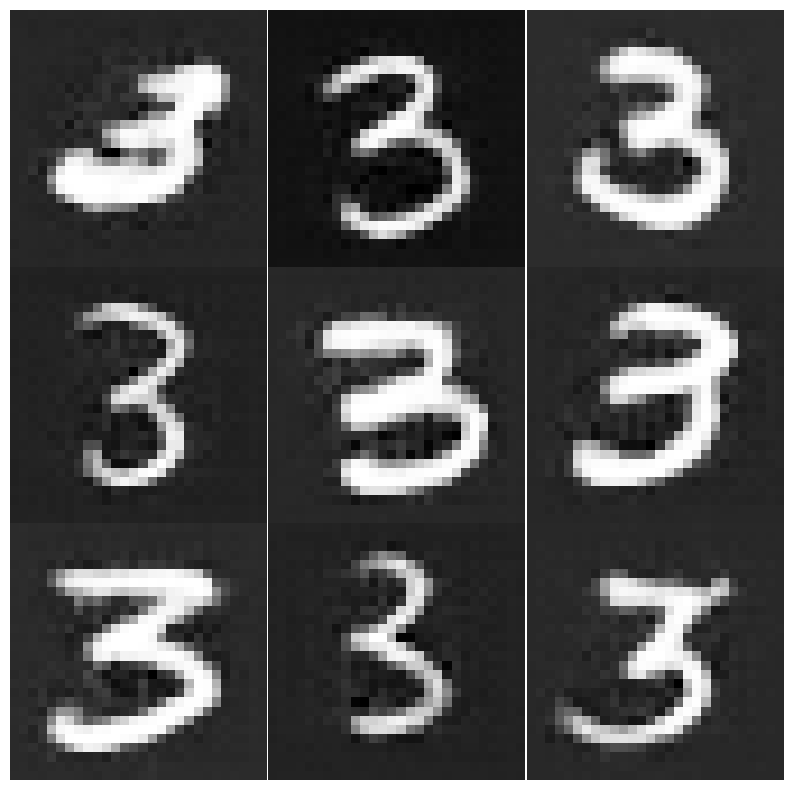

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


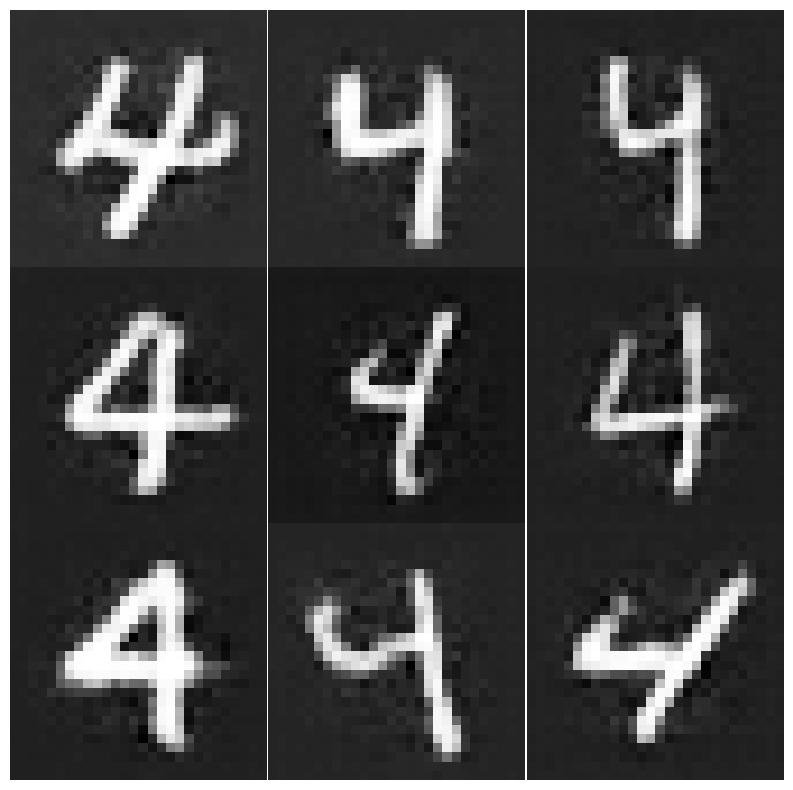

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


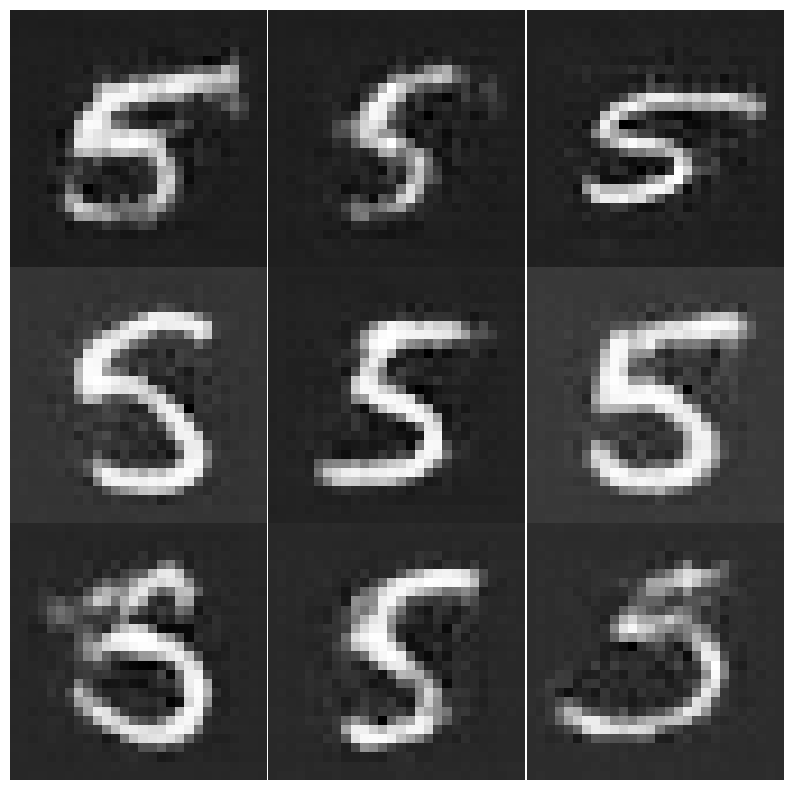

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


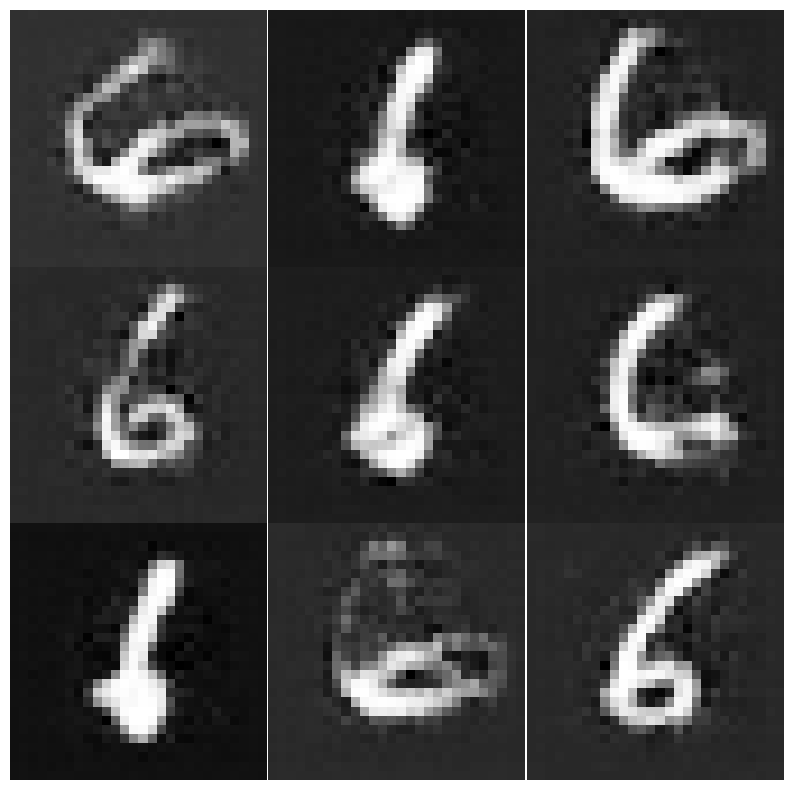

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


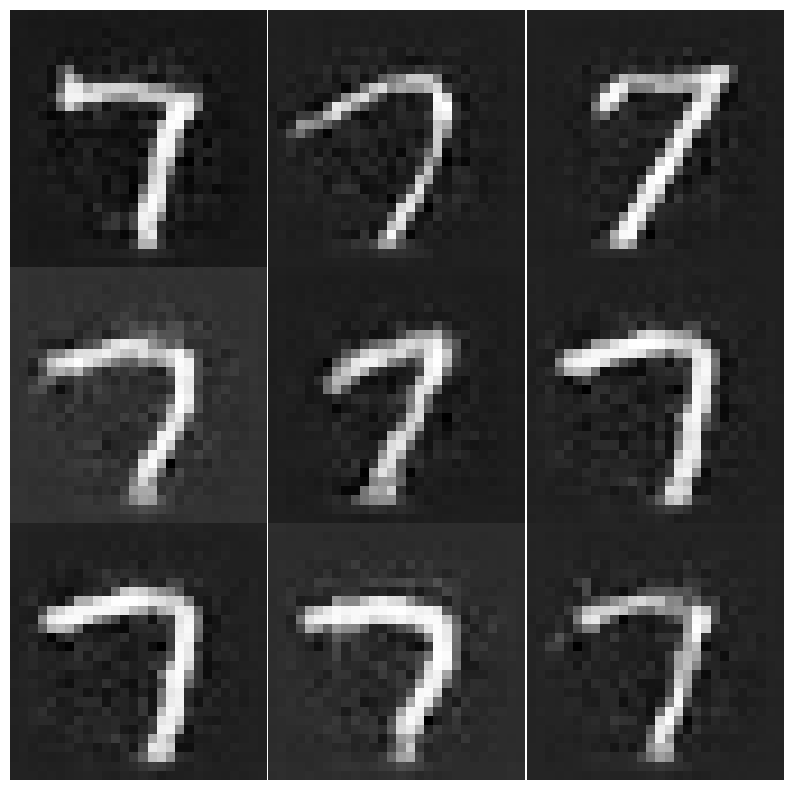

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


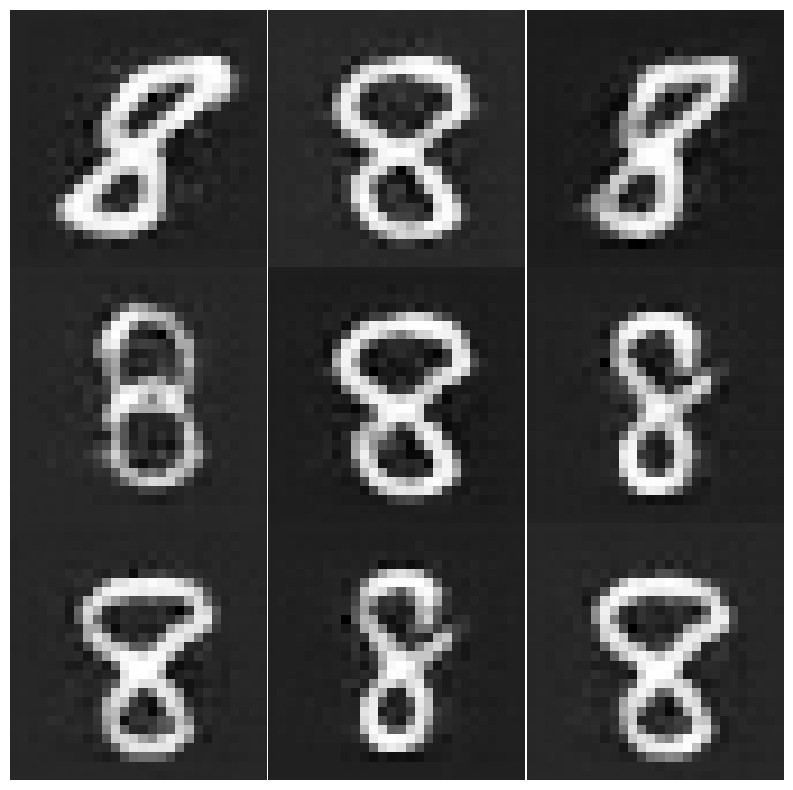

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


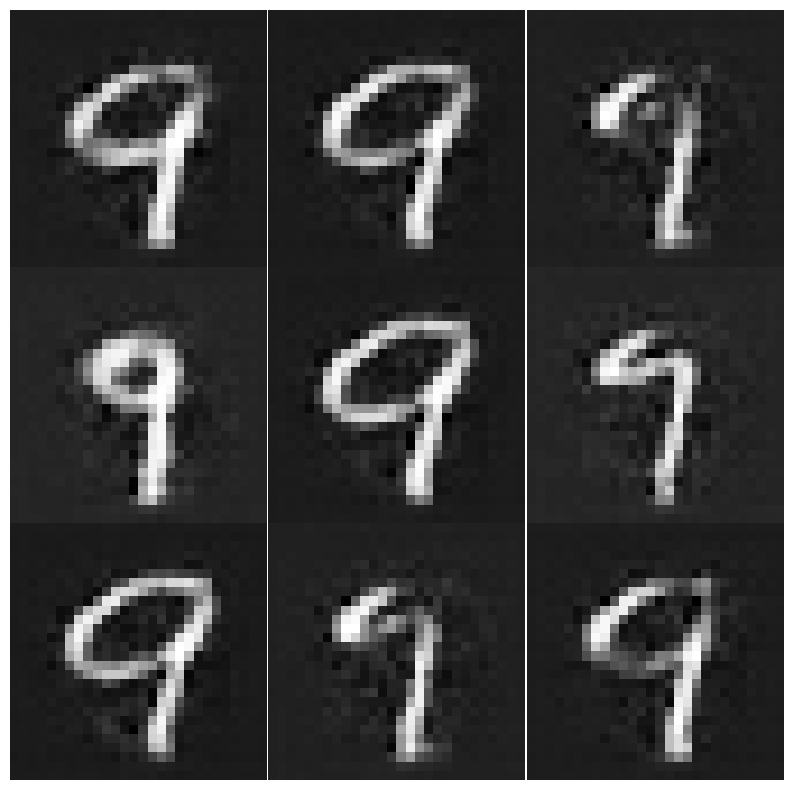

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.10
#Dataset = 1
------ Plot Balanced Imgs ------


------------------------------
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.274801
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.217150
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.066649
Train Epoch: 1 [4000/30000 (13%)]	Loss: 1.564892
Train Epoch: 1 [5000/30000 (17%)]	Loss: 0.824796
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.576338
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.321717
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.183396
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.252524
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.280926
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.290327
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.172203
Train Epoch: 1 [13000/30000 (43%)]	Loss: 0.057101
Train Epoch: 1 [14000/30000 (47%)]	Loss: 0.083854
Train Epoch: 1 [15000/30000 (50%)]	Loss: 0.065214
Train Epoch: 1 [16000/30

Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 0: MSE: 0.3735, Contrastive: 2.4088, Combined: 1.3911


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.73it/s]


Epoch 1: MSE: 0.1249, Contrastive: 2.0655, Combined: 1.0952


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch 2: MSE: 0.0730, Contrastive: 2.0809, Combined: 1.0769


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.71it/s]


Epoch 3: MSE: 0.0590, Contrastive: 1.8357, Combined: 0.9474


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.66it/s]


Epoch 4: MSE: 0.0420, Contrastive: 1.6127, Combined: 0.8274


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]


Epoch 5: MSE: 0.0325, Contrastive: 1.5568, Combined: 0.7947


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.86it/s]


Epoch 6: MSE: 0.0263, Contrastive: 1.4359, Combined: 0.7311


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 7: MSE: 0.0229, Contrastive: 1.2637, Combined: 0.6433


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 8: MSE: 0.0200, Contrastive: 1.2036, Combined: 0.6118


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.76it/s]


Epoch 9: MSE: 0.0182, Contrastive: 1.1594, Combined: 0.5888


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch 10: MSE: 0.0160, Contrastive: 1.0674, Combined: 0.5417


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]


Epoch 11: MSE: 0.0144, Contrastive: 1.0263, Combined: 0.5204


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.47it/s]


Epoch 12: MSE: 0.0140, Contrastive: 1.0124, Combined: 0.5132


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.54it/s]


Epoch 13: MSE: 0.0134, Contrastive: 1.0036, Combined: 0.5085


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.66it/s]


Epoch 14: MSE: 0.0129, Contrastive: 1.0592, Combined: 0.5360


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.04it/s]


Epoch 15: MSE: 0.0125, Contrastive: 1.0302, Combined: 0.5213


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 16: MSE: 0.0119, Contrastive: 1.0371, Combined: 0.5245


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.04it/s]


Epoch 17: MSE: 0.0116, Contrastive: 1.0297, Combined: 0.5207


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 18: MSE: 0.0108, Contrastive: 0.9641, Combined: 0.4874


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 19: MSE: 0.0109, Contrastive: 0.9750, Combined: 0.4930


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.01it/s]


Epoch 20: MSE: 0.0103, Contrastive: 0.9446, Combined: 0.4774


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]


Epoch 21: MSE: 0.0101, Contrastive: 0.8857, Combined: 0.4479


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 22: MSE: 0.0098, Contrastive: 0.8863, Combined: 0.4481


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 23: MSE: 0.0097, Contrastive: 0.8630, Combined: 0.4364


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 24: MSE: 0.0095, Contrastive: 0.8401, Combined: 0.4248


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 25: MSE: 0.0094, Contrastive: 0.8351, Combined: 0.4222


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.99it/s]


Epoch 26: MSE: 0.0093, Contrastive: 0.8160, Combined: 0.4126


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 27: MSE: 0.0088, Contrastive: 0.8331, Combined: 0.4210


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 28: MSE: 0.0088, Contrastive: 0.8190, Combined: 0.4139


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 29: MSE: 0.0086, Contrastive: 0.8095, Combined: 0.4090


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 30: MSE: 0.0086, Contrastive: 0.8146, Combined: 0.4116


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 31: MSE: 0.0085, Contrastive: 0.8433, Combined: 0.4259


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 32: MSE: 0.0082, Contrastive: 0.7967, Combined: 0.4025


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.93it/s]


Epoch 33: MSE: 0.0080, Contrastive: 0.8014, Combined: 0.4047


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 34: MSE: 0.0081, Contrastive: 0.7858, Combined: 0.3969


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 35: MSE: 0.0078, Contrastive: 0.7897, Combined: 0.3988


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 36: MSE: 0.0077, Contrastive: 0.7854, Combined: 0.3966


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 37: MSE: 0.0076, Contrastive: 0.7729, Combined: 0.3903


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]


Epoch 38: MSE: 0.0075, Contrastive: 0.7694, Combined: 0.3885


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 39: MSE: 0.0076, Contrastive: 0.7685, Combined: 0.3880


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]


Epoch 40: MSE: 0.0073, Contrastive: 0.7611, Combined: 0.3842


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 41: MSE: 0.0071, Contrastive: 0.7478, Combined: 0.3775


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 42: MSE: 0.0070, Contrastive: 0.7296, Combined: 0.3683


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 43: MSE: 0.0073, Contrastive: 0.7266, Combined: 0.3670


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 44: MSE: 0.0070, Contrastive: 0.7270, Combined: 0.3670


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.93it/s]


Epoch 45: MSE: 0.0067, Contrastive: 0.7243, Combined: 0.3655


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]


Epoch 46: MSE: 0.0067, Contrastive: 0.7263, Combined: 0.3665


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]


Epoch 47: MSE: 0.0067, Contrastive: 0.7157, Combined: 0.3612


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.86it/s]


Epoch 48: MSE: 0.0068, Contrastive: 0.7126, Combined: 0.3597


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.81it/s]


Epoch 49: MSE: 0.0071, Contrastive: 0.6965, Combined: 0.3518


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 50: MSE: 0.0067, Contrastive: 0.6913, Combined: 0.3490


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 51: MSE: 0.0067, Contrastive: 0.6911, Combined: 0.3489


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 52: MSE: 0.0066, Contrastive: 0.6898, Combined: 0.3482


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.84it/s]


Epoch 53: MSE: 0.0065, Contrastive: 0.6760, Combined: 0.3413


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 54: MSE: 0.0062, Contrastive: 0.6811, Combined: 0.3437


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.93it/s]


Epoch 55: MSE: 0.0063, Contrastive: 0.6835, Combined: 0.3449


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]


Epoch 56: MSE: 0.0062, Contrastive: 0.6545, Combined: 0.3303


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 57: MSE: 0.0060, Contrastive: 0.6444, Combined: 0.3252


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]


Epoch 58: MSE: 0.0062, Contrastive: 0.6397, Combined: 0.3229


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.56it/s]


Epoch 59: MSE: 0.0062, Contrastive: 0.6335, Combined: 0.3199


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.61it/s]


Epoch 60: MSE: 0.0060, Contrastive: 0.6399, Combined: 0.3230


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]


Epoch 61: MSE: 0.0059, Contrastive: 0.6296, Combined: 0.3178


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 62: MSE: 0.0062, Contrastive: 0.6383, Combined: 0.3222


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.60it/s]


Epoch 63: MSE: 0.0059, Contrastive: 0.6191, Combined: 0.3125


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.72it/s]


Epoch 64: MSE: 0.0061, Contrastive: 0.6170, Combined: 0.3115


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.66it/s]


Epoch 65: MSE: 0.0059, Contrastive: 0.6134, Combined: 0.3097


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.83it/s]


Epoch 66: MSE: 0.0058, Contrastive: 0.5924, Combined: 0.2991


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch 67: MSE: 0.0056, Contrastive: 0.5999, Combined: 0.3027


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch 68: MSE: 0.0057, Contrastive: 0.5941, Combined: 0.2999


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.84it/s]


Epoch 69: MSE: 0.0057, Contrastive: 0.5875, Combined: 0.2966


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 70: MSE: 0.0056, Contrastive: 0.5764, Combined: 0.2910


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 71: MSE: 0.0055, Contrastive: 0.5764, Combined: 0.2910


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch 72: MSE: 0.0059, Contrastive: 0.5804, Combined: 0.2932


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.56it/s]


Epoch 73: MSE: 0.0057, Contrastive: 0.5749, Combined: 0.2903


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.71it/s]


Epoch 74: MSE: 0.0055, Contrastive: 0.5737, Combined: 0.2896


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]


Epoch 75: MSE: 0.0054, Contrastive: 0.5783, Combined: 0.2919


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 76: MSE: 0.0053, Contrastive: 0.5812, Combined: 0.2932


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]


Epoch 77: MSE: 0.0055, Contrastive: 0.5702, Combined: 0.2878


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.83it/s]


Epoch 78: MSE: 0.0053, Contrastive: 0.5632, Combined: 0.2842


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.81it/s]


Epoch 79: MSE: 0.0051, Contrastive: 0.5595, Combined: 0.2823


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 80: MSE: 0.0051, Contrastive: 0.5572, Combined: 0.2811


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.74it/s]


Epoch 81: MSE: 0.0051, Contrastive: 0.5531, Combined: 0.2791


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.74it/s]


Epoch 82: MSE: 0.0052, Contrastive: 0.5458, Combined: 0.2755


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.84it/s]


Epoch 83: MSE: 0.0050, Contrastive: 0.5518, Combined: 0.2784


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 84: MSE: 0.0051, Contrastive: 0.5498, Combined: 0.2775


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]


Epoch 85: MSE: 0.0051, Contrastive: 0.5438, Combined: 0.2744


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch 86: MSE: 0.0052, Contrastive: 0.5377, Combined: 0.2715


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch 87: MSE: 0.0050, Contrastive: 0.5270, Combined: 0.2660


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 88: MSE: 0.0049, Contrastive: 0.5319, Combined: 0.2684


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]


Epoch 89: MSE: 0.0049, Contrastive: 0.5273, Combined: 0.2661


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]


Epoch 90: MSE: 0.0048, Contrastive: 0.5319, Combined: 0.2684


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch 91: MSE: 0.0048, Contrastive: 0.5235, Combined: 0.2642


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 92: MSE: 0.0050, Contrastive: 0.5167, Combined: 0.2608


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]


Epoch 93: MSE: 0.0046, Contrastive: 0.5150, Combined: 0.2598


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]


Epoch 94: MSE: 0.0048, Contrastive: 0.5254, Combined: 0.2651


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]


Epoch 95: MSE: 0.0046, Contrastive: 0.5128, Combined: 0.2587


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 96: MSE: 0.0045, Contrastive: 0.5071, Combined: 0.2558


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 97: MSE: 0.0048, Contrastive: 0.5014, Combined: 0.2531


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.74it/s]


Epoch 98: MSE: 0.0046, Contrastive: 0.4964, Combined: 0.2505


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch 99: MSE: 0.0046, Contrastive: 0.5026, Combined: 0.2536


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.93it/s]


Epoch 100: MSE: 0.0047, Contrastive: 0.4941, Combined: 0.2494


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.78it/s]


Epoch 101: MSE: 0.0044, Contrastive: 0.4869, Combined: 0.2457


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.58it/s]


Epoch 102: MSE: 0.0045, Contrastive: 0.4894, Combined: 0.2469


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]


Epoch 103: MSE: 0.0045, Contrastive: 0.4951, Combined: 0.2498


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch 104: MSE: 0.0043, Contrastive: 0.4841, Combined: 0.2442


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]


Epoch 105: MSE: 0.0045, Contrastive: 0.4801, Combined: 0.2423


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]


Epoch 106: MSE: 0.0044, Contrastive: 0.4774, Combined: 0.2409


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 107: MSE: 0.0047, Contrastive: 0.4748, Combined: 0.2398


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]


Epoch 108: MSE: 0.0045, Contrastive: 0.4812, Combined: 0.2429


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 109: MSE: 0.0045, Contrastive: 0.4719, Combined: 0.2382


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.05it/s]


Epoch 110: MSE: 0.0045, Contrastive: 0.4760, Combined: 0.2402


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 111: MSE: 0.0043, Contrastive: 0.4811, Combined: 0.2427


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]


Epoch 112: MSE: 0.0046, Contrastive: 0.4692, Combined: 0.2369


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.83it/s]


Epoch 113: MSE: 0.0045, Contrastive: 0.4760, Combined: 0.2403


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 114: MSE: 0.0043, Contrastive: 0.4610, Combined: 0.2327


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 115: MSE: 0.0041, Contrastive: 0.4632, Combined: 0.2336


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 116: MSE: 0.0042, Contrastive: 0.4627, Combined: 0.2335


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 117: MSE: 0.0043, Contrastive: 0.4500, Combined: 0.2272


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 118: MSE: 0.0044, Contrastive: 0.4532, Combined: 0.2288


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.82it/s]


Epoch 119: MSE: 0.0042, Contrastive: 0.4513, Combined: 0.2278


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.95it/s]


Epoch 120: MSE: 0.0042, Contrastive: 0.4454, Combined: 0.2248


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 121: MSE: 0.0042, Contrastive: 0.4510, Combined: 0.2276


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.16it/s]


Epoch 122: MSE: 0.0042, Contrastive: 0.4486, Combined: 0.2264


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.84it/s]


Epoch 123: MSE: 0.0042, Contrastive: 0.4419, Combined: 0.2231


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.79it/s]


Epoch 124: MSE: 0.0043, Contrastive: 0.4456, Combined: 0.2249


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


Epoch 125: MSE: 0.0042, Contrastive: 0.4372, Combined: 0.2207


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.81it/s]


Epoch 126: MSE: 0.0041, Contrastive: 0.4330, Combined: 0.2185


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]


Epoch 127: MSE: 0.0039, Contrastive: 0.4348, Combined: 0.2193


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 128: MSE: 0.0041, Contrastive: 0.4314, Combined: 0.2178


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 129: MSE: 0.0042, Contrastive: 0.4347, Combined: 0.2194


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 130: MSE: 0.0040, Contrastive: 0.4286, Combined: 0.2163


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 131: MSE: 0.0039, Contrastive: 0.4314, Combined: 0.2176


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 132: MSE: 0.0041, Contrastive: 0.4270, Combined: 0.2155


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 133: MSE: 0.0040, Contrastive: 0.4265, Combined: 0.2152


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 134: MSE: 0.0039, Contrastive: 0.4241, Combined: 0.2140


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]


Epoch 135: MSE: 0.0039, Contrastive: 0.4271, Combined: 0.2155


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]


Epoch 136: MSE: 0.0043, Contrastive: 0.4304, Combined: 0.2173


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 137: MSE: 0.0040, Contrastive: 0.4229, Combined: 0.2134


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 138: MSE: 0.0039, Contrastive: 0.4206, Combined: 0.2122


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 139: MSE: 0.0039, Contrastive: 0.4196, Combined: 0.2118


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]


Epoch 140: MSE: 0.0037, Contrastive: 0.4222, Combined: 0.2129


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.39it/s]


Epoch 141: MSE: 0.0038, Contrastive: 0.4157, Combined: 0.2098


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 142: MSE: 0.0038, Contrastive: 0.4193, Combined: 0.2116


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]


Epoch 143: MSE: 0.0038, Contrastive: 0.4161, Combined: 0.2099


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 144: MSE: 0.0037, Contrastive: 0.4189, Combined: 0.2113


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 145: MSE: 0.0038, Contrastive: 0.4157, Combined: 0.2097


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]


Epoch 146: MSE: 0.0036, Contrastive: 0.4084, Combined: 0.2060


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]


Epoch 147: MSE: 0.0038, Contrastive: 0.4069, Combined: 0.2054


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch 148: MSE: 0.0037, Contrastive: 0.4096, Combined: 0.2066


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch 149: MSE: 0.0039, Contrastive: 0.4031, Combined: 0.2035


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch 150: MSE: 0.0037, Contrastive: 0.4080, Combined: 0.2059


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.73it/s]


Epoch 151: MSE: 0.0037, Contrastive: 0.4047, Combined: 0.2042


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 152: MSE: 0.0038, Contrastive: 0.4077, Combined: 0.2058


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 153: MSE: 0.0039, Contrastive: 0.4023, Combined: 0.2031


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch 154: MSE: 0.0038, Contrastive: 0.4079, Combined: 0.2059


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]


Epoch 155: MSE: 0.0037, Contrastive: 0.4050, Combined: 0.2043


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.51it/s]


Epoch 156: MSE: 0.0036, Contrastive: 0.4008, Combined: 0.2022


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]


Epoch 157: MSE: 0.0037, Contrastive: 0.3980, Combined: 0.2009


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]


Epoch 158: MSE: 0.0036, Contrastive: 0.3991, Combined: 0.2013


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.77it/s]


Epoch 159: MSE: 0.0036, Contrastive: 0.3951, Combined: 0.1993


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch 160: MSE: 0.0035, Contrastive: 0.3944, Combined: 0.1990


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch 161: MSE: 0.0035, Contrastive: 0.3943, Combined: 0.1989


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]


Epoch 162: MSE: 0.0035, Contrastive: 0.3916, Combined: 0.1976


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch 163: MSE: 0.0034, Contrastive: 0.3916, Combined: 0.1975


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.73it/s]


Epoch 164: MSE: 0.0034, Contrastive: 0.3928, Combined: 0.1981


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.77it/s]


Epoch 165: MSE: 0.0034, Contrastive: 0.3896, Combined: 0.1965


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.72it/s]


Epoch 166: MSE: 0.0036, Contrastive: 0.3947, Combined: 0.1992


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]


Epoch 167: MSE: 0.0034, Contrastive: 0.3880, Combined: 0.1957


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 168: MSE: 0.0034, Contrastive: 0.3926, Combined: 0.1980


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.48it/s]


Epoch 169: MSE: 0.0034, Contrastive: 0.3845, Combined: 0.1940


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.09it/s]


Epoch 170: MSE: 0.0037, Contrastive: 0.3886, Combined: 0.1962


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 171: MSE: 0.0033, Contrastive: 0.3917, Combined: 0.1975


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]


Epoch 172: MSE: 0.0033, Contrastive: 0.3885, Combined: 0.1959


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 173: MSE: 0.0033, Contrastive: 0.3853, Combined: 0.1943


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 174: MSE: 0.0034, Contrastive: 0.3875, Combined: 0.1954


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]


Epoch 175: MSE: 0.0035, Contrastive: 0.3880, Combined: 0.1958


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 176: MSE: 0.0036, Contrastive: 0.3857, Combined: 0.1946


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 177: MSE: 0.0033, Contrastive: 0.3787, Combined: 0.1910


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]


Epoch 178: MSE: 0.0036, Contrastive: 0.3842, Combined: 0.1939


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]


Epoch 179: MSE: 0.0033, Contrastive: 0.3790, Combined: 0.1911


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.99it/s]


Epoch 180: MSE: 0.0032, Contrastive: 0.3786, Combined: 0.1909


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.28it/s]


Epoch 181: MSE: 0.0031, Contrastive: 0.3802, Combined: 0.1916


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 182: MSE: 0.0034, Contrastive: 0.3794, Combined: 0.1914


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]


Epoch 183: MSE: 0.0034, Contrastive: 0.3731, Combined: 0.1882


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.25it/s]


Epoch 184: MSE: 0.0034, Contrastive: 0.3806, Combined: 0.1920


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]


Epoch 185: MSE: 0.0033, Contrastive: 0.3784, Combined: 0.1908


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.15it/s]


Epoch 186: MSE: 0.0031, Contrastive: 0.3749, Combined: 0.1890


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.04it/s]


Epoch 187: MSE: 0.0033, Contrastive: 0.3678, Combined: 0.1856


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 188: MSE: 0.0033, Contrastive: 0.3739, Combined: 0.1886


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]


Epoch 189: MSE: 0.0031, Contrastive: 0.3691, Combined: 0.1861


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 190: MSE: 0.0031, Contrastive: 0.3694, Combined: 0.1862


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 191: MSE: 0.0033, Contrastive: 0.3723, Combined: 0.1878


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 192: MSE: 0.0035, Contrastive: 0.3715, Combined: 0.1875


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 193: MSE: 0.0031, Contrastive: 0.3701, Combined: 0.1866


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.22it/s]


Epoch 194: MSE: 0.0033, Contrastive: 0.3723, Combined: 0.1878


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]


Epoch 195: MSE: 0.0030, Contrastive: 0.3682, Combined: 0.1856


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.03it/s]


Epoch 196: MSE: 0.0031, Contrastive: 0.3691, Combined: 0.1861


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]


Epoch 197: MSE: 0.0032, Contrastive: 0.3637, Combined: 0.1834


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]


Epoch 198: MSE: 0.0031, Contrastive: 0.3706, Combined: 0.1869


Loading...: 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]


Epoch 199: MSE: 0.0031, Contrastive: 0.3659, Combined: 0.1845
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.41
------ Plot Latent Space ------


------------------------------
0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


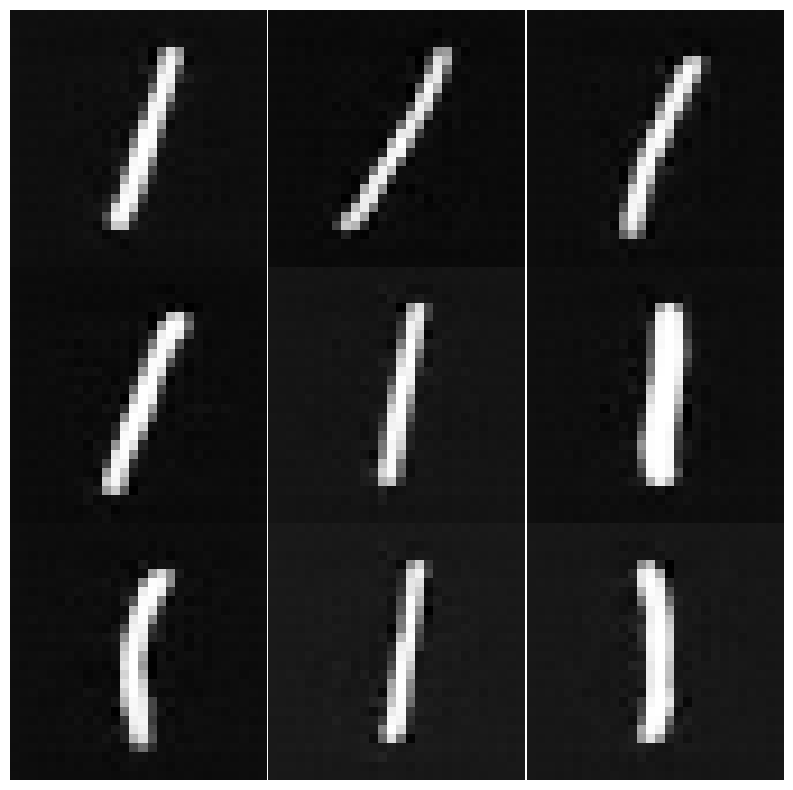

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


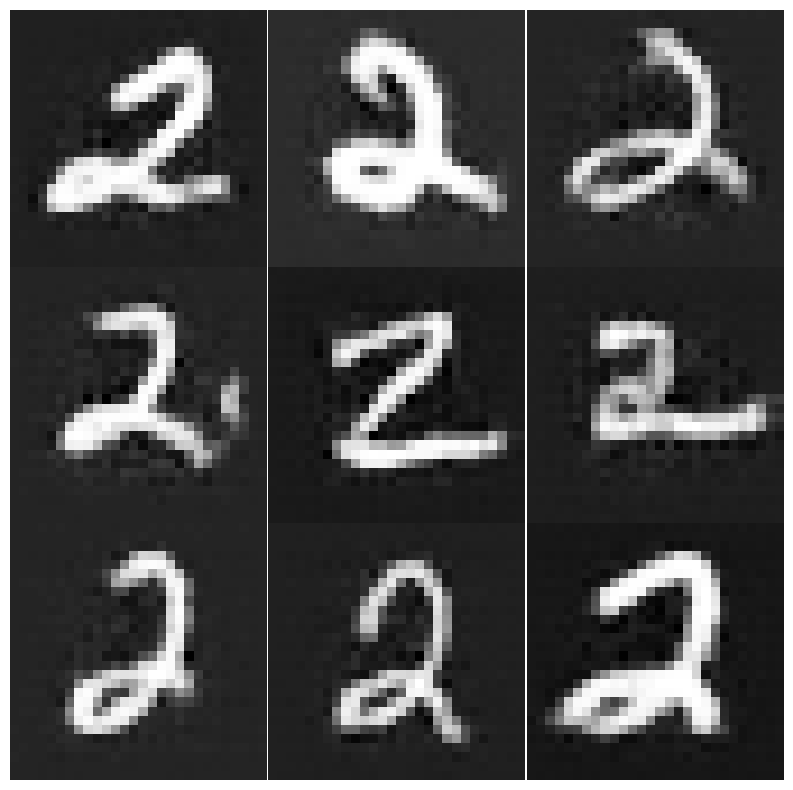

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


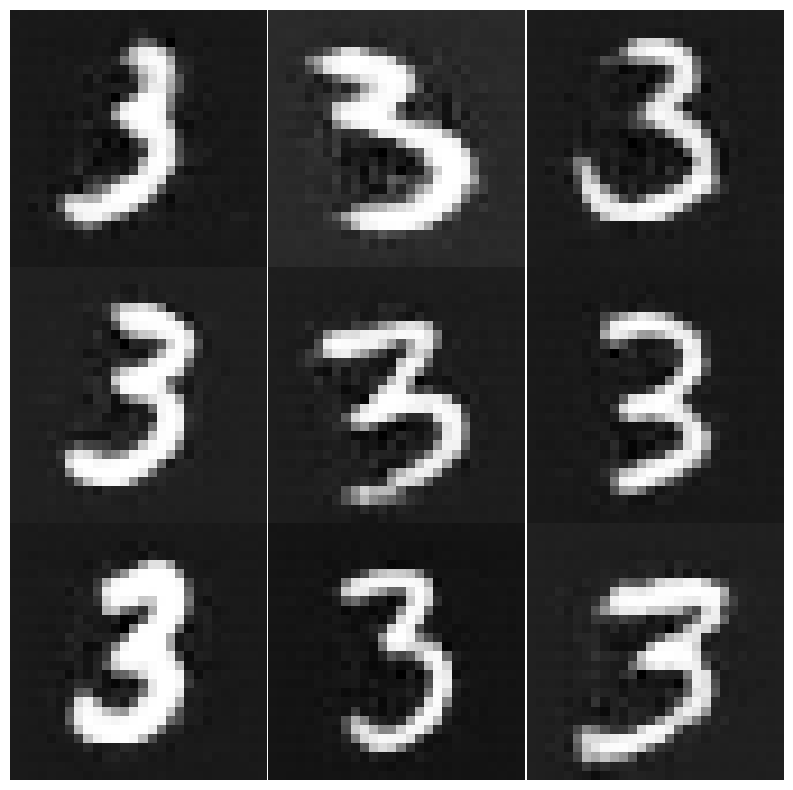

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


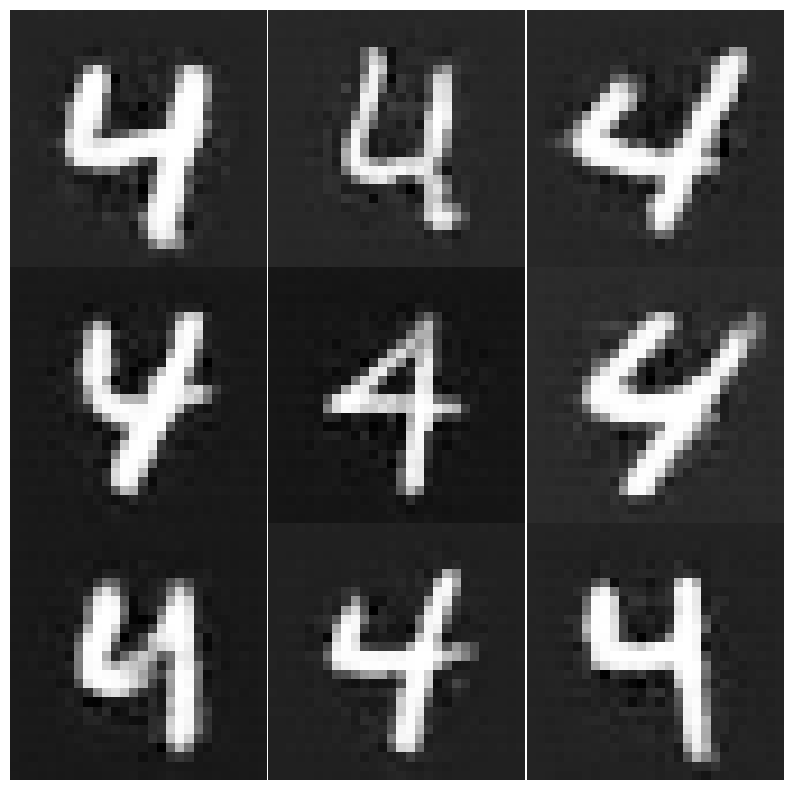

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


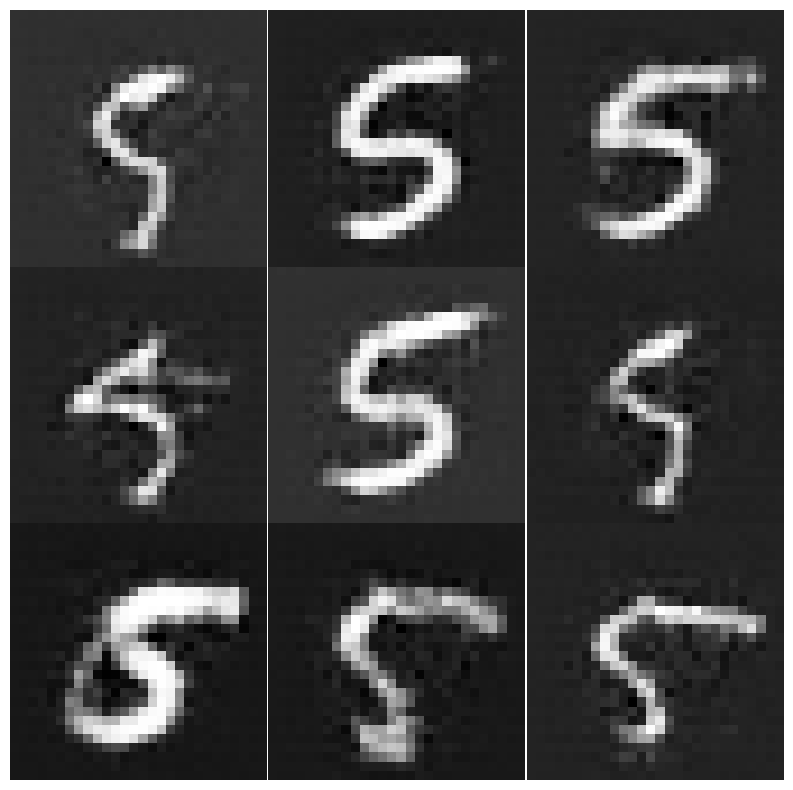

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


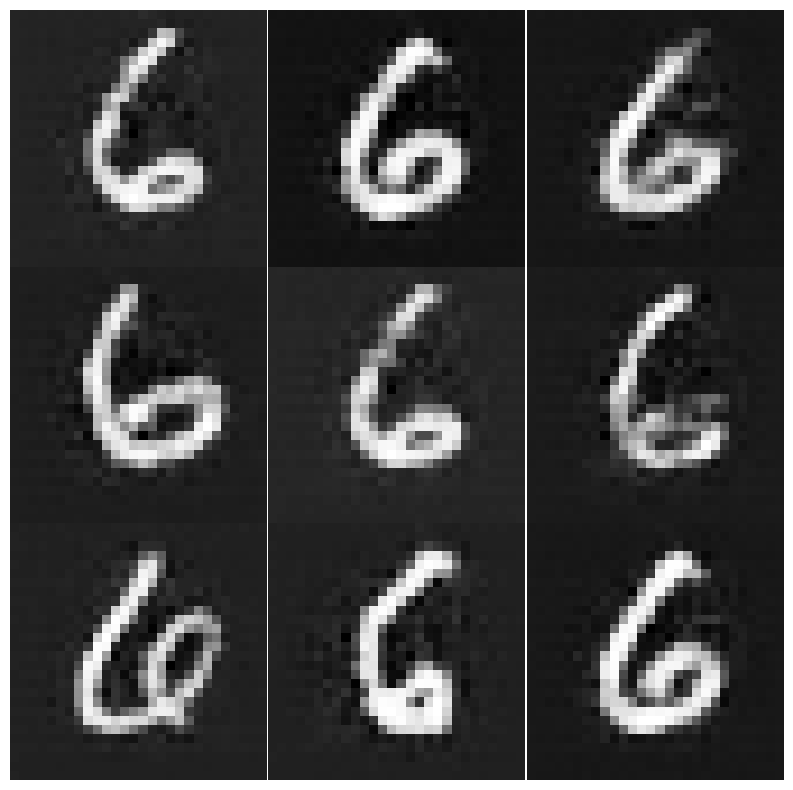

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


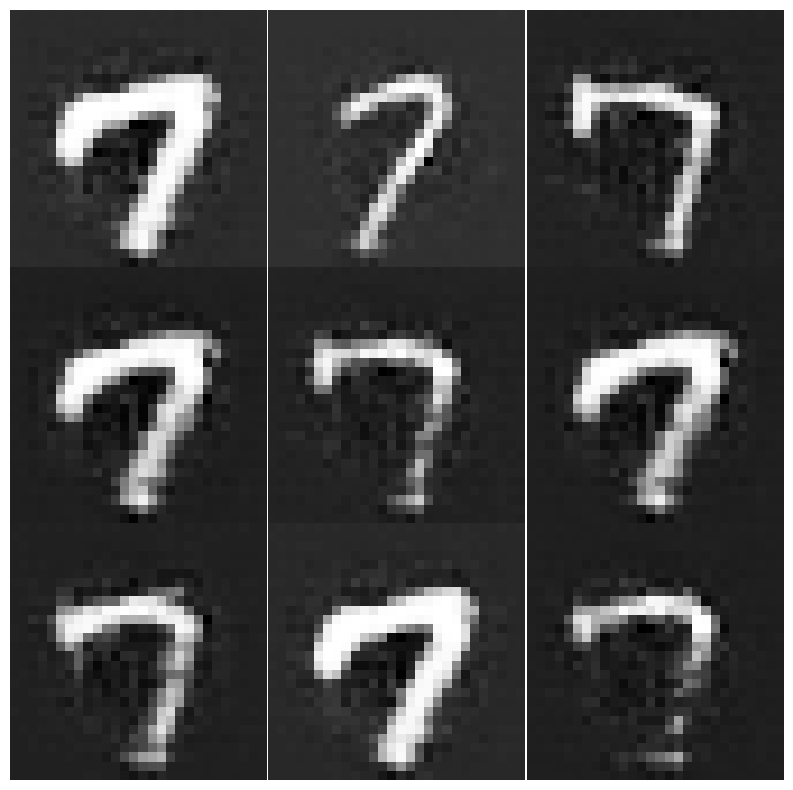

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


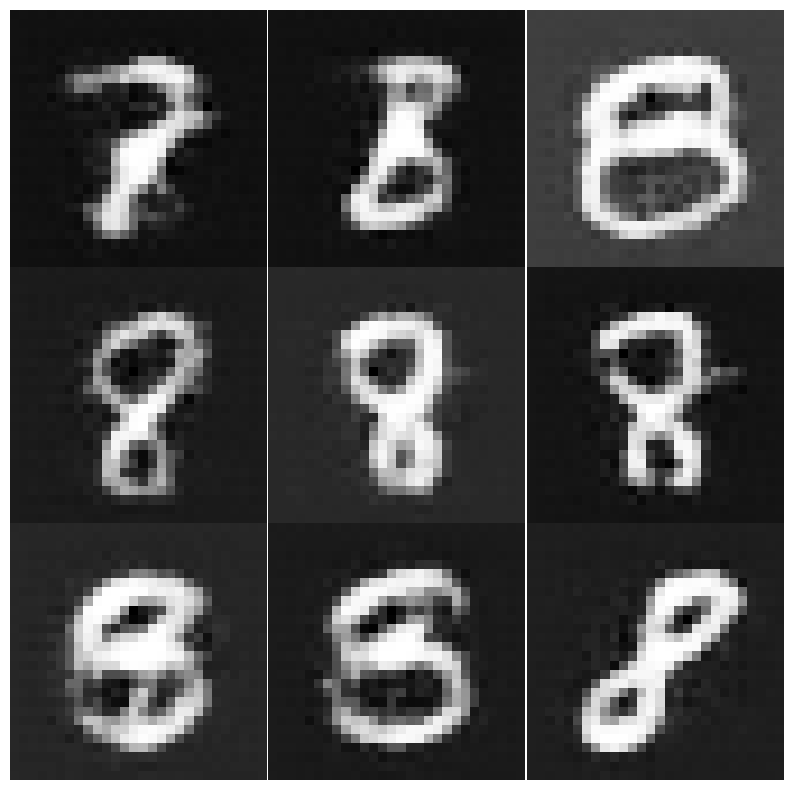

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


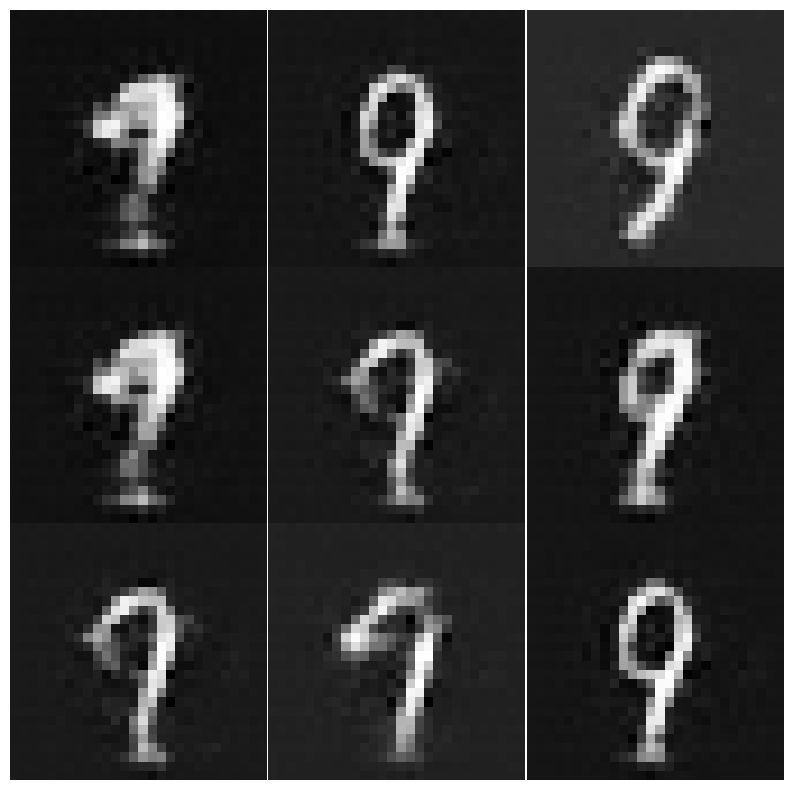

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.10
#Dataset = 1
------ Plot Balanced Imgs ------


------------------------------
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.294255
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.257076
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.147649
Train Epoch: 1 [4000/30000 (13%)]	Loss: 1.935802
Train Epoch: 1 [5000/30000 (17%)]	Loss: 1.246127
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.650060
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.441576
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.215591
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.403908
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.188279
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.145789
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.173156
Train Epoch: 1 [13000/30000 (43%)]	Loss: 0.044441
Train Epoch: 1 [14000/30000 (47%)]	Loss: 0.075705
Train Epoch: 1 [15000/30000 (50%)]	Loss: 0.099249
Train Epoch: 1 [16000/30

In [15]:
args['epochs'] = 200 # how many epochs to run for (original used 200)

trainingDataset_loss = []
avg_accuracy_list = []
avg_sensitivity_list = []
avg_specificity_list = []
avg_precision_list = []

g_mean_list = []
f_measure_list = []
acsa_list = []
cm_list = []

# initial hyperparams
temperature = 0.1      # SupCon temperature
alpha = 0.5

t3=0
for dataset,imbalanced_train in zip(folds_data,imbalanced_train_dataset_list):  #len(ids)
    print()
    print('Start...')
    encoder = Encoder(args)
    decoder = Decoder(args)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    train_on_gpu = torch.cuda.is_available()

    #decoder loss function
    criterion = nn.MSELoss()
    criterion = criterion.to(device)
    

    criterion2 = NTXentLoss().to(device)
    #criterion2 = SupConLoss().to(device)
    
    batch_size = 100
    num_workers = 0

    train_loader = dataset[0]

    classes = ('0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9')

    best_loss = np.inf

    list_zhat_test,list_labs_test = [],[]

    t0 = time.time()
    if args['train']:
        enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
        dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

        for epoch in range(args['epochs']):
            train_loss = 0.0
            tmse_loss = 0.0
            tdiscr_loss = 0.0
            
            epoch_mse = 0.0
            epoch_contrast = 0.0
            
            encoder.train()
            decoder.train()
            
            for images,labs in tqdm(train_loader,desc='Loading...'):

                # zero gradients for each batch
                enc_optim.zero_grad()   
                dec_optim.zero_grad()
                
                images, labs = images.to(device), labs.to(device)
                labsn = labs.detach().cpu().numpy()

                # run images
                z_hat,class_hat = encoder(images,labsn)
                
                # sort z_hat and class_hat by labels
                sort_z_hat = [[] for _ in range(args['num_class'])]
                for i, label in enumerate(labsn):
                    sort_z_hat[label].append(z_hat[i].cpu().detach().numpy())

                # Check if sort_z_hat is empty
                z_hat_to_concat = []
                for tensor in sort_z_hat:
                    if len(tensor) != 0:
                        z_hat_to_concat.append(torch.tensor(tensor).to(device))
                        
                if z_hat_to_concat:
                    combined_z_hat = torch.cat(z_hat_to_concat, dim=0)
                    #print('combined_z_hat',combined_z_hat.shape)
                else:
                    print('No valid tensors to concatenate, using zero tensor')
                    combined_z_hat = torch.zeros((1, args['n_z'])).to(device)

                # Check if class_hat is empty
                class_hat_to_concat = []
                for tensor in class_hat:
                    if len(tensor) != 0:
                        class_hat_to_concat.append(tensor)
                if class_hat_to_concat:
                    combined_class_hat = torch.cat(class_hat_to_concat, dim=0)
                    #print('combined_class_hat',combined_class_hat.shape)
                else:
                    print('No valid tensors to concatenate, using zero tensor')
                    combined_class_hat = torch.zeros((1, args['n_z'])).to(device)

                # *Option* L2 normalization
                combined_z_hat = F.normalize(combined_z_hat, dim=1)
                combined_class_hat = F.normalize(combined_class_hat, dim=1)
                
                features = torch.stack([combined_z_hat, combined_class_hat], dim=1)
                # The new shape of the 'features' tensor is [100, 2, 300]
                #print(features.shape)
                
                mse2 = criterion2(combined_z_hat, combined_class_hat,temperature)
                
                
                if epoch == args['epochs']-1:
                      list_labs_test = np.append(list_labs_test, labsn )
                      list_zhat_test = np.append(list_zhat_test,z_hat.cpu().detach().numpy())

                x_hat = decoder(z_hat)

                # --- MSE loss ---
                mse = criterion(x_hat, images)
     
                # --- Combined loss ---
                #alpha = 1 - min(0.5, epoch / 200) # (1 - alpha) will gradually increase

                comb_loss = alpha * mse + (1 - alpha) * mse2
                comb_loss.backward()
                
                # --- Step optimizers ---
                enc_optim.step()
                dec_optim.step()
                
                # accumulate for logging
                epoch_mse += mse.item() * images.size(0)
                epoch_contrast += mse2.item() * images.size(0)         

            # --- Log epoch losses ---
            avg_mse = epoch_mse / len(train_loader.dataset)
            avg_contrast = epoch_contrast / len(train_loader.dataset)
            avg_comb = avg_mse * alpha + avg_contrast * (1-alpha)
            print(f"Epoch {epoch}: MSE: {avg_mse:.4f}, Contrastive: {avg_contrast:.4f}, Combined: {avg_comb:.4f}")
            trainingDataset_loss.append(train_loss)
            
        #save model
        path_enc = '/home/s2522002/source_code/model/enc_mnist.pth'
        path_dec = '/home/s2522002/source_code/model/dec_mnist.pth'
        print(path_enc)
        print(path_dec)
        torch.save(encoder.state_dict(), path_enc)
        torch.save(decoder.state_dict(), path_dec)
        print()

    t1 = time.time()
    print('total time(min): {:.2f}'.format((t1 - t0)/60))
    
    ################  PLOT TRAIN DISTRIBUTION ######################
    import numpy as np
    import plotly.express as px
    
    #list_labs_test,list_zhat_test
    copy_list_zhat_test = list_zhat_test.copy()
    
    first_dim = len(list_zhat_test) // args['n_z']
    list_zhat_test_reshape =  copy_list_zhat_test.reshape(first_dim, args['n_z'])
    
    from sklearn.manifold import TSNE
    print('------ Plot Latent Space ------')
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(list_zhat_test_reshape)
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=list_labs_test)
    fig.show()
    print('------------------------------')
    
    ############ GENERATE ###########################################################
    import collections
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset
    import numpy as np
    import time
    import os
    import matplotlib.pyplot as plt
    np.printoptions(precision=5,suppress=True)
    
    #path on the computer where the models are stored
    latent_img,latent_lab = [],[]
    modpth = '/home/s2522002/source_code/model'    
    
    encf = []
    decf = []
    for p in range(1):
        enc = modpth + '/' + '/enc_mnist.pth'
        dec = modpth + '/' + '/dec_mnist.pth'
        encf.append(enc)
        decf.append(dec)
    
    for m in range(1):
        print(m)
    
        classes = ('0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9')
    
        #generate some images
        train_on_gpu = torch.cuda.is_available()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        path_enc = encf[m]
        path_dec = decf[m]
    
        encoder = Encoder(args)
        # Load the encoder state dictionary and map to the available device
        encoder.load_state_dict(torch.load(path_enc, map_location=device), strict=False)
        encoder = encoder.to(device)
    
        decoder = Decoder(args)
        decoder.load_state_dict(torch.load(path_dec, map_location=device), strict=False)
        decoder = decoder.to(device)
    
        encoder.eval()
        decoder.eval()
    
        imbal = [3000, 2000, 1000, 750, 500, 12, 10, 8, 6, 4]
    
        resx = []
        resy = []
        
        data = [item[0] for item in imbalanced_train]
        target = [item[1] for item in imbalanced_train]
        data = torch.stack(data)
        target = torch.tensor(target)

        t0 = time.time()
        for i in range(1,10):
    
            xclass, yclass = biased_get_class1(i,data,target)
    
            print(xclass.shape) 
            print('class',yclass[0]) 
    
            #encode xclass to feature space
            xclass = xclass.to(device)
            xclass,_ = encoder(xclass,yclass)
            print(xclass.shape) 

            xclass = xclass.detach().cpu().numpy()

            latent_img = np.append(latent_img, xclass)
            latent_lab = np.append(latent_lab, yclass)
            
            n = imbal[0] - imbal[i]
    
            #SMOTE
            xsamp, ysamp = Generate_SMOTE(xclass,yclass,n,i)
            print('after smote',xsamp.shape) #(4500, 600)
            ysamp = np.array(ysamp)
            print('after smote',ysamp.shape) #4500
            xsamp = torch.Tensor(xsamp)
            xsamp = xsamp.to(device)
            
            print('after smote&to tensor',xsamp.shape) 
           
            ximg = decoder(xsamp)
    
            ximn = ximg.detach().cpu().numpy()
            print('after decoder',ximn.shape) #(4500, 3, 32, 32)
           
            resx.append(ximn)
            resy.append(ysamp)
    
            # Squeeze the first dimension to get a compatible shape for imshow
            
            plt.figure(figsize=(10,10))
            for k in range(9):
              plt.subplot(3,3,k+1)
              ximn_squeezed = ximn[k].squeeze()
              plt.imshow(ximn_squeezed, cmap='gray')
              plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.show()
    
        t1 = time.time()
        resx1 = np.vstack(resx)
        resy1 = np.hstack(resy)
    
        print('after generate',resx1.shape) #(34720, 3, 32, 32)
        print('after generate',resy1.shape) #(34720,)
    
        resx1 = resx1.reshape(resx1.shape[0],-1)
        print('reshape',resx1.shape) #(34720, 3072)
    
        dec_x1 = data.reshape(data.shape[0],-1)
        print('decx1(imb imported) ',dec_x1.shape)
        combx = np.vstack((resx1,dec_x1))
        comby = np.hstack((resy1,target))
    
        print('combined',combx.shape) #(45000, 3, 32, 32)
        print('combined',comby.shape) #(45000,)
    
        ifile = '/home/s2522002/source_code/sampling/balimg_mnist/trn_img.txt'
        np.savetxt(ifile, combx)

        lfile = '/home/s2522002/source_code/sampling/ballab_mnist/trn_lab.txt'
        np.savetxt(lfile,comby)
    
        print()
        #sys.exit(1)
    
    
    print('final time(min): {:.2f}'.format((t1 - t0)/60))

    #  PLOT BALANCED DISTRIBUTION ##########################################################
    from sklearn.manifold import TSNE
    dtrnimg = '/home/s2522002/source_code/sampling/balimg_mnist'
    dtrnlab = '/home/s2522002/source_code/sampling/ballab_mnist'
    
    ids = os.listdir(dtrnimg)
    idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
    
    ids = os.listdir(dtrnlab)
    idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
    
    print("#Dataset =",len(ids))
    # Load the training images and labels
    trnimgfile = idtri_f[0]
    trnlabfile = idtrl_f[0]
    dec_x = np.loadtxt(trnimgfile)
    dec_y = np.loadtxt(trnlabfile)

    print('------ Plot Balanced Imgs ------')

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(dec_x)
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=dec_y)
    fig.show()
    
    print('------------------------------')

    #  IMPORT BALANCED IMAGES ###########################################################
    from sklearn.model_selection import KFold
    import numpy as np
    import collections
    import torch
    from torch.utils.data import TensorDataset
    
    dtrnimg = '/home/s2522002/source_code/sampling/balimg_mnist'
    dtrnlab = '/home/s2522002/source_code/sampling/ballab_mnist'
    
    ids = os.listdir(dtrnimg)
    idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
    
    ids = os.listdir(dtrnlab)
    idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
    
    print("#Dataset =",len(ids))
    
    trnimgfile = idtri_f[0]
    trnlabfile = idtrl_f[0]
    dec_x = np.loadtxt(trnimgfile)
    dec_y = np.loadtxt(trnlabfile)
    
    #Reshape
    dec_x = dec_x.reshape(dec_x.shape[0],args['n_channel'] ,28,28)
    
    batch_size = 100
    num_workers = 0
    
    #torch.Tensor returns float so if want long then use torch.tensor
    tensor_x = torch.Tensor(dec_x)
    tensor_y = torch.tensor(dec_y,dtype=torch.long)
    mnist_bal = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(mnist_bal,
                    batch_size=batch_size,shuffle=True,num_workers=num_workers)
    
    print(np.shape(dec_x))
    print(np.shape(dec_y))
    
    print(collections.Counter(dec_y))
    
    print('train imgs after reshape ',dec_x.shape)

    ###########################  TRAIN CNN  ####################################################
    # Create model, optimizer, and loss function
    #check gpu
    import torch.optim as optim
    import torch.nn as nn
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #set hyperparameters
    EPOCH = 2
    pre_epoch = 0
    BATCH_SIZE = 100
    LR = 0.01
    
    model = SimpleCNN().to(device)#ResNetMNIST().to(device)#SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #optim.Adam(model.parameters())
    
    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
    
            output = model(data)
    
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
            if (batch_idx + 1) % 10 == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch + 1,
                        (batch_idx+1) * len(data),
                        len(train_loader.dataset),
                        100.0 * (batch_idx+1) / len(train_loader),
                        loss.item(),
                    )
                )
    
    print("Training finished!")


    ########################### TEST CNN ####################################################
    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set the model to evaluation mode
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in dataset[1]:
            data = data.to(device)
            target = target.to(device)
    
            output = model(data)
            _, predicted = torch.max(output.data, 1)
    
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)
    cm_list.append(cm)
    
    # Calculate class-wise accuracy, sensitivity, specificity, and precision
    class_accuracies = []
    class_sensitivities = []
    class_specificities = []
    class_precisions = []
    
    for i in range(cm.shape[0]):
      tp = cm[i, i]
      fp = np.sum(cm[:, i]) - tp
      fn = np.sum(cm[i, :]) - tp
      tn = np.sum(cm) - tp - fp - fn
    
      class_accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
      class_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
      class_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
      class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
      class_accuracies.append(class_accuracy)
      class_sensitivities.append(class_sensitivity)
      class_specificities.append(class_specificity)
      class_precisions.append(class_precision)
    
    # Calculate the average accuracy, sensitivity, specificity, and precision
    avg_accuracy = np.mean(class_accuracies)
    avg_sensitivity = np.mean(class_sensitivities)
    avg_specificity = np.mean(class_specificities)
    avg_precision = np.mean(class_precisions)
    
    # Calculate G-mean and F-measure
    g_mean = np.sqrt(avg_sensitivity * avg_specificity)
    f_measure = 2 * (avg_precision * avg_sensitivity) / (avg_precision + avg_sensitivity) if (avg_precision + avg_sensitivity) > 0 else 0
    
    print("\nAverage Accuracy:", avg_accuracy)
    print("Average Sensitivity:", avg_sensitivity)
    print("Average Specificity:", avg_specificity)
    print("Average Precision:", avg_precision)
    
    print("\nG-mean:", g_mean)
    print("F-measure:", f_measure)
    
    # Calculate ACSA (Average Class-wise Sensitivity and Accuracy)
    acsa = (avg_sensitivity + avg_accuracy) / 2
    print("\nACSA:", acsa)
    
    avg_accuracy_list.append(avg_accuracy)
    print(avg_accuracy_list)
    avg_sensitivity_list.append(avg_sensitivity)
    avg_specificity_list.append(avg_specificity)
    avg_precision_list.append(avg_precision)
    g_mean_list.append(g_mean)
    f_measure_list.append(f_measure)
    acsa_list.append(acsa)

t4 = time.time()
print('final time(min): {:.2f}'.format((t4 - t3)/60))

### Avg via folders

In [16]:
import statistics
print("Average Accuracy:", statistics.mean(avg_accuracy_list))
print("Average Sensitivity:", statistics.mean(avg_sensitivity_list))
print("Average Specificity:", statistics.mean(avg_specificity_list))
print("Average Precision:", statistics.mean(avg_precision_list))

print("\nG-mean:", statistics.mean(g_mean_list))
print("F-measure:", statistics.mean(f_measure_list))
print("\nACSA:", statistics.mean(acsa_list))
print(cm_list)

Average Accuracy: 0.9512820512820512
Average Sensitivity: 0.7564102564102564
Average Specificity: 0.972934472934473
Average Precision: 0.8095252237234072

G-mean: 0.8578349849051715
F-measure: 0.7820139065277635

ACSA: 0.8538461538461538
[array([[1801,    0,    1,    1,    2,    2,    0,    0,    0,    0],
       [   2, 1784,    5,    8,    2,    0,    0,    2,    1,    3],
       [  24,   12, 1727,   17,   15,    0,    0,    1,   11,    0],
       [   9,   11,   31, 1737,    1,    8,    1,    3,    3,    3],
       [  10,    9,    7,    1, 1771,    0,    0,    1,    1,    7],
       [ 192,   88,   29,  258,   57, 1143,   21,   11,    5,    3],
       [  65,  152,   91,    7,  139,   25, 1328,    0,    0,    0],
       [  92,   18,  151,  158,   85,    0,    0, 1246,   18,   39],
       [ 293,   65,  122,  562,   64,   10,    4,   10,  675,    2],
       [ 120,   10,   42,  131, 1049,    4,    0,  120,   11,  320]]), array([[1791,    2,    9,    2,    3,    0,    0,    0,    0,    0],


## Traning - Gen - Evalution (L2)


Start...
cuda


Loading...: 100%|██████████| 29/29 [00:02<00:00, 14.24it/s]


Epoch: 0 	Train Loss: 89.305907 	mse loss: 89.304328 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 1 	Train Loss: 21.895305 	mse loss: 21.893470 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.72it/s]


Epoch: 2 	Train Loss: 15.614953 	mse loss: 15.613139 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 3 	Train Loss: 11.685864 	mse loss: 11.684078 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 4 	Train Loss: 8.945190 	mse loss: 8.943410 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]


Epoch: 5 	Train Loss: 7.473871 	mse loss: 7.472161 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.69it/s]


Epoch: 6 	Train Loss: 6.403001 	mse loss: 6.401230 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch: 7 	Train Loss: 5.057084 	mse loss: 5.055343 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.94it/s]


Epoch: 8 	Train Loss: 4.970409 	mse loss: 4.968705 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.72it/s]


Epoch: 9 	Train Loss: 5.034825 	mse loss: 5.033266 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]


Epoch: 10 	Train Loss: 4.914198 	mse loss: 4.912729 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.77it/s]


Epoch: 11 	Train Loss: 3.839542 	mse loss: 3.837959 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch: 12 	Train Loss: 3.477209 	mse loss: 3.475672 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.50it/s]


Epoch: 13 	Train Loss: 3.069611 	mse loss: 3.068097 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch: 14 	Train Loss: 2.995821 	mse loss: 2.994335 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]


Epoch: 15 	Train Loss: 2.767079 	mse loss: 2.765633 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.54it/s]


Epoch: 16 	Train Loss: 2.683533 	mse loss: 2.682107 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch: 17 	Train Loss: 2.595031 	mse loss: 2.593630 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch: 18 	Train Loss: 2.456979 	mse loss: 2.455592 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]


Epoch: 19 	Train Loss: 2.567857 	mse loss: 2.566484 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 20 	Train Loss: 2.379550 	mse loss: 2.378190 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.11it/s]


Epoch: 21 	Train Loss: 2.340521 	mse loss: 2.339166 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 22 	Train Loss: 2.228207 	mse loss: 2.226849 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]


Epoch: 23 	Train Loss: 2.258253 	mse loss: 2.256916 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch: 24 	Train Loss: 2.204829 	mse loss: 2.203503 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]


Epoch: 25 	Train Loss: 2.198326 	mse loss: 2.197002 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 26 	Train Loss: 2.122755 	mse loss: 2.121434 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]


Epoch: 27 	Train Loss: 2.116775 	mse loss: 2.115468 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 28 	Train Loss: 2.063426 	mse loss: 2.062141 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.13it/s]


Epoch: 29 	Train Loss: 1.969609 	mse loss: 1.968324 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]


Epoch: 30 	Train Loss: 2.015567 	mse loss: 2.014286 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 31 	Train Loss: 1.906475 	mse loss: 1.905213 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 32 	Train Loss: 1.880602 	mse loss: 1.879347 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.85it/s]


Epoch: 33 	Train Loss: 1.855685 	mse loss: 1.854444 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 34 	Train Loss: 1.848947 	mse loss: 1.847701 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.94it/s]


Epoch: 35 	Train Loss: 1.887147 	mse loss: 1.885898 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 36 	Train Loss: 1.931337 	mse loss: 1.930095 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.87it/s]


Epoch: 37 	Train Loss: 1.749488 	mse loss: 1.748259 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.94it/s]


Epoch: 38 	Train Loss: 1.737035 	mse loss: 1.735812 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch: 39 	Train Loss: 1.753248 	mse loss: 1.752031 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


Epoch: 40 	Train Loss: 1.718002 	mse loss: 1.716787 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.25it/s]


Epoch: 41 	Train Loss: 1.695048 	mse loss: 1.693846 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


Epoch: 42 	Train Loss: 1.709185 	mse loss: 1.707982 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 43 	Train Loss: 1.668966 	mse loss: 1.667762 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


Epoch: 44 	Train Loss: 1.755902 	mse loss: 1.754707 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.25it/s]


Epoch: 45 	Train Loss: 1.640374 	mse loss: 1.639184 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 46 	Train Loss: 1.666936 	mse loss: 1.665758 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]


Epoch: 47 	Train Loss: 1.602663 	mse loss: 1.601490 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.67it/s]


Epoch: 48 	Train Loss: 1.602725 	mse loss: 1.601546 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch: 49 	Train Loss: 1.571930 	mse loss: 1.570770 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.63it/s]


Epoch: 50 	Train Loss: 1.554150 	mse loss: 1.552997 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 51 	Train Loss: 1.572038 	mse loss: 1.570888 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]


Epoch: 52 	Train Loss: 1.547098 	mse loss: 1.545954 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch: 53 	Train Loss: 1.471466 	mse loss: 1.470318 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]


Epoch: 54 	Train Loss: 1.498661 	mse loss: 1.497523 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.71it/s]


Epoch: 55 	Train Loss: 1.544094 	mse loss: 1.542958 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.35it/s]


Epoch: 56 	Train Loss: 1.482735 	mse loss: 1.481601 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.99it/s]


Epoch: 57 	Train Loss: 1.501004 	mse loss: 1.499879 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 58 	Train Loss: 1.535732 	mse loss: 1.534603 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 59 	Train Loss: 1.528290 	mse loss: 1.527159 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.77it/s]


Epoch: 60 	Train Loss: 1.399933 	mse loss: 1.398821 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]


Epoch: 61 	Train Loss: 1.424517 	mse loss: 1.423400 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.94it/s]


Epoch: 62 	Train Loss: 1.464810 	mse loss: 1.463700 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.06it/s]


Epoch: 63 	Train Loss: 1.386611 	mse loss: 1.385505 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 64 	Train Loss: 1.390030 	mse loss: 1.388932 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]


Epoch: 65 	Train Loss: 1.383501 	mse loss: 1.382405 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]


Epoch: 66 	Train Loss: 1.337051 	mse loss: 1.335959 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.13it/s]


Epoch: 67 	Train Loss: 1.336713 	mse loss: 1.335625 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]


Epoch: 68 	Train Loss: 1.371437 	mse loss: 1.370348 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.65it/s]


Epoch: 69 	Train Loss: 1.335680 	mse loss: 1.334595 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 70 	Train Loss: 1.372446 	mse loss: 1.371369 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.09it/s]


Epoch: 71 	Train Loss: 1.361577 	mse loss: 1.360500 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 72 	Train Loss: 1.317586 	mse loss: 1.316514 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]


Epoch: 73 	Train Loss: 1.260066 	mse loss: 1.259003 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 74 	Train Loss: 1.281989 	mse loss: 1.280923 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 75 	Train Loss: 1.259478 	mse loss: 1.258411 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.13it/s]


Epoch: 76 	Train Loss: 1.303016 	mse loss: 1.301956 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 77 	Train Loss: 1.213379 	mse loss: 1.212325 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.29it/s]


Epoch: 78 	Train Loss: 1.227857 	mse loss: 1.226800 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.52it/s]


Epoch: 79 	Train Loss: 1.224538 	mse loss: 1.223482 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.06it/s]


Epoch: 80 	Train Loss: 1.240741 	mse loss: 1.239694 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch: 81 	Train Loss: 1.172652 	mse loss: 1.171607 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch: 82 	Train Loss: 1.164965 	mse loss: 1.163922 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]


Epoch: 83 	Train Loss: 1.197291 	mse loss: 1.196250 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]


Epoch: 84 	Train Loss: 1.255582 	mse loss: 1.254546 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]


Epoch: 85 	Train Loss: 1.161294 	mse loss: 1.160261 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 86 	Train Loss: 1.178820 	mse loss: 1.177788 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.30it/s]


Epoch: 87 	Train Loss: 1.176416 	mse loss: 1.175382 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]


Epoch: 88 	Train Loss: 1.267388 	mse loss: 1.266364 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.35it/s]


Epoch: 89 	Train Loss: 1.196487 	mse loss: 1.195464 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 90 	Train Loss: 1.151953 	mse loss: 1.150935 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 91 	Train Loss: 1.140259 	mse loss: 1.139243 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 92 	Train Loss: 1.175125 	mse loss: 1.174109 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 93 	Train Loss: 1.154268 	mse loss: 1.153254 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 94 	Train Loss: 1.208043 	mse loss: 1.207039 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.67it/s]


Epoch: 95 	Train Loss: 1.181166 	mse loss: 1.180168 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 96 	Train Loss: 1.126401 	mse loss: 1.125405 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 97 	Train Loss: 1.146177 	mse loss: 1.145173 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.57it/s]


Epoch: 98 	Train Loss: 1.137787 	mse loss: 1.136794 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


Epoch: 99 	Train Loss: 1.166184 	mse loss: 1.165195 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]


Epoch: 100 	Train Loss: 1.114132 	mse loss: 1.113144 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch: 101 	Train Loss: 1.227459 	mse loss: 1.226476 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch: 102 	Train Loss: 1.126536 	mse loss: 1.125555 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]


Epoch: 103 	Train Loss: 1.100780 	mse loss: 1.099795 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.21it/s]


Epoch: 104 	Train Loss: 1.084194 	mse loss: 1.083220 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 105 	Train Loss: 1.019955 	mse loss: 1.018980 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch: 106 	Train Loss: 1.002975 	mse loss: 1.002003 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch: 107 	Train Loss: 1.015151 	mse loss: 1.014186 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.18it/s]


Epoch: 108 	Train Loss: 1.009561 	mse loss: 1.008592 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]


Epoch: 109 	Train Loss: 1.025138 	mse loss: 1.024174 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 110 	Train Loss: 1.036080 	mse loss: 1.035115 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.11it/s]


Epoch: 111 	Train Loss: 1.009168 	mse loss: 1.008204 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]


Epoch: 112 	Train Loss: 0.982383 	mse loss: 0.981424 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.37it/s]


Epoch: 113 	Train Loss: 1.002529 	mse loss: 1.001568 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]


Epoch: 114 	Train Loss: 1.013666 	mse loss: 1.012708 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.56it/s]


Epoch: 115 	Train Loss: 0.974203 	mse loss: 0.973249 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch: 116 	Train Loss: 1.005389 	mse loss: 1.004438 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]


Epoch: 117 	Train Loss: 1.058925 	mse loss: 1.057981 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 118 	Train Loss: 0.993999 	mse loss: 0.993054 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.85it/s]


Epoch: 119 	Train Loss: 0.938546 	mse loss: 0.937604 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]


Epoch: 120 	Train Loss: 0.965896 	mse loss: 0.964956 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]


Epoch: 121 	Train Loss: 1.026707 	mse loss: 1.025763 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 122 	Train Loss: 0.939364 	mse loss: 0.938426 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 123 	Train Loss: 0.933132 	mse loss: 0.932197 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]


Epoch: 124 	Train Loss: 0.953705 	mse loss: 0.952776 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 125 	Train Loss: 0.987489 	mse loss: 0.986560 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]


Epoch: 126 	Train Loss: 0.962788 	mse loss: 0.961865 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.47it/s]


Epoch: 127 	Train Loss: 0.941992 	mse loss: 0.941073 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 128 	Train Loss: 0.921464 	mse loss: 0.920545 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 129 	Train Loss: 1.009896 	mse loss: 1.008970 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.53it/s]


Epoch: 130 	Train Loss: 0.945937 	mse loss: 0.945021 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.47it/s]


Epoch: 131 	Train Loss: 0.886650 	mse loss: 0.885735 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 132 	Train Loss: 0.871368 	mse loss: 0.870455 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.13it/s]


Epoch: 133 	Train Loss: 0.892059 	mse loss: 0.891151 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 134 	Train Loss: 0.885290 	mse loss: 0.884384 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 135 	Train Loss: 0.868044 	mse loss: 0.867138 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]


Epoch: 136 	Train Loss: 0.917725 	mse loss: 0.916811 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 137 	Train Loss: 1.091093 	mse loss: 1.090186 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 138 	Train Loss: 0.879477 	mse loss: 0.878572 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.18it/s]


Epoch: 139 	Train Loss: 0.894181 	mse loss: 0.893279 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.73it/s]


Epoch: 140 	Train Loss: 0.865978 	mse loss: 0.865081 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.93it/s]


Epoch: 141 	Train Loss: 0.866136 	mse loss: 0.865239 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.21it/s]


Epoch: 142 	Train Loss: 0.834864 	mse loss: 0.833970 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 143 	Train Loss: 0.809289 	mse loss: 0.808397 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.76it/s]


Epoch: 144 	Train Loss: 0.839971 	mse loss: 0.839072 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch: 145 	Train Loss: 0.846364 	mse loss: 0.845471 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]


Epoch: 146 	Train Loss: 0.788907 	mse loss: 0.788014 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 147 	Train Loss: 0.789900 	mse loss: 0.789006 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.56it/s]


Epoch: 148 	Train Loss: 0.841420 	mse loss: 0.840532 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch: 149 	Train Loss: 0.807160 	mse loss: 0.806272 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.54it/s]


Epoch: 150 	Train Loss: 0.853308 	mse loss: 0.852425 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch: 151 	Train Loss: 0.827523 	mse loss: 0.826638 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]


Epoch: 152 	Train Loss: 0.812210 	mse loss: 0.811327 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.73it/s]


Epoch: 153 	Train Loss: 0.822187 	mse loss: 0.821311 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.53it/s]


Epoch: 154 	Train Loss: 0.779820 	mse loss: 0.778945 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.69it/s]


Epoch: 155 	Train Loss: 0.895837 	mse loss: 0.894960 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.69it/s]


Epoch: 156 	Train Loss: 0.808520 	mse loss: 0.807645 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.54it/s]


Epoch: 157 	Train Loss: 0.806825 	mse loss: 0.805953 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.48it/s]


Epoch: 158 	Train Loss: 0.770047 	mse loss: 0.769174 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]


Epoch: 159 	Train Loss: 0.799238 	mse loss: 0.798369 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 160 	Train Loss: 0.798618 	mse loss: 0.797748 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]


Epoch: 161 	Train Loss: 0.768394 	mse loss: 0.767524 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 162 	Train Loss: 0.864206 	mse loss: 0.863331 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 163 	Train Loss: 0.884784 	mse loss: 0.883917 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch: 164 	Train Loss: 0.810343 	mse loss: 0.809477 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]


Epoch: 165 	Train Loss: 1.064377 	mse loss: 1.063516 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]


Epoch: 166 	Train Loss: 0.814995 	mse loss: 0.814130 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]


Epoch: 167 	Train Loss: 0.811138 	mse loss: 0.810277 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.58it/s]


Epoch: 168 	Train Loss: 0.826301 	mse loss: 0.825443 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch: 169 	Train Loss: 0.763442 	mse loss: 0.762586 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 170 	Train Loss: 0.765072 	mse loss: 0.764225 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 171 	Train Loss: 0.789846 	mse loss: 0.789000 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 172 	Train Loss: 0.866483 	mse loss: 0.865628 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.30it/s]


Epoch: 173 	Train Loss: 0.782856 	mse loss: 0.782006 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch: 174 	Train Loss: 0.782249 	mse loss: 0.781403 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.32it/s]


Epoch: 175 	Train Loss: 0.766365 	mse loss: 0.765520 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]


Epoch: 176 	Train Loss: 0.733910 	mse loss: 0.733071 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 177 	Train Loss: 0.708710 	mse loss: 0.707870 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]


Epoch: 178 	Train Loss: 0.704164 	mse loss: 0.703326 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]


Epoch: 179 	Train Loss: 0.763352 	mse loss: 0.762516 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch: 180 	Train Loss: 0.709704 	mse loss: 0.708868 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]


Epoch: 181 	Train Loss: 0.693406 	mse loss: 0.692577 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.48it/s]


Epoch: 182 	Train Loss: 0.721533 	mse loss: 0.720700 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.53it/s]


Epoch: 183 	Train Loss: 0.673304 	mse loss: 0.672472 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.32it/s]


Epoch: 184 	Train Loss: 0.703794 	mse loss: 0.702958 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]


Epoch: 185 	Train Loss: 0.665423 	mse loss: 0.664590 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch: 186 	Train Loss: 0.697796 	mse loss: 0.696965 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch: 187 	Train Loss: 0.711005 	mse loss: 0.710172 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 188 	Train Loss: 0.685050 	mse loss: 0.684226 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.29it/s]


Epoch: 189 	Train Loss: 0.746843 	mse loss: 0.746015 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch: 190 	Train Loss: 0.735183 	mse loss: 0.734357 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.25it/s]


Epoch: 191 	Train Loss: 0.787621 	mse loss: 0.786795 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.25it/s]


Epoch: 192 	Train Loss: 0.728382 	mse loss: 0.727561 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]


Epoch: 193 	Train Loss: 0.686562 	mse loss: 0.685743 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 194 	Train Loss: 0.642381 	mse loss: 0.641562 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]


Epoch: 195 	Train Loss: 0.653436 	mse loss: 0.652616 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.06it/s]


Epoch: 196 	Train Loss: 0.601717 	mse loss: 0.600900 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]


Epoch: 197 	Train Loss: 0.598391 	mse loss: 0.597576 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 198 	Train Loss: 0.658065 	mse loss: 0.657249 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]


Epoch: 199 	Train Loss: 0.622458 	mse loss: 0.621641 	mse2 loss: 0.000000
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.62


0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


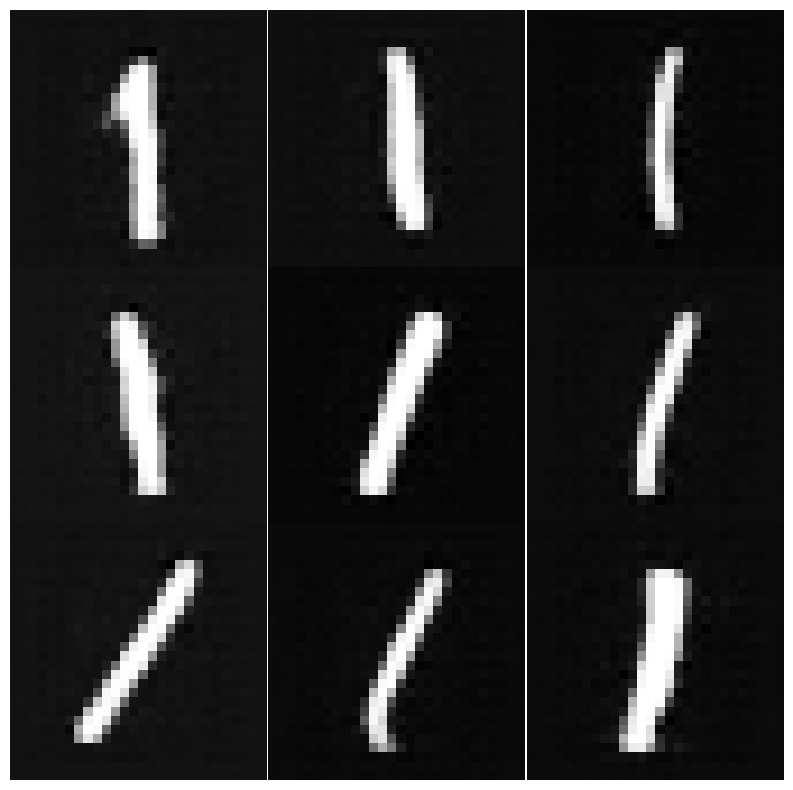

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


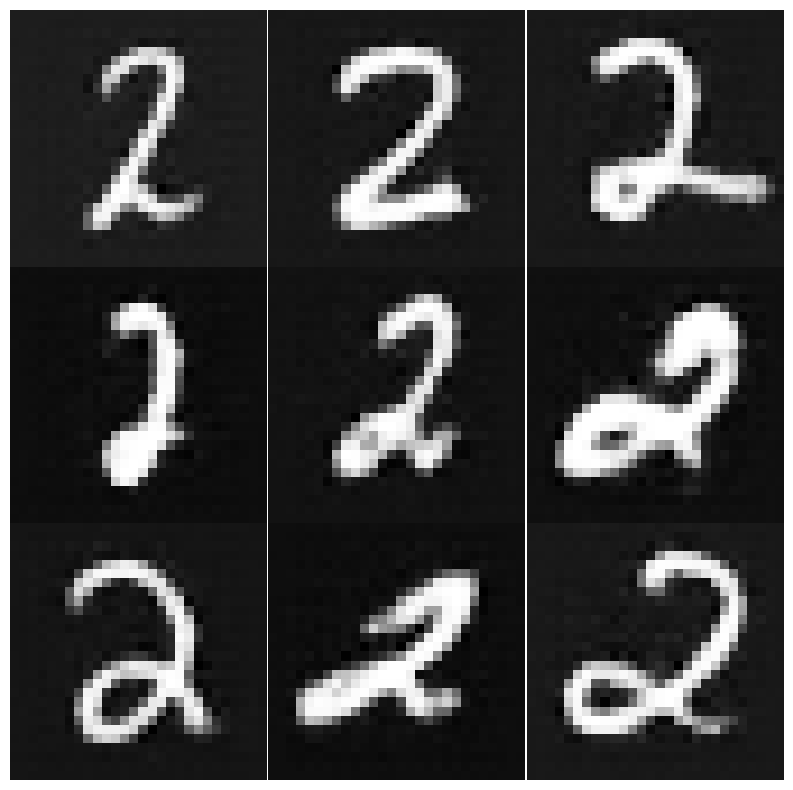

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


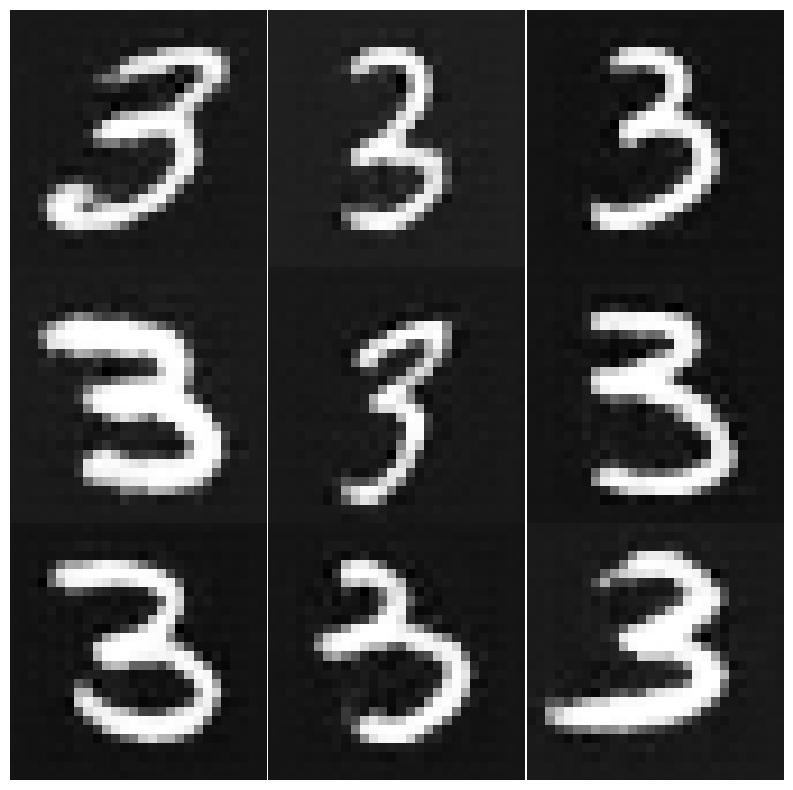

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


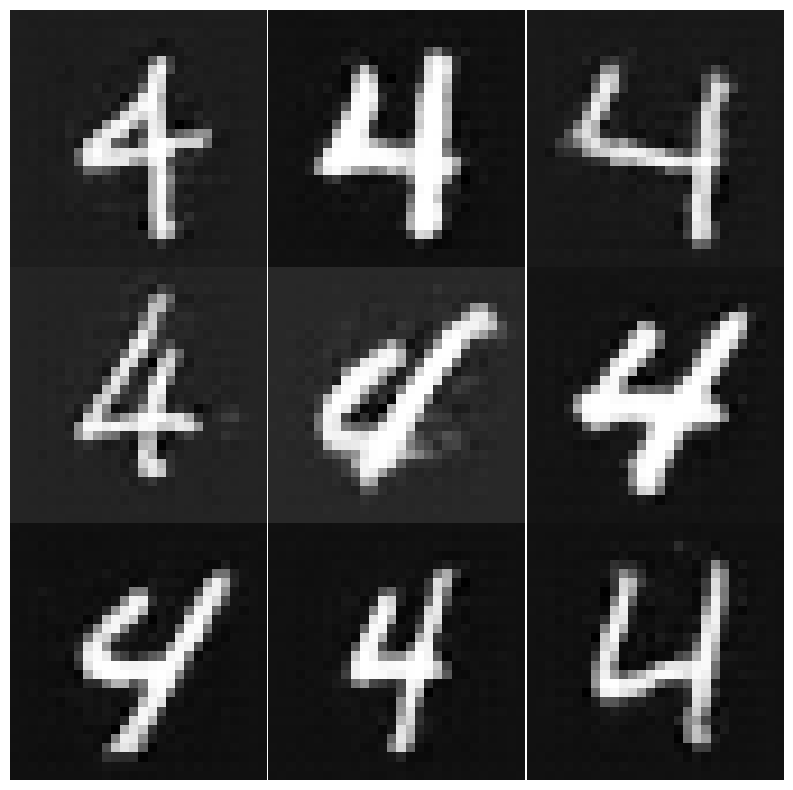

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


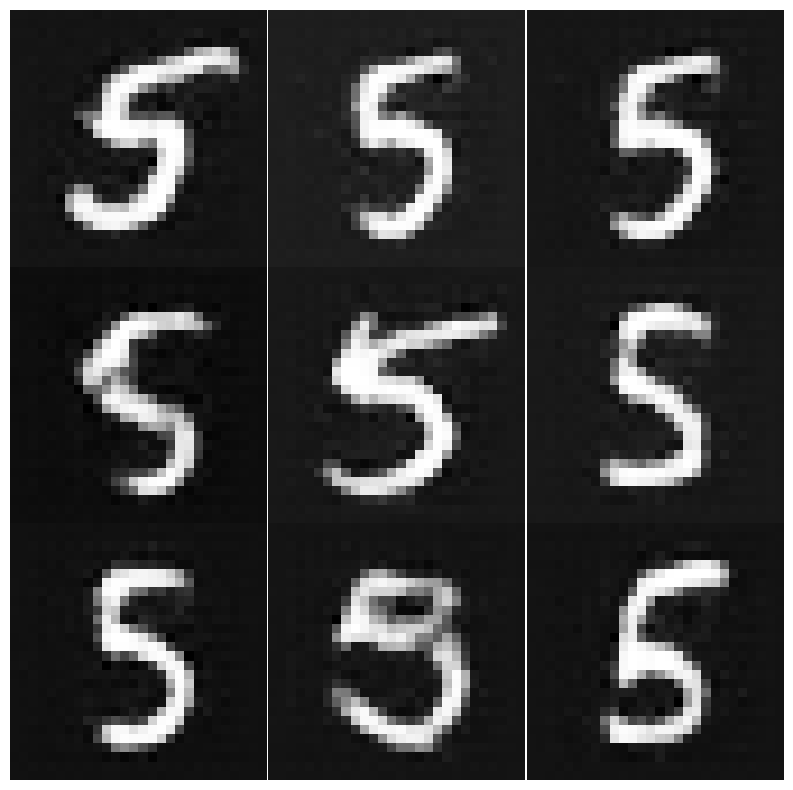

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


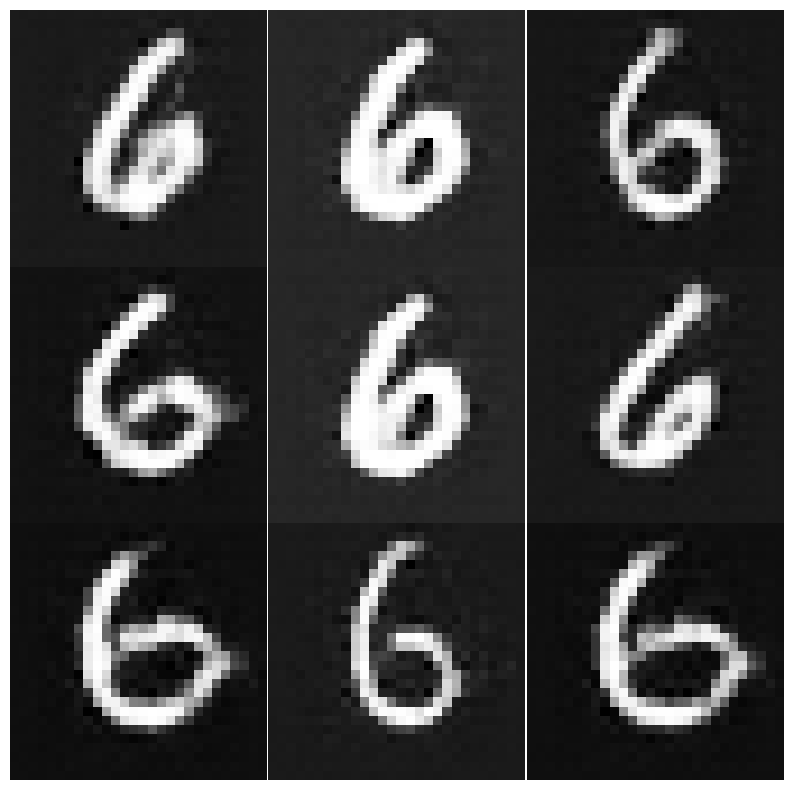

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


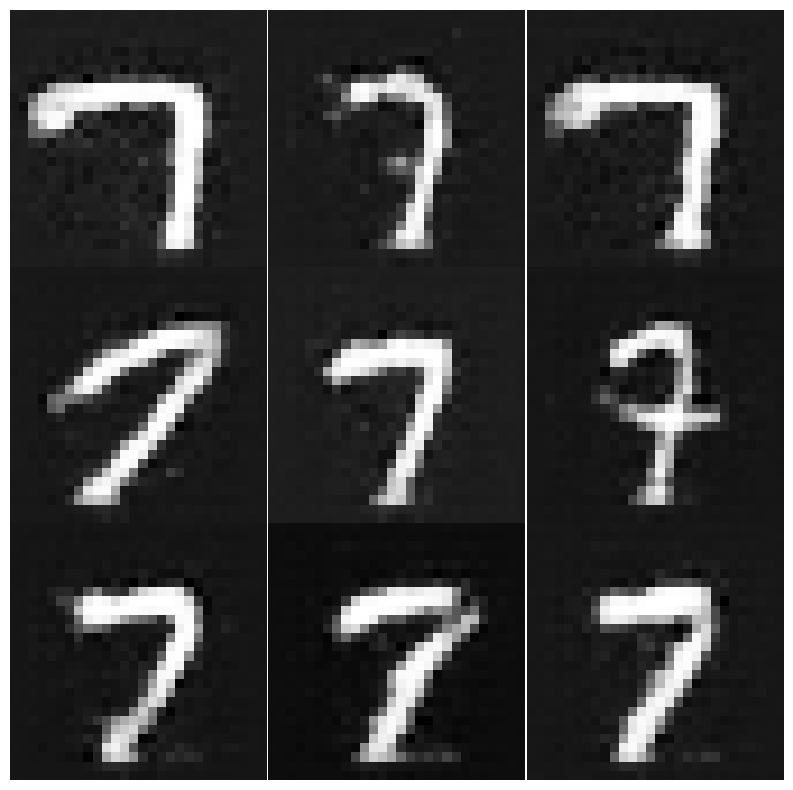

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


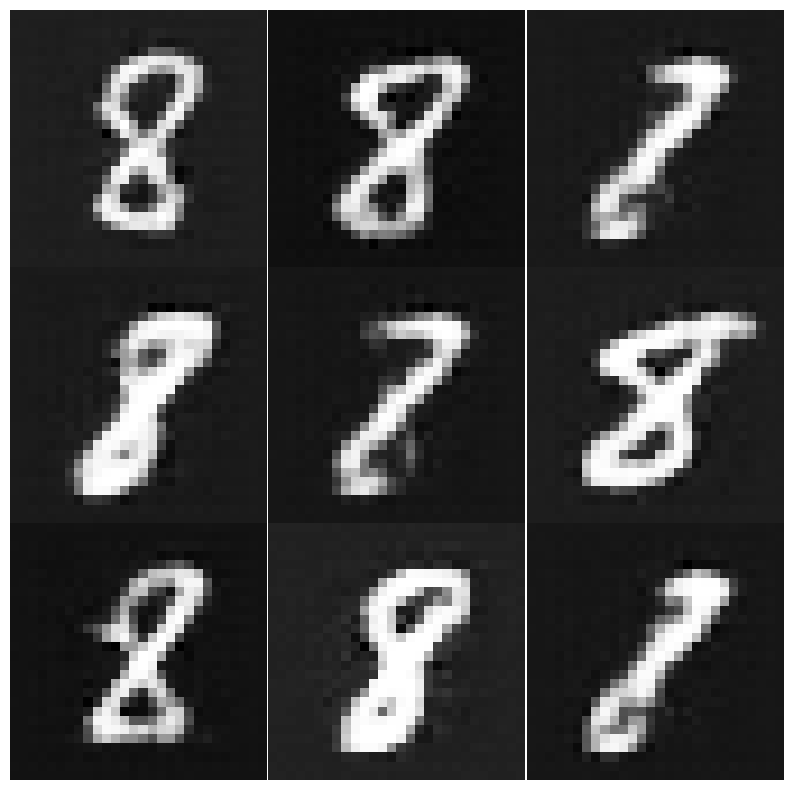

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


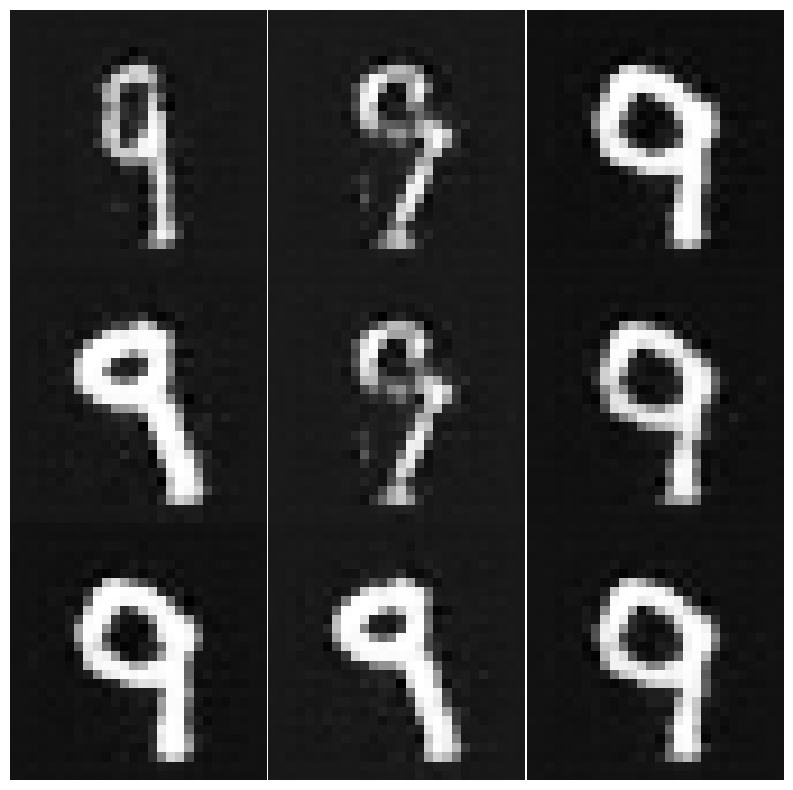

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.10
#Dataset = 1
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.275464
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.231608
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.081714
Train Epoch: 1 [4000/30000 (13%)]	Loss: 1.643524
Train Epoch: 1 [5000/30000 (17%)]	Loss: 0.914434
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.370115
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.228968
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.170295
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.266799
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.227986
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.153814
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.050728
Train

Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]


Epoch: 0 	Train Loss: 53.559025 	mse loss: 53.557464 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.05it/s]


Epoch: 1 	Train Loss: 21.937581 	mse loss: 21.936313 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.06it/s]


Epoch: 2 	Train Loss: 15.711740 	mse loss: 15.710404 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 3 	Train Loss: 11.536699 	mse loss: 11.535346 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.08it/s]


Epoch: 4 	Train Loss: 8.345033 	mse loss: 8.343674 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.90it/s]


Epoch: 5 	Train Loss: 6.831464 	mse loss: 6.830102 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.02it/s]


Epoch: 6 	Train Loss: 5.709269 	mse loss: 5.707925 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.75it/s]


Epoch: 7 	Train Loss: 4.929500 	mse loss: 4.928155 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.71it/s]


Epoch: 8 	Train Loss: 4.406445 	mse loss: 4.405095 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.68it/s]


Epoch: 9 	Train Loss: 4.047555 	mse loss: 4.046199 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.73it/s]


Epoch: 10 	Train Loss: 3.726413 	mse loss: 3.725089 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.85it/s]


Epoch: 11 	Train Loss: 3.357693 	mse loss: 3.356366 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.51it/s]


Epoch: 12 	Train Loss: 3.303715 	mse loss: 3.302417 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.83it/s]


Epoch: 13 	Train Loss: 5.022603 	mse loss: 5.021243 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.22it/s]


Epoch: 14 	Train Loss: 3.536287 	mse loss: 3.534896 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.89it/s]


Epoch: 15 	Train Loss: 3.086169 	mse loss: 3.084796 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.74it/s]


Epoch: 16 	Train Loss: 2.929698 	mse loss: 2.928356 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.55it/s]


Epoch: 17 	Train Loss: 2.965247 	mse loss: 2.963923 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.78it/s]


Epoch: 18 	Train Loss: 2.852693 	mse loss: 2.851389 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.87it/s]


Epoch: 19 	Train Loss: 2.569838 	mse loss: 2.568520 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.87it/s]


Epoch: 20 	Train Loss: 2.592607 	mse loss: 2.591322 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.94it/s]


Epoch: 21 	Train Loss: 2.700560 	mse loss: 2.699287 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.03it/s]


Epoch: 22 	Train Loss: 2.448736 	mse loss: 2.447466 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.97it/s]


Epoch: 23 	Train Loss: 2.329667 	mse loss: 2.328401 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.11it/s]


Epoch: 24 	Train Loss: 2.416533 	mse loss: 2.415284 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.87it/s]


Epoch: 25 	Train Loss: 2.304961 	mse loss: 2.303715 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.03it/s]


Epoch: 26 	Train Loss: 2.429329 	mse loss: 2.428088 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.01it/s]


Epoch: 27 	Train Loss: 2.238701 	mse loss: 2.237482 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.97it/s]


Epoch: 28 	Train Loss: 2.316904 	mse loss: 2.315675 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.73it/s]


Epoch: 29 	Train Loss: 2.107761 	mse loss: 2.106536 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.02it/s]


Epoch: 30 	Train Loss: 2.091435 	mse loss: 2.090226 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.03it/s]


Epoch: 31 	Train Loss: 2.191819 	mse loss: 2.190624 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.75it/s]


Epoch: 32 	Train Loss: 2.273182 	mse loss: 2.271990 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.85it/s]


Epoch: 33 	Train Loss: 2.178789 	mse loss: 2.177608 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.95it/s]


Epoch: 34 	Train Loss: 1.973400 	mse loss: 1.972222 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.66it/s]


Epoch: 35 	Train Loss: 1.929895 	mse loss: 1.928721 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.72it/s]


Epoch: 36 	Train Loss: 1.871606 	mse loss: 1.870442 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.69it/s]


Epoch: 37 	Train Loss: 1.979724 	mse loss: 1.978552 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.94it/s]


Epoch: 38 	Train Loss: 1.915669 	mse loss: 1.914497 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.98it/s]


Epoch: 39 	Train Loss: 1.822557 	mse loss: 1.821399 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.95it/s]


Epoch: 40 	Train Loss: 1.849839 	mse loss: 1.848692 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.03it/s]


Epoch: 41 	Train Loss: 1.962815 	mse loss: 1.961668 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.99it/s]


Epoch: 42 	Train Loss: 1.794045 	mse loss: 1.792903 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.87it/s]


Epoch: 43 	Train Loss: 1.743496 	mse loss: 1.742370 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.00it/s]


Epoch: 44 	Train Loss: 1.743183 	mse loss: 1.742062 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.05it/s]


Epoch: 45 	Train Loss: 1.732983 	mse loss: 1.731866 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.21it/s]


Epoch: 46 	Train Loss: 1.685879 	mse loss: 1.684769 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.11it/s]


Epoch: 47 	Train Loss: 1.603531 	mse loss: 1.602423 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.59it/s]


Epoch: 48 	Train Loss: 1.675190 	mse loss: 1.674085 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.71it/s]


Epoch: 49 	Train Loss: 1.712817 	mse loss: 1.711717 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.05it/s]


Epoch: 50 	Train Loss: 1.611065 	mse loss: 1.609960 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]


Epoch: 51 	Train Loss: 1.632446 	mse loss: 1.631355 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 52 	Train Loss: 1.618361 	mse loss: 1.617268 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


Epoch: 53 	Train Loss: 1.609874 	mse loss: 1.608785 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.11it/s]


Epoch: 54 	Train Loss: 1.570214 	mse loss: 1.569134 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 55 	Train Loss: 1.587731 	mse loss: 1.586650 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.87it/s]


Epoch: 56 	Train Loss: 1.556542 	mse loss: 1.555475 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.11it/s]


Epoch: 57 	Train Loss: 1.551929 	mse loss: 1.550865 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]


Epoch: 58 	Train Loss: 1.505767 	mse loss: 1.504709 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch: 59 	Train Loss: 1.539084 	mse loss: 1.538033 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.99it/s]


Epoch: 60 	Train Loss: 1.531829 	mse loss: 1.530767 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 61 	Train Loss: 1.525557 	mse loss: 1.524503 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.85it/s]


Epoch: 62 	Train Loss: 1.526001 	mse loss: 1.524944 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.62it/s]


Epoch: 63 	Train Loss: 1.491739 	mse loss: 1.490689 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]


Epoch: 64 	Train Loss: 1.467969 	mse loss: 1.466930 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch: 65 	Train Loss: 1.525706 	mse loss: 1.524654 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]


Epoch: 66 	Train Loss: 1.515761 	mse loss: 1.514694 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 67 	Train Loss: 1.422978 	mse loss: 1.421931 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 68 	Train Loss: 1.367065 	mse loss: 1.366022 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 69 	Train Loss: 1.402035 	mse loss: 1.400993 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 70 	Train Loss: 1.363779 	mse loss: 1.362750 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]


Epoch: 71 	Train Loss: 1.394528 	mse loss: 1.393504 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]


Epoch: 72 	Train Loss: 1.381100 	mse loss: 1.380076 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 73 	Train Loss: 1.461422 	mse loss: 1.460390 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.76it/s]


Epoch: 74 	Train Loss: 1.356206 	mse loss: 1.355182 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]


Epoch: 75 	Train Loss: 1.442645 	mse loss: 1.441624 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]


Epoch: 76 	Train Loss: 1.340761 	mse loss: 1.339739 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]


Epoch: 77 	Train Loss: 1.314407 	mse loss: 1.313395 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.85it/s]


Epoch: 78 	Train Loss: 1.286851 	mse loss: 1.285843 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 79 	Train Loss: 1.342674 	mse loss: 1.341668 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.29it/s]


Epoch: 80 	Train Loss: 1.290413 	mse loss: 1.289407 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 81 	Train Loss: 1.283001 	mse loss: 1.281999 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.94it/s]


Epoch: 82 	Train Loss: 1.277069 	mse loss: 1.276063 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.87it/s]


Epoch: 83 	Train Loss: 1.281745 	mse loss: 1.280738 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 84 	Train Loss: 1.269158 	mse loss: 1.268147 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]


Epoch: 85 	Train Loss: 1.228976 	mse loss: 1.227982 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 86 	Train Loss: 1.203924 	mse loss: 1.202937 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 87 	Train Loss: 1.181582 	mse loss: 1.180595 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.64it/s]


Epoch: 88 	Train Loss: 1.216515 	mse loss: 1.215529 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.89it/s]


Epoch: 89 	Train Loss: 1.233649 	mse loss: 1.232659 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.87it/s]


Epoch: 90 	Train Loss: 1.233792 	mse loss: 1.232806 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch: 91 	Train Loss: 1.230742 	mse loss: 1.229767 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]


Epoch: 92 	Train Loss: 1.158388 	mse loss: 1.157419 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.89it/s]


Epoch: 93 	Train Loss: 1.111696 	mse loss: 1.110734 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 94 	Train Loss: 1.166286 	mse loss: 1.165323 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 95 	Train Loss: 2.247612 	mse loss: 2.246637 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]


Epoch: 96 	Train Loss: 1.583143 	mse loss: 1.582141 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 97 	Train Loss: 1.375055 	mse loss: 1.374071 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch: 98 	Train Loss: 1.325480 	mse loss: 1.324503 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.94it/s]


Epoch: 99 	Train Loss: 1.197708 	mse loss: 1.196735 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.85it/s]


Epoch: 100 	Train Loss: 1.147203 	mse loss: 1.146235 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]


Epoch: 101 	Train Loss: 1.191159 	mse loss: 1.190197 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.87it/s]


Epoch: 102 	Train Loss: 1.214407 	mse loss: 1.213447 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.05it/s]


Epoch: 103 	Train Loss: 1.134682 	mse loss: 1.133734 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.30it/s]


Epoch: 104 	Train Loss: 1.140121 	mse loss: 1.139170 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.76it/s]


Epoch: 105 	Train Loss: 1.091972 	mse loss: 1.091026 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]


Epoch: 106 	Train Loss: 1.112342 	mse loss: 1.111397 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 107 	Train Loss: 1.169871 	mse loss: 1.168927 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 108 	Train Loss: 1.144434 	mse loss: 1.143492 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]


Epoch: 109 	Train Loss: 1.039259 	mse loss: 1.038318 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.06it/s]


Epoch: 110 	Train Loss: 1.079470 	mse loss: 1.078533 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.89it/s]


Epoch: 111 	Train Loss: 1.069653 	mse loss: 1.068720 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 112 	Train Loss: 1.036788 	mse loss: 1.035862 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 113 	Train Loss: 1.087096 	mse loss: 1.086171 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.11it/s]


Epoch: 114 	Train Loss: 1.096223 	mse loss: 1.095300 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.54it/s]


Epoch: 115 	Train Loss: 1.008998 	mse loss: 1.008077 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]


Epoch: 116 	Train Loss: 1.020758 	mse loss: 1.019841 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]


Epoch: 117 	Train Loss: 0.994498 	mse loss: 0.993578 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.25it/s]


Epoch: 118 	Train Loss: 1.029525 	mse loss: 1.028611 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 119 	Train Loss: 1.003651 	mse loss: 1.002732 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.76it/s]


Epoch: 120 	Train Loss: 1.006809 	mse loss: 1.005900 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch: 121 	Train Loss: 0.990693 	mse loss: 0.989782 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.11it/s]


Epoch: 122 	Train Loss: 1.021851 	mse loss: 1.020945 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]


Epoch: 123 	Train Loss: 1.000557 	mse loss: 0.999655 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch: 124 	Train Loss: 1.124741 	mse loss: 1.123826 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch: 125 	Train Loss: 1.013699 	mse loss: 1.012794 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 126 	Train Loss: 1.059188 	mse loss: 1.058282 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.87it/s]


Epoch: 127 	Train Loss: 1.001662 	mse loss: 1.000761 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.77it/s]


Epoch: 128 	Train Loss: 0.916306 	mse loss: 0.915402 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]


Epoch: 129 	Train Loss: 0.932327 	mse loss: 0.931426 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch: 130 	Train Loss: 0.919715 	mse loss: 0.918816 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch: 131 	Train Loss: 0.924329 	mse loss: 0.923438 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 132 	Train Loss: 0.975010 	mse loss: 0.974120 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]


Epoch: 133 	Train Loss: 0.935299 	mse loss: 0.934412 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.30it/s]


Epoch: 134 	Train Loss: 1.016817 	mse loss: 1.015926 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.56it/s]


Epoch: 135 	Train Loss: 0.915091 	mse loss: 0.914208 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]


Epoch: 136 	Train Loss: 0.897844 	mse loss: 0.896960 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.90it/s]


Epoch: 137 	Train Loss: 0.911336 	mse loss: 0.910448 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 138 	Train Loss: 0.896966 	mse loss: 0.896083 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]


Epoch: 139 	Train Loss: 0.807036 	mse loss: 0.806156 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 140 	Train Loss: 0.881247 	mse loss: 0.880367 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]


Epoch: 141 	Train Loss: 0.862011 	mse loss: 0.861135 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.87it/s]


Epoch: 142 	Train Loss: 0.942443 	mse loss: 0.941570 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.85it/s]


Epoch: 143 	Train Loss: 0.950522 	mse loss: 0.949653 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.93it/s]


Epoch: 144 	Train Loss: 0.900814 	mse loss: 0.899944 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 145 	Train Loss: 0.850961 	mse loss: 0.850097 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch: 146 	Train Loss: 1.023838 	mse loss: 1.022956 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.44it/s]


Epoch: 147 	Train Loss: 1.008113 	mse loss: 1.007234 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch: 148 	Train Loss: 0.929854 	mse loss: 0.928983 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.93it/s]


Epoch: 149 	Train Loss: 0.999325 	mse loss: 0.998448 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]


Epoch: 150 	Train Loss: 0.887547 	mse loss: 0.886677 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.89it/s]


Epoch: 151 	Train Loss: 0.853187 	mse loss: 0.852324 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]


Epoch: 152 	Train Loss: 0.892482 	mse loss: 0.891619 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 153 	Train Loss: 0.873952 	mse loss: 0.873091 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.18it/s]


Epoch: 154 	Train Loss: 1.470650 	mse loss: 1.469831 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch: 155 	Train Loss: 1.143049 	mse loss: 1.142209 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]


Epoch: 156 	Train Loss: 0.901660 	mse loss: 0.900824 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch: 157 	Train Loss: 1.240176 	mse loss: 1.239340 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.80it/s]


Epoch: 158 	Train Loss: 0.976374 	mse loss: 0.975541 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.55it/s]


Epoch: 159 	Train Loss: 0.855480 	mse loss: 0.854642 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.76it/s]


Epoch: 160 	Train Loss: 0.913957 	mse loss: 0.913123 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]


Epoch: 161 	Train Loss: 0.852391 	mse loss: 0.851556 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch: 162 	Train Loss: 0.846612 	mse loss: 0.845773 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.09it/s]


Epoch: 163 	Train Loss: 0.772661 	mse loss: 0.771834 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 164 	Train Loss: 0.812298 	mse loss: 0.811472 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.13it/s]


Epoch: 165 	Train Loss: 0.759288 	mse loss: 0.758465 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 166 	Train Loss: 0.744923 	mse loss: 0.744097 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch: 167 	Train Loss: 0.822581 	mse loss: 0.821757 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.85it/s]


Epoch: 168 	Train Loss: 0.750879 	mse loss: 0.750057 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]


Epoch: 169 	Train Loss: 0.817150 	mse loss: 0.816330 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.06it/s]


Epoch: 170 	Train Loss: 0.721793 	mse loss: 0.720971 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.90it/s]


Epoch: 171 	Train Loss: 0.817954 	mse loss: 0.817132 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


Epoch: 172 	Train Loss: 0.733433 	mse loss: 0.732614 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 173 	Train Loss: 0.693622 	mse loss: 0.692796 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch: 174 	Train Loss: 0.714658 	mse loss: 0.713837 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]


Epoch: 175 	Train Loss: 0.839806 	mse loss: 0.838986 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 176 	Train Loss: 0.797744 	mse loss: 0.796928 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.81it/s]


Epoch: 177 	Train Loss: 0.845901 	mse loss: 0.845078 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]


Epoch: 178 	Train Loss: 0.754628 	mse loss: 0.753801 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 179 	Train Loss: 0.719936 	mse loss: 0.719116 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]


Epoch: 180 	Train Loss: 0.725381 	mse loss: 0.724566 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 181 	Train Loss: 0.788273 	mse loss: 0.787464 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 182 	Train Loss: 0.726601 	mse loss: 0.725777 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.82it/s]


Epoch: 183 	Train Loss: 0.745614 	mse loss: 0.744796 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch: 184 	Train Loss: 0.718355 	mse loss: 0.717543 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 185 	Train Loss: 0.743053 	mse loss: 0.742248 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.11it/s]


Epoch: 186 	Train Loss: 0.729825 	mse loss: 0.729012 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.77it/s]


Epoch: 187 	Train Loss: 0.734155 	mse loss: 0.733343 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.66it/s]


Epoch: 188 	Train Loss: 0.746983 	mse loss: 0.746176 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.01it/s]


Epoch: 189 	Train Loss: 0.689334 	mse loss: 0.688528 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 190 	Train Loss: 0.653430 	mse loss: 0.652626 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]


Epoch: 191 	Train Loss: 0.650749 	mse loss: 0.649939 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]


Epoch: 192 	Train Loss: 0.659878 	mse loss: 0.659072 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]


Epoch: 193 	Train Loss: 0.630380 	mse loss: 0.629575 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.13it/s]


Epoch: 194 	Train Loss: 0.665972 	mse loss: 0.665174 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.99it/s]


Epoch: 195 	Train Loss: 0.713195 	mse loss: 0.712395 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.77it/s]


Epoch: 196 	Train Loss: 2.063989 	mse loss: 2.063171 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch: 197 	Train Loss: 1.262177 	mse loss: 1.261341 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]


Epoch: 198 	Train Loss: 1.098269 	mse loss: 1.097447 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch: 199 	Train Loss: 0.911167 	mse loss: 0.910346 	mse2 loss: 0.000000
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.80


0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


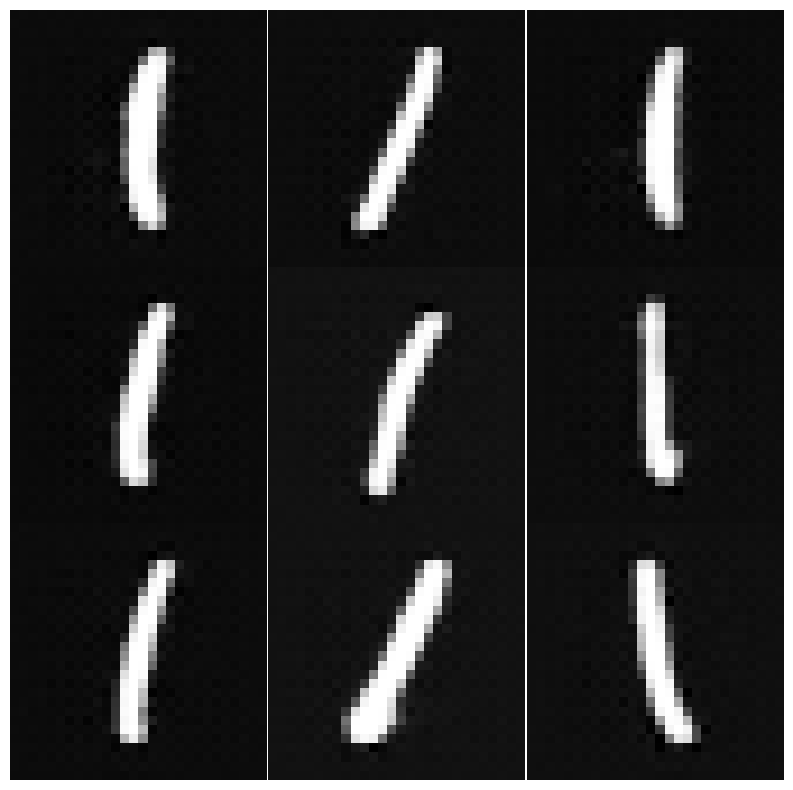

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


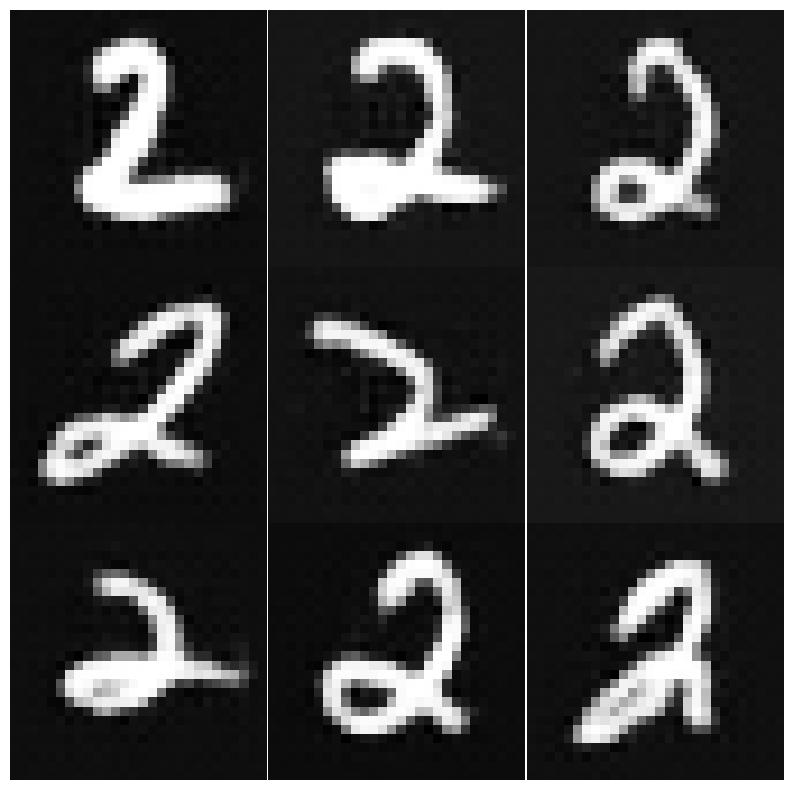

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


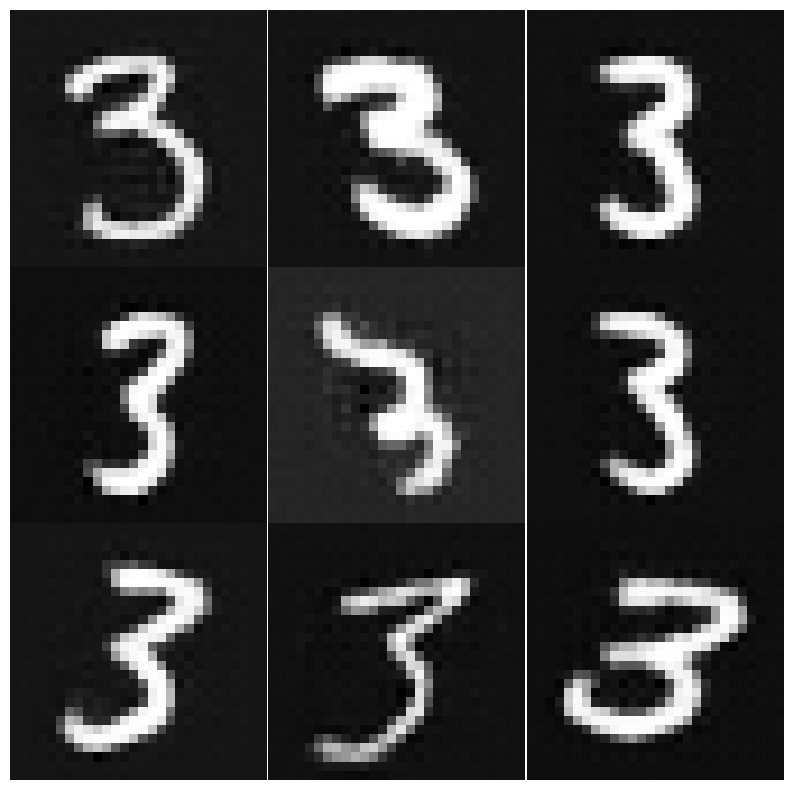

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


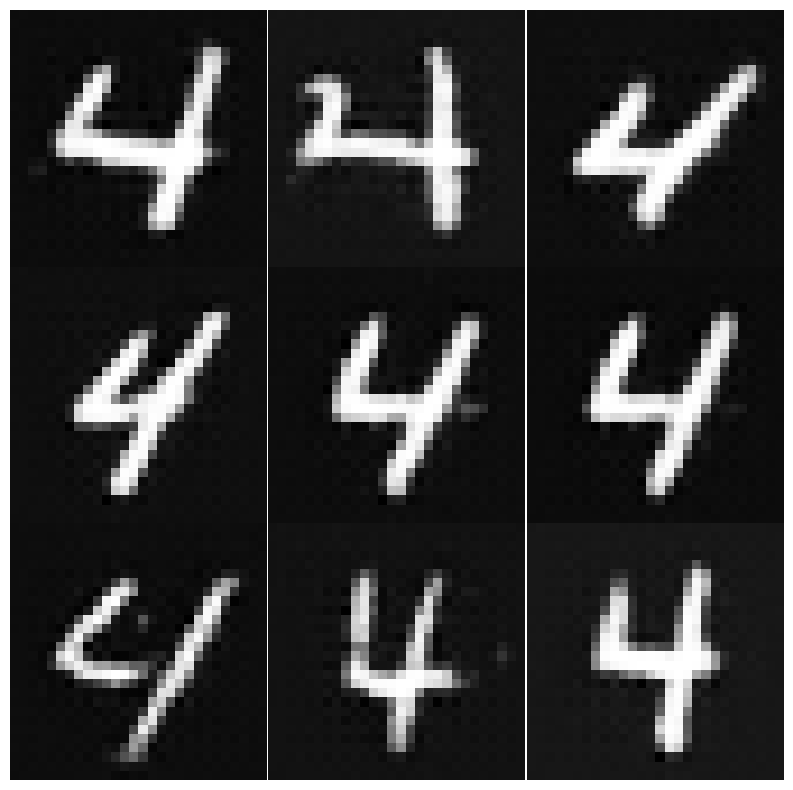

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


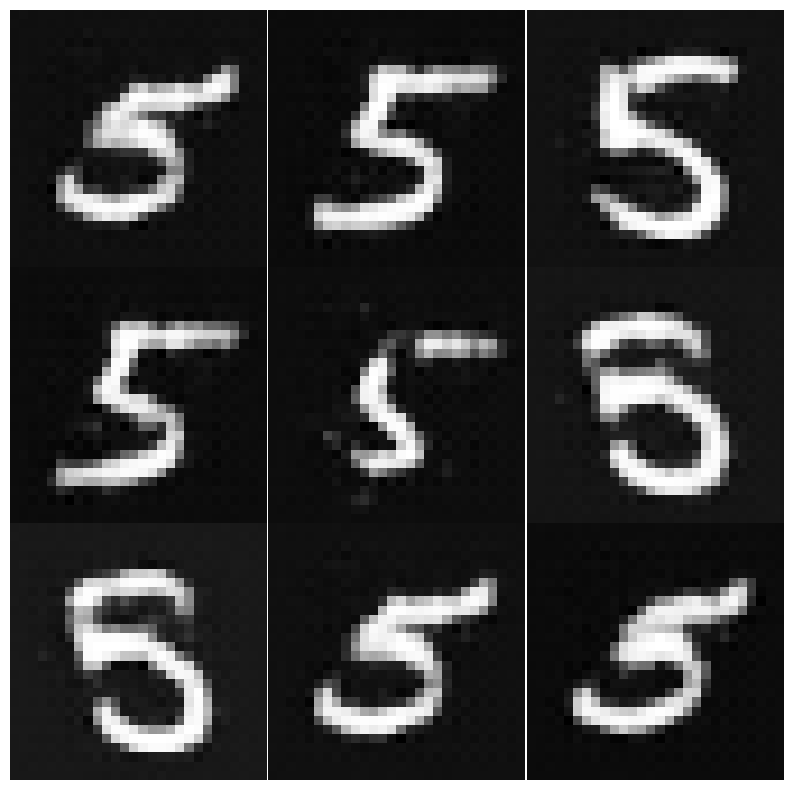

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


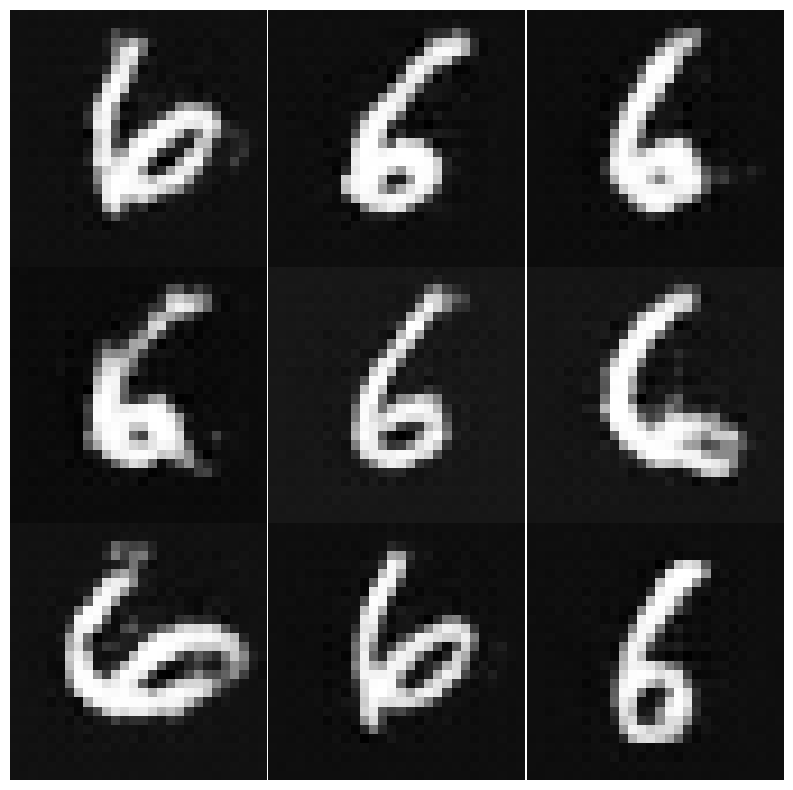

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


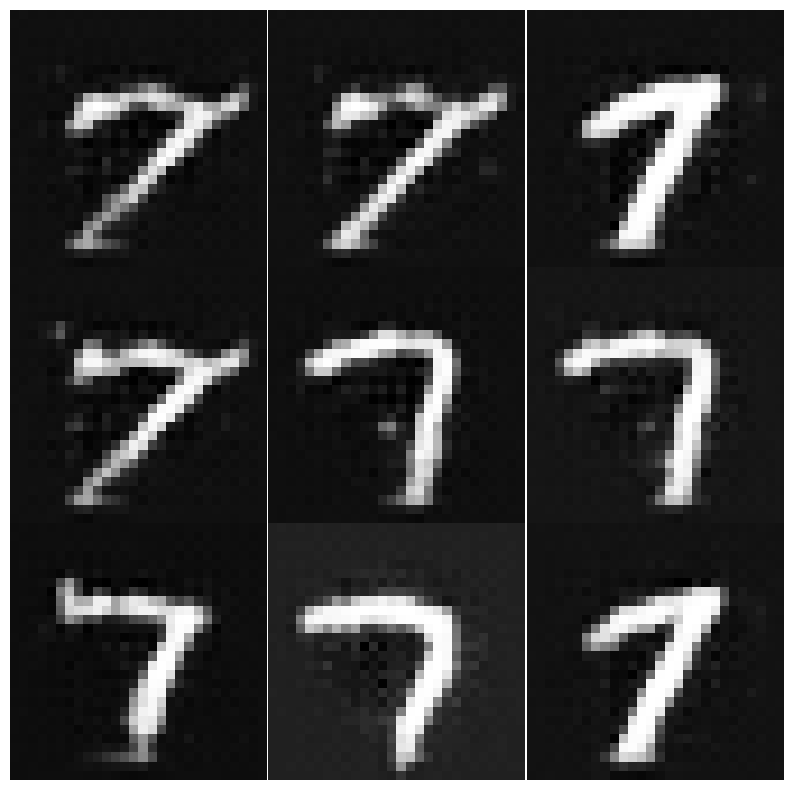

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


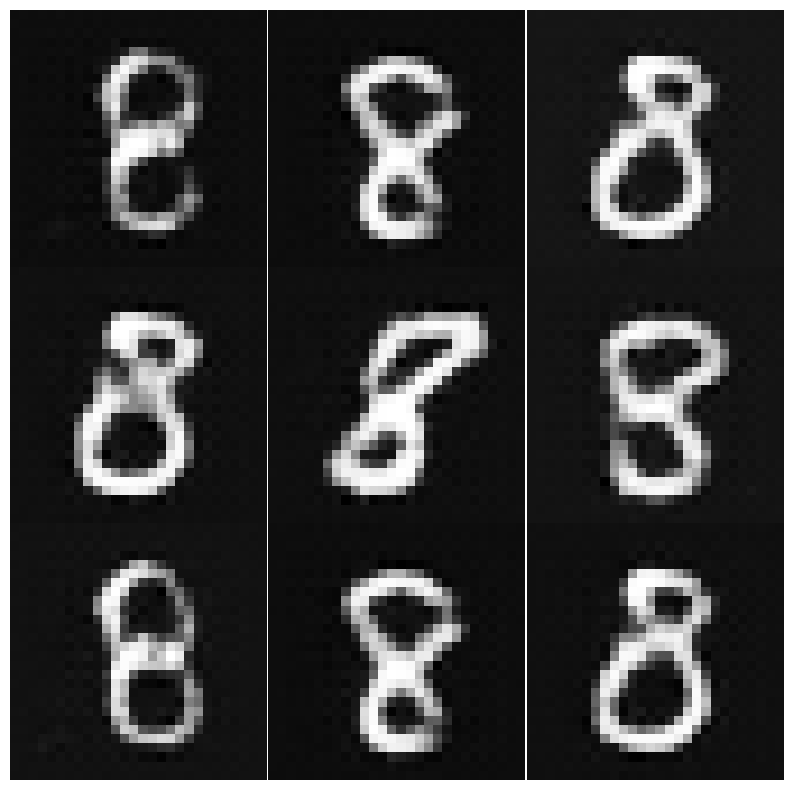

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


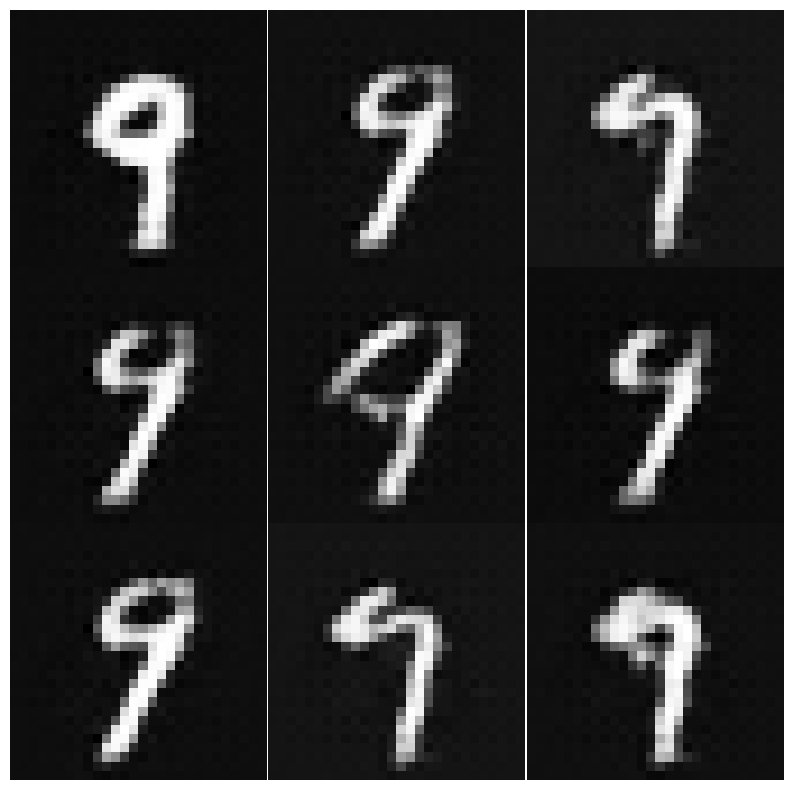

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.09
#Dataset = 1
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.279578
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.258657
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.134745
Train Epoch: 1 [4000/30000 (13%)]	Loss: 1.806903
Train Epoch: 1 [5000/30000 (17%)]	Loss: 1.143409
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.362746
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.228837
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.207537
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.206614
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.275424
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.123139
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.351357
Train

Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.32it/s]


Epoch: 0 	Train Loss: 65.688151 	mse loss: 65.686672 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.05it/s]


Epoch: 1 	Train Loss: 21.031915 	mse loss: 21.030639 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


Epoch: 2 	Train Loss: 15.583292 	mse loss: 15.581927 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.29it/s]


Epoch: 3 	Train Loss: 11.891463 	mse loss: 11.890057 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 4 	Train Loss: 9.213433 	mse loss: 9.212018 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]


Epoch: 5 	Train Loss: 7.734650 	mse loss: 7.733208 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]


Epoch: 6 	Train Loss: 6.642592 	mse loss: 6.641098 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 7 	Train Loss: 5.485900 	mse loss: 5.484372 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]


Epoch: 8 	Train Loss: 4.930225 	mse loss: 4.928710 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]


Epoch: 9 	Train Loss: 4.528595 	mse loss: 4.527123 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch: 10 	Train Loss: 3.999526 	mse loss: 3.998087 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.50it/s]


Epoch: 11 	Train Loss: 3.814530 	mse loss: 3.813084 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 12 	Train Loss: 3.505950 	mse loss: 3.504520 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]


Epoch: 13 	Train Loss: 3.210987 	mse loss: 3.209591 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.51it/s]


Epoch: 14 	Train Loss: 3.045938 	mse loss: 3.044565 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch: 15 	Train Loss: 2.934463 	mse loss: 2.933087 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.37it/s]


Epoch: 16 	Train Loss: 2.743997 	mse loss: 2.742639 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 17 	Train Loss: 3.490409 	mse loss: 3.489012 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]


Epoch: 18 	Train Loss: 2.756849 	mse loss: 2.755447 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 19 	Train Loss: 2.598267 	mse loss: 2.596888 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]


Epoch: 20 	Train Loss: 2.576197 	mse loss: 2.574834 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]


Epoch: 21 	Train Loss: 2.340535 	mse loss: 2.339198 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]


Epoch: 22 	Train Loss: 2.302508 	mse loss: 2.301185 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


Epoch: 23 	Train Loss: 2.241413 	mse loss: 2.240104 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 24 	Train Loss: 2.294454 	mse loss: 2.293157 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 25 	Train Loss: 2.194758 	mse loss: 2.193474 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 26 	Train Loss: 2.206494 	mse loss: 2.205225 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.23it/s]


Epoch: 27 	Train Loss: 2.064104 	mse loss: 2.062848 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 28 	Train Loss: 2.048142 	mse loss: 2.046900 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]


Epoch: 29 	Train Loss: 2.056851 	mse loss: 2.055612 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 30 	Train Loss: 2.026880 	mse loss: 2.025652 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 31 	Train Loss: 2.052466 	mse loss: 2.051244 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.60it/s]


Epoch: 32 	Train Loss: 1.870948 	mse loss: 1.869736 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 33 	Train Loss: 1.842667 	mse loss: 1.841464 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.35it/s]


Epoch: 34 	Train Loss: 1.912198 	mse loss: 1.910999 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


Epoch: 35 	Train Loss: 1.982206 	mse loss: 1.981012 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.48it/s]


Epoch: 36 	Train Loss: 1.860602 	mse loss: 1.859416 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.57it/s]


Epoch: 37 	Train Loss: 1.844157 	mse loss: 1.842985 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.64it/s]


Epoch: 38 	Train Loss: 1.800529 	mse loss: 1.799366 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 39 	Train Loss: 1.780158 	mse loss: 1.779000 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 40 	Train Loss: 1.777731 	mse loss: 1.776576 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch: 41 	Train Loss: 1.711480 	mse loss: 1.710329 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch: 42 	Train Loss: 1.709052 	mse loss: 1.707910 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 43 	Train Loss: 1.718044 	mse loss: 1.716898 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]


Epoch: 44 	Train Loss: 1.623354 	mse loss: 1.622215 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 45 	Train Loss: 1.585135 	mse loss: 1.584001 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]


Epoch: 46 	Train Loss: 1.590501 	mse loss: 1.589375 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.66it/s]


Epoch: 47 	Train Loss: 1.603681 	mse loss: 1.602557 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 48 	Train Loss: 1.619547 	mse loss: 1.618421 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 49 	Train Loss: 1.794731 	mse loss: 1.793608 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.56it/s]


Epoch: 50 	Train Loss: 1.665451 	mse loss: 1.664322 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]


Epoch: 51 	Train Loss: 1.539567 	mse loss: 1.538452 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.50it/s]


Epoch: 52 	Train Loss: 1.534639 	mse loss: 1.533526 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 53 	Train Loss: 1.559411 	mse loss: 1.558306 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 54 	Train Loss: 1.462136 	mse loss: 1.461041 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 55 	Train Loss: 1.491566 	mse loss: 1.490475 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.30it/s]


Epoch: 56 	Train Loss: 1.504876 	mse loss: 1.503784 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.32it/s]


Epoch: 57 	Train Loss: 1.430954 	mse loss: 1.429869 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 58 	Train Loss: 1.464281 	mse loss: 1.463199 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch: 59 	Train Loss: 1.395506 	mse loss: 1.394431 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 60 	Train Loss: 1.477168 	mse loss: 1.476097 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.56it/s]


Epoch: 61 	Train Loss: 1.406865 	mse loss: 1.405795 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


Epoch: 62 	Train Loss: 1.404616 	mse loss: 1.403553 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 63 	Train Loss: 1.339877 	mse loss: 1.338816 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.91it/s]


Epoch: 64 	Train Loss: 1.369810 	mse loss: 1.368752 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]


Epoch: 65 	Train Loss: 1.402785 	mse loss: 1.401714 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 66 	Train Loss: 1.447242 	mse loss: 1.446176 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]


Epoch: 67 	Train Loss: 1.368005 	mse loss: 1.366938 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]


Epoch: 68 	Train Loss: 1.297053 	mse loss: 1.295995 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.59it/s]


Epoch: 69 	Train Loss: 1.314191 	mse loss: 1.313138 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]


Epoch: 70 	Train Loss: 1.330758 	mse loss: 1.329711 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 71 	Train Loss: 1.511267 	mse loss: 1.510211 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]


Epoch: 72 	Train Loss: 1.289230 	mse loss: 1.288182 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.64it/s]


Epoch: 73 	Train Loss: 1.254412 	mse loss: 1.253362 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 74 	Train Loss: 1.211593 	mse loss: 1.210547 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]


Epoch: 75 	Train Loss: 1.220202 	mse loss: 1.219158 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]


Epoch: 76 	Train Loss: 1.226276 	mse loss: 1.225233 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]


Epoch: 77 	Train Loss: 1.201070 	mse loss: 1.200029 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]


Epoch: 78 	Train Loss: 1.219249 	mse loss: 1.218220 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]


Epoch: 79 	Train Loss: 1.217095 	mse loss: 1.216065 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]


Epoch: 80 	Train Loss: 1.217581 	mse loss: 1.216556 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]


Epoch: 81 	Train Loss: 1.215655 	mse loss: 1.214635 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]


Epoch: 82 	Train Loss: 1.161541 	mse loss: 1.160528 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]


Epoch: 83 	Train Loss: 1.179781 	mse loss: 1.178766 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]


Epoch: 84 	Train Loss: 1.206369 	mse loss: 1.205356 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]


Epoch: 85 	Train Loss: 1.191627 	mse loss: 1.190614 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch: 86 	Train Loss: 1.176395 	mse loss: 1.175388 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]


Epoch: 87 	Train Loss: 1.142048 	mse loss: 1.141046 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 88 	Train Loss: 1.126013 	mse loss: 1.125022 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 89 	Train Loss: 1.109822 	mse loss: 1.108834 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 90 	Train Loss: 1.131658 	mse loss: 1.130677 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.51it/s]


Epoch: 91 	Train Loss: 1.128298 	mse loss: 1.127319 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 92 	Train Loss: 1.056191 	mse loss: 1.055206 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 93 	Train Loss: 1.103670 	mse loss: 1.102687 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 94 	Train Loss: 1.107725 	mse loss: 1.106753 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.21it/s]


Epoch: 95 	Train Loss: 1.058200 	mse loss: 1.057225 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 96 	Train Loss: 1.015094 	mse loss: 1.014127 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.57it/s]


Epoch: 97 	Train Loss: 1.022993 	mse loss: 1.022024 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]


Epoch: 98 	Train Loss: 1.069002 	mse loss: 1.068031 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]


Epoch: 99 	Train Loss: 1.057506 	mse loss: 1.056532 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]


Epoch: 100 	Train Loss: 1.043836 	mse loss: 1.042867 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 101 	Train Loss: 1.065843 	mse loss: 1.064877 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 102 	Train Loss: 1.079136 	mse loss: 1.078162 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 103 	Train Loss: 1.034915 	mse loss: 1.033950 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.30it/s]


Epoch: 104 	Train Loss: 1.031052 	mse loss: 1.030093 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 105 	Train Loss: 0.948276 	mse loss: 0.947316 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]


Epoch: 106 	Train Loss: 0.998962 	mse loss: 0.998007 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]


Epoch: 107 	Train Loss: 0.960315 	mse loss: 0.959360 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.99it/s]


Epoch: 108 	Train Loss: 0.914559 	mse loss: 0.913606 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch: 109 	Train Loss: 1.080738 	mse loss: 1.079788 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]


Epoch: 110 	Train Loss: 1.012661 	mse loss: 1.011710 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.54it/s]


Epoch: 111 	Train Loss: 0.968738 	mse loss: 0.967794 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]


Epoch: 112 	Train Loss: 0.975811 	mse loss: 0.974867 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 113 	Train Loss: 0.990569 	mse loss: 0.989631 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]


Epoch: 114 	Train Loss: 1.039210 	mse loss: 1.038267 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.48it/s]


Epoch: 115 	Train Loss: 1.070535 	mse loss: 1.069578 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]


Epoch: 116 	Train Loss: 0.973788 	mse loss: 0.972843 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.47it/s]


Epoch: 117 	Train Loss: 0.870010 	mse loss: 0.869068 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]


Epoch: 118 	Train Loss: 0.991471 	mse loss: 0.990532 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.21it/s]


Epoch: 119 	Train Loss: 0.895598 	mse loss: 0.894662 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.13it/s]


Epoch: 120 	Train Loss: 0.913669 	mse loss: 0.912733 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]


Epoch: 121 	Train Loss: 0.915981 	mse loss: 0.915053 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 122 	Train Loss: 0.856409 	mse loss: 0.855480 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]


Epoch: 123 	Train Loss: 0.855655 	mse loss: 0.854734 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 124 	Train Loss: 0.894634 	mse loss: 0.893708 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


Epoch: 125 	Train Loss: 0.954729 	mse loss: 0.953812 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.54it/s]


Epoch: 126 	Train Loss: 0.922499 	mse loss: 0.921575 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]


Epoch: 127 	Train Loss: 0.828344 	mse loss: 0.827423 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]


Epoch: 128 	Train Loss: 0.908381 	mse loss: 0.907463 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.51it/s]


Epoch: 129 	Train Loss: 0.973789 	mse loss: 0.972869 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.23it/s]


Epoch: 130 	Train Loss: 0.929384 	mse loss: 0.928475 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.37it/s]


Epoch: 131 	Train Loss: 0.984591 	mse loss: 0.983676 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.24it/s]


Epoch: 132 	Train Loss: 1.586843 	mse loss: 1.585903 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.19it/s]


Epoch: 133 	Train Loss: 1.083102 	mse loss: 1.082167 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.23it/s]


Epoch: 134 	Train Loss: 0.984885 	mse loss: 0.983963 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.29it/s]


Epoch: 135 	Train Loss: 0.899595 	mse loss: 0.898680 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.23it/s]


Epoch: 136 	Train Loss: 0.993315 	mse loss: 0.992405 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.20it/s]


Epoch: 137 	Train Loss: 0.878582 	mse loss: 0.877672 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.18it/s]


Epoch: 138 	Train Loss: 0.861185 	mse loss: 0.860274 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.49it/s]


Epoch: 139 	Train Loss: 0.873339 	mse loss: 0.872433 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.29it/s]


Epoch: 140 	Train Loss: 0.866187 	mse loss: 0.865277 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.16it/s]


Epoch: 141 	Train Loss: 0.802250 	mse loss: 0.801343 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.35it/s]


Epoch: 142 	Train Loss: 0.778396 	mse loss: 0.777486 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 15.76it/s]


Epoch: 143 	Train Loss: 0.828803 	mse loss: 0.827903 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.13it/s]


Epoch: 144 	Train Loss: 0.829966 	mse loss: 0.829067 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.05it/s]


Epoch: 145 	Train Loss: 0.795446 	mse loss: 0.794549 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.13it/s]


Epoch: 146 	Train Loss: 0.784281 	mse loss: 0.783389 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.08it/s]


Epoch: 147 	Train Loss: 0.785846 	mse loss: 0.784955 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 148 	Train Loss: 0.751022 	mse loss: 0.750135 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]


Epoch: 149 	Train Loss: 0.847743 	mse loss: 0.846856 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.56it/s]


Epoch: 150 	Train Loss: 0.852090 	mse loss: 0.851198 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 151 	Train Loss: 0.738687 	mse loss: 0.737803 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.99it/s]


Epoch: 152 	Train Loss: 0.715762 	mse loss: 0.714883 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.35it/s]


Epoch: 153 	Train Loss: 0.706670 	mse loss: 0.705792 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 154 	Train Loss: 0.700751 	mse loss: 0.699870 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 155 	Train Loss: 0.791363 	mse loss: 0.790481 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 156 	Train Loss: 0.746754 	mse loss: 0.745877 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]


Epoch: 157 	Train Loss: 0.758895 	mse loss: 0.758019 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]


Epoch: 158 	Train Loss: 0.752833 	mse loss: 0.751961 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.53it/s]


Epoch: 159 	Train Loss: 0.735133 	mse loss: 0.734261 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 160 	Train Loss: 0.702714 	mse loss: 0.701842 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]


Epoch: 161 	Train Loss: 0.749100 	mse loss: 0.748233 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.37it/s]


Epoch: 162 	Train Loss: 0.708940 	mse loss: 0.708072 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]


Epoch: 163 	Train Loss: 0.727578 	mse loss: 0.726715 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.29it/s]


Epoch: 164 	Train Loss: 0.711165 	mse loss: 0.710307 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]


Epoch: 165 	Train Loss: 0.707699 	mse loss: 0.706843 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.67it/s]


Epoch: 166 	Train Loss: 0.687025 	mse loss: 0.686172 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch: 167 	Train Loss: 0.679937 	mse loss: 0.679086 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 168 	Train Loss: 0.675135 	mse loss: 0.674283 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]


Epoch: 169 	Train Loss: 0.666769 	mse loss: 0.665915 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch: 170 	Train Loss: 0.679407 	mse loss: 0.678553 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch: 171 	Train Loss: 0.705083 	mse loss: 0.704235 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.50it/s]


Epoch: 172 	Train Loss: 0.689914 	mse loss: 0.689065 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.36it/s]


Epoch: 173 	Train Loss: 0.791214 	mse loss: 0.790364 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.60it/s]


Epoch: 174 	Train Loss: 0.760634 	mse loss: 0.759785 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]


Epoch: 175 	Train Loss: 0.726529 	mse loss: 0.725678 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.35it/s]


Epoch: 176 	Train Loss: 0.663456 	mse loss: 0.662610 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.66it/s]


Epoch: 177 	Train Loss: 0.697847 	mse loss: 0.697000 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


Epoch: 178 	Train Loss: 0.750229 	mse loss: 0.749386 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.19it/s]


Epoch: 179 	Train Loss: 0.678785 	mse loss: 0.677938 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.43it/s]


Epoch: 180 	Train Loss: 0.660103 	mse loss: 0.659258 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]


Epoch: 181 	Train Loss: 0.638999 	mse loss: 0.638154 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]


Epoch: 182 	Train Loss: 0.655481 	mse loss: 0.654642 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]


Epoch: 183 	Train Loss: 0.695833 	mse loss: 0.694994 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]


Epoch: 184 	Train Loss: 0.671617 	mse loss: 0.670774 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch: 185 	Train Loss: 0.641261 	mse loss: 0.640422 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]


Epoch: 186 	Train Loss: 0.664510 	mse loss: 0.663676 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.32it/s]


Epoch: 187 	Train Loss: 0.650530 	mse loss: 0.649696 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]


Epoch: 188 	Train Loss: 0.652029 	mse loss: 0.651194 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.49it/s]


Epoch: 189 	Train Loss: 0.597581 	mse loss: 0.596752 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


Epoch: 190 	Train Loss: 0.622395 	mse loss: 0.621566 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]


Epoch: 191 	Train Loss: 0.638253 	mse loss: 0.637428 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.58it/s]


Epoch: 192 	Train Loss: 0.619872 	mse loss: 0.619045 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]


Epoch: 193 	Train Loss: 0.697725 	mse loss: 0.696900 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.30it/s]


Epoch: 194 	Train Loss: 0.667013 	mse loss: 0.666187 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]


Epoch: 195 	Train Loss: 0.652654 	mse loss: 0.651828 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


Epoch: 196 	Train Loss: 0.747742 	mse loss: 0.746914 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]


Epoch: 197 	Train Loss: 1.185656 	mse loss: 1.184807 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.21it/s]


Epoch: 198 	Train Loss: 0.793754 	mse loss: 0.792914 	mse2 loss: 0.000000


Loading...: 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]


Epoch: 199 	Train Loss: 0.682338 	mse loss: 0.681503 	mse2 loss: 0.000000
/home/s2522002/source_code/model/enc_mnist.pth
/home/s2522002/source_code/model/dec_mnist.pth

total time(min): 5.63


0
torch.Size([2000, 1, 28, 28])
class tensor(1)
torch.Size([2000, 20])
after smote (1000, 20)
after smote (1000,)
after smote&to tensor torch.Size([1000, 20])
after decoder (1000, 1, 28, 28)


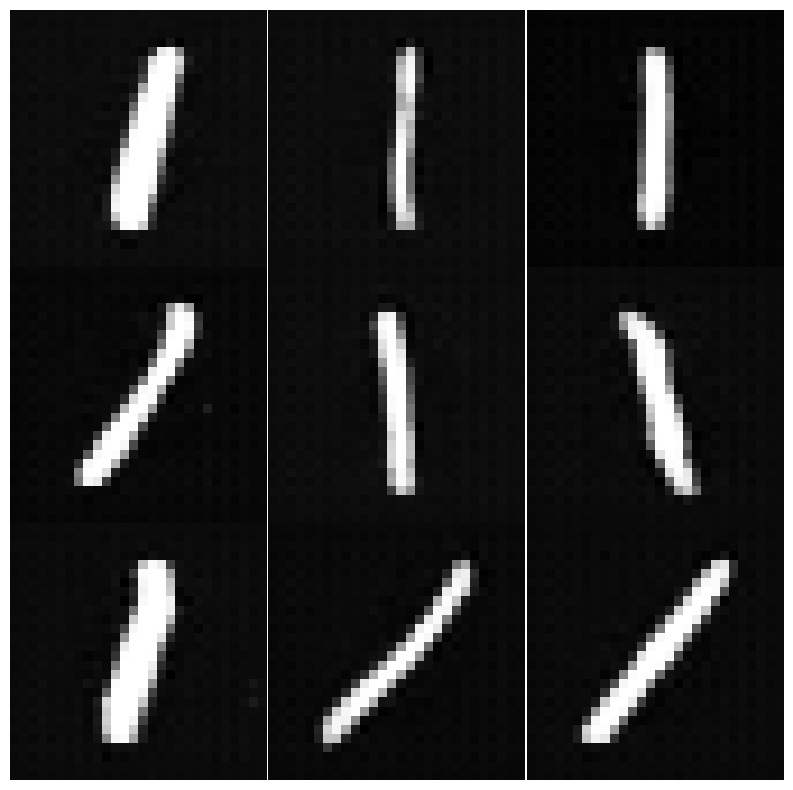

torch.Size([1000, 1, 28, 28])
class tensor(2)
torch.Size([1000, 20])
after smote (2000, 20)
after smote (2000,)
after smote&to tensor torch.Size([2000, 20])
after decoder (2000, 1, 28, 28)


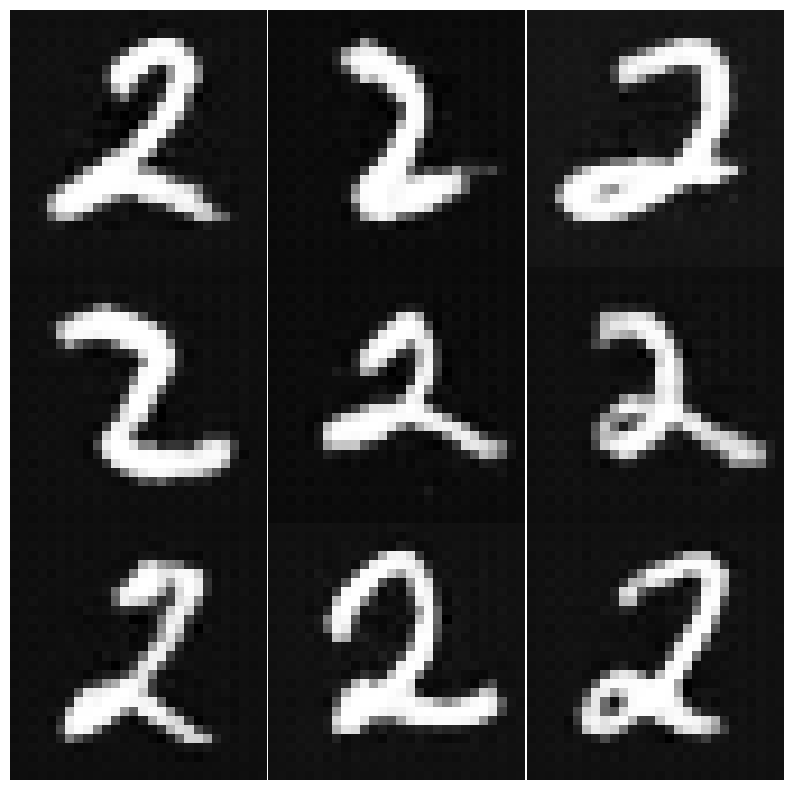

torch.Size([750, 1, 28, 28])
class tensor(3)
torch.Size([750, 20])
after smote (2250, 20)
after smote (2250,)
after smote&to tensor torch.Size([2250, 20])
after decoder (2250, 1, 28, 28)


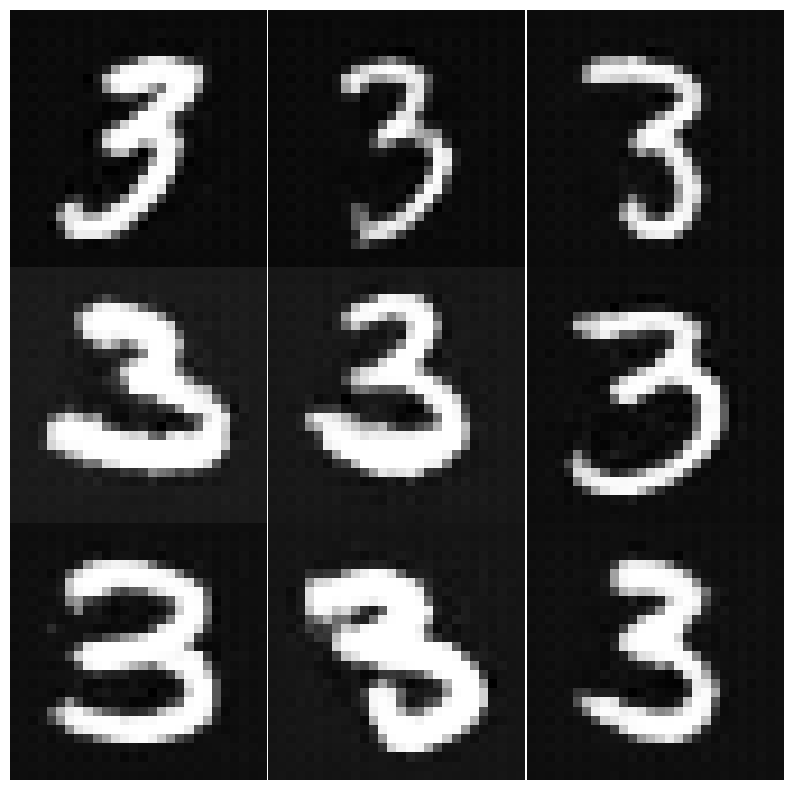

torch.Size([500, 1, 28, 28])
class tensor(4)
torch.Size([500, 20])
after smote (2500, 20)
after smote (2500,)
after smote&to tensor torch.Size([2500, 20])
after decoder (2500, 1, 28, 28)


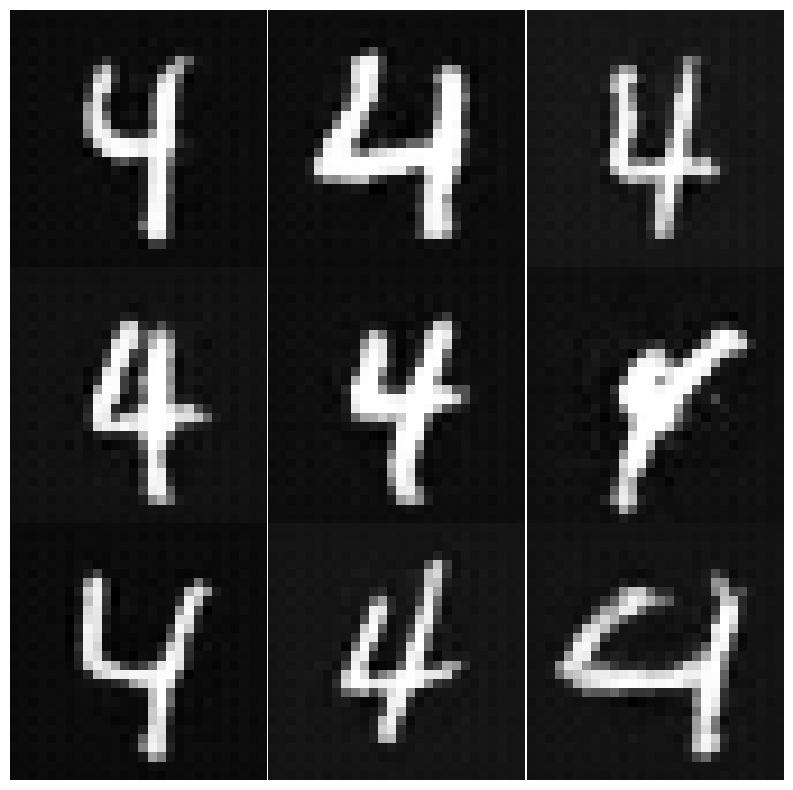

torch.Size([12, 1, 28, 28])
class tensor(5)
torch.Size([12, 20])
after smote (2988, 20)
after smote (2988,)
after smote&to tensor torch.Size([2988, 20])
after decoder (2988, 1, 28, 28)


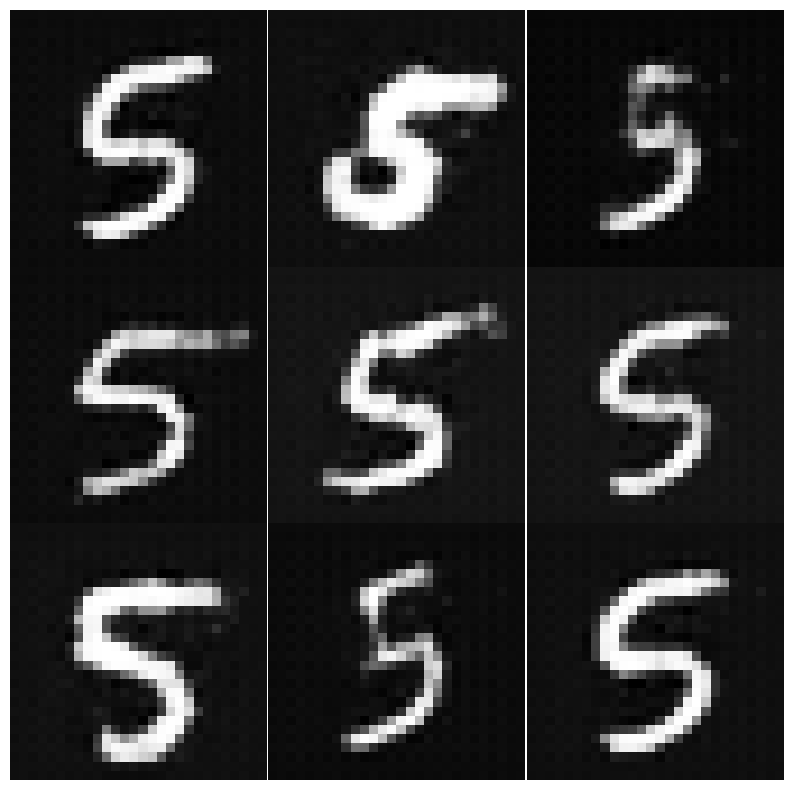

torch.Size([10, 1, 28, 28])
class tensor(6)
torch.Size([10, 20])
after smote (2990, 20)
after smote (2990,)
after smote&to tensor torch.Size([2990, 20])
after decoder (2990, 1, 28, 28)


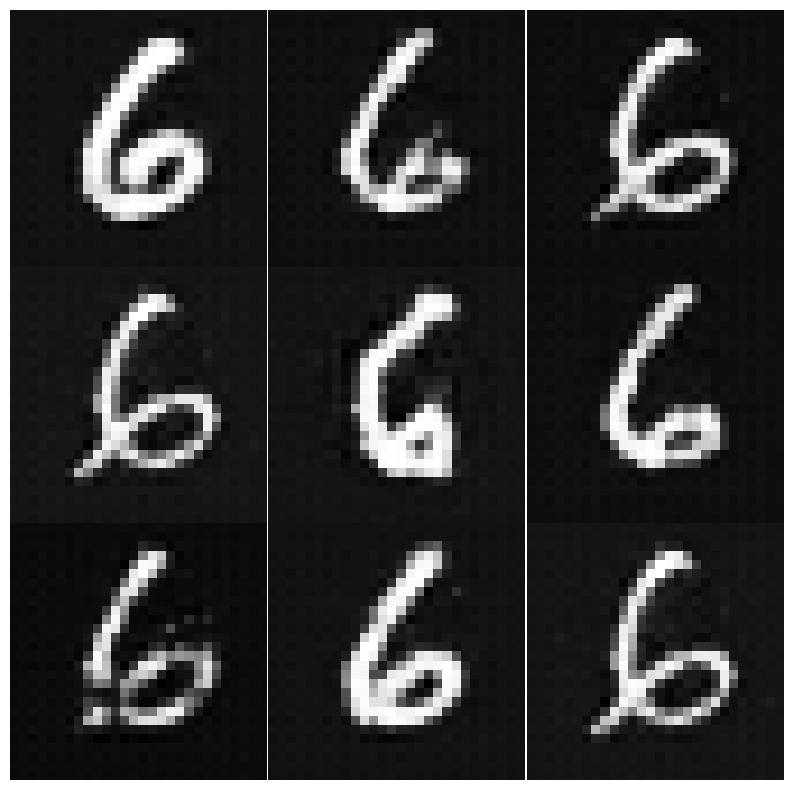

torch.Size([8, 1, 28, 28])
class tensor(7)
torch.Size([8, 20])
after smote (2992, 20)
after smote (2992,)
after smote&to tensor torch.Size([2992, 20])
after decoder (2992, 1, 28, 28)


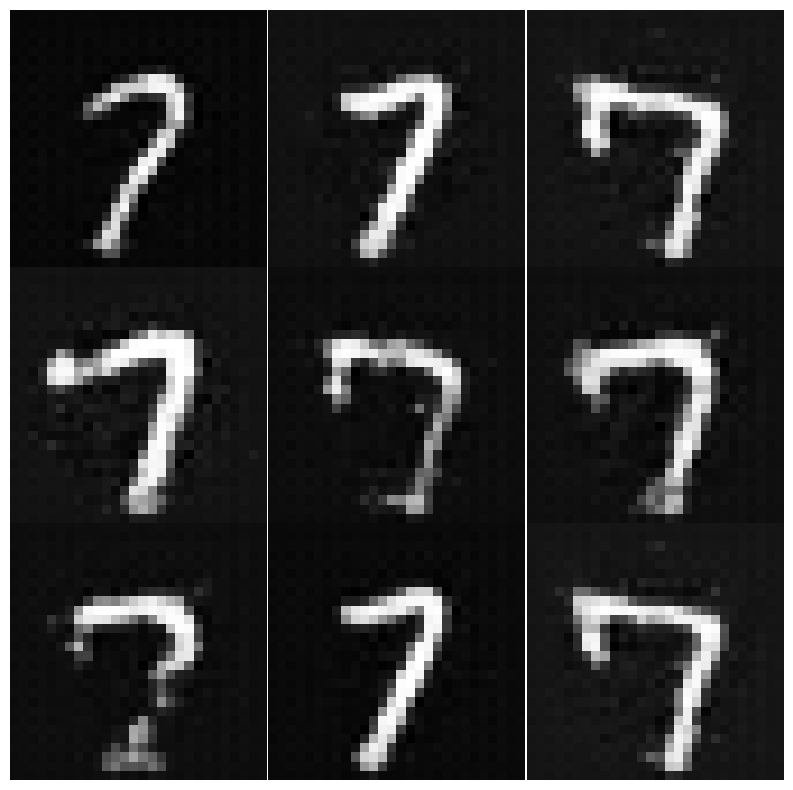

torch.Size([6, 1, 28, 28])
class tensor(8)
torch.Size([6, 20])
after smote (2994, 20)
after smote (2994,)
after smote&to tensor torch.Size([2994, 20])
after decoder (2994, 1, 28, 28)


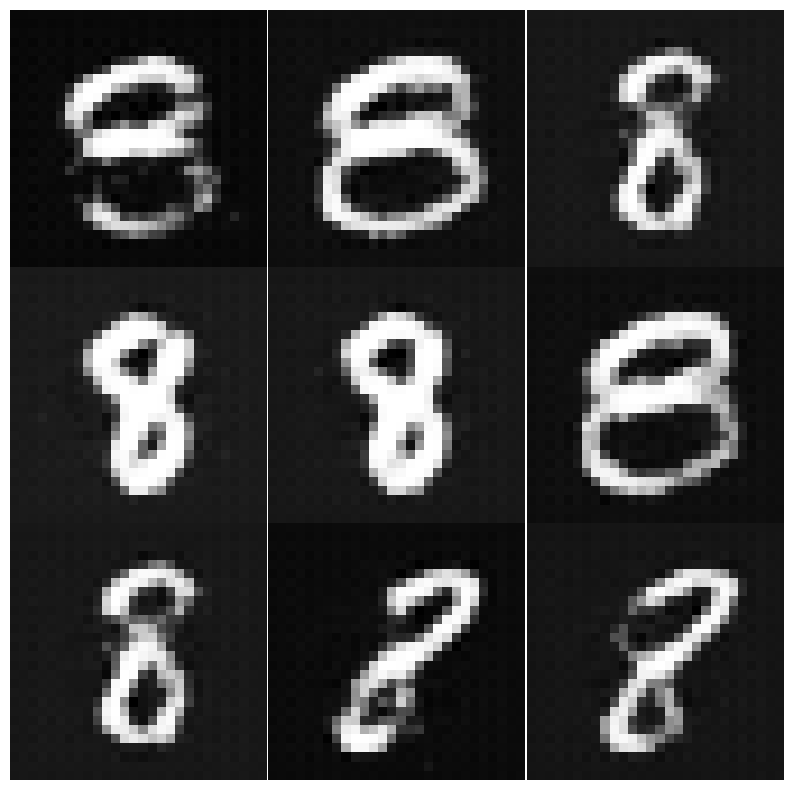

torch.Size([4, 1, 28, 28])
class tensor(9)
torch.Size([4, 20])
after smote (2996, 20)
after smote (2996,)
after smote&to tensor torch.Size([2996, 20])
after decoder (2996, 1, 28, 28)


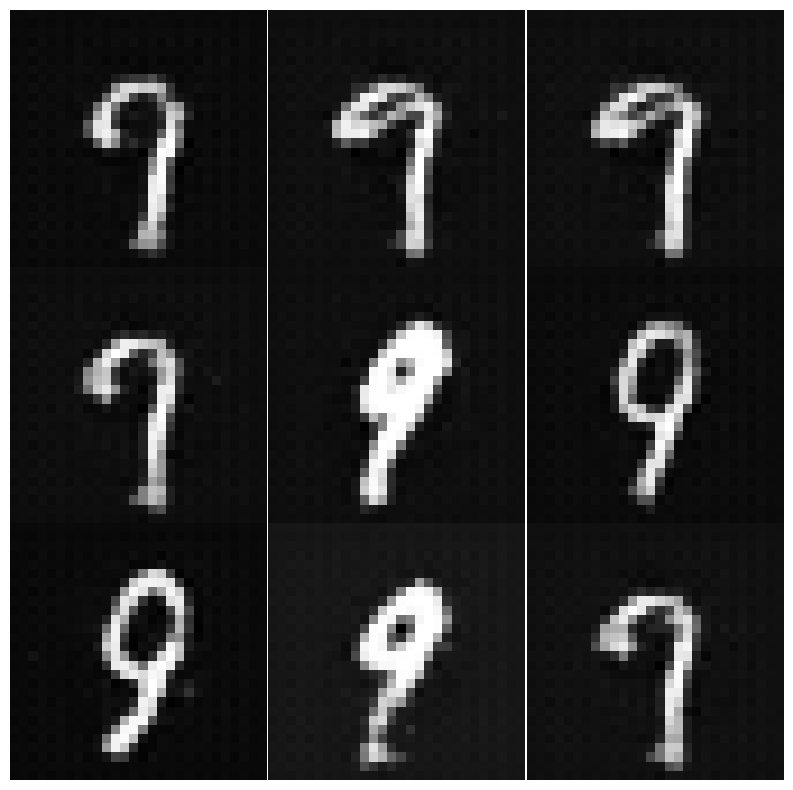

after generate (22710, 1, 28, 28)
after generate (22710,)
reshape (22710, 784)
decx1(imb imported)  torch.Size([7290, 784])
combined (30000, 784)
combined (30000,)

final time(min): 0.10
#Dataset = 1
#Dataset = 1
(30000, 1, 28, 28)
(30000,)
Counter({1.0: 3000, 2.0: 3000, 3.0: 3000, 4.0: 3000, 5.0: 3000, 6.0: 3000, 7.0: 3000, 8.0: 3000, 9.0: 3000, 0.0: 3000})
train imgs after reshape  (30000, 1, 28, 28)
Train Epoch: 1 [1000/30000 (3%)]	Loss: 2.284006
Train Epoch: 1 [2000/30000 (7%)]	Loss: 2.247648
Train Epoch: 1 [3000/30000 (10%)]	Loss: 2.151272
Train Epoch: 1 [4000/30000 (13%)]	Loss: 1.992724
Train Epoch: 1 [5000/30000 (17%)]	Loss: 1.428880
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.681696
Train Epoch: 1 [7000/30000 (23%)]	Loss: 0.398301
Train Epoch: 1 [8000/30000 (27%)]	Loss: 0.390940
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.278480
Train Epoch: 1 [10000/30000 (33%)]	Loss: 0.192345
Train Epoch: 1 [11000/30000 (37%)]	Loss: 0.109682
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.418906
Train

In [17]:
args['epochs'] = 200

trainingDataset_loss = []
avg_accuracy_list = []
avg_sensitivity_list = []
avg_specificity_list = []
avg_precision_list = []

g_mean_list = []
f_measure_list = []
acsa_list = []
cm_list = []

t3=0
for dataset,imbalanced_train in zip(folds_data,imbalanced_train_dataset_list):  #len(ids)
    print()
    print('Start...')
    
    encoder = Encoder(args)
    decoder = Decoder(args)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    train_on_gpu = torch.cuda.is_available()

    #decoder loss function
    criterion = nn.MSELoss()
    criterion = criterion.to(device)

    batch_size = 100
    num_workers = 0

    train_loader = dataset[0]

    classes = ('0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9')

    best_loss = np.inf

    list_zhat_test,list_labs_test = [],[]

    t0 = time.time()
    if args['train']:
        enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
        dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

        for epoch in range(args['epochs']):
            train_loss = 0.0
            tmse_loss = 0.0
            tdiscr_loss = 0.0
            # train for one epoch -- set nets to train mode
            encoder.train()
            decoder.train()

            for images,labs in tqdm(train_loader,desc='Loading...'):

                # zero gradients for each batch
                enc_optim.zero_grad()   
                dec_optim.zero_grad()
                
                #print(images)
                images, labs = images.to(device), labs.to(device)
                #print('images ',images.shape)
                labsn = labs.detach().cpu().numpy()
                #print('labsn ',labsn.shape, labsn)
                
                # run images
                z_hat,list_class_latent = encoder(images,labsn)

                num_clss_in_bag = np.unique(labsn) 
                loss_list = []
                for j in num_clss_in_bag:
                  # Create a boolean mask to select z_hats for the current class j
                  mask = (labsn == j)
                  # Select the z_hat representations for this class
                  z_hat_for_class_j = z_hat[mask]
                  # Calculate the MSE between the two collections of representations
                  loss_for_class_j = criterion(list_class_latent[j], z_hat_for_class_j)
                  # Add the loss to our list
                  loss_list.append(loss_for_class_j)
                  
                ## Convert the list of losses into a single tensor and sum them
                if loss_list:
                    sum_of_class_losses = torch.sum(torch.stack(loss_list))
                else:
                    sum_of_class_losses = torch.tensor(0.0, device=device)

                #sys.exit(1)

                if epoch == args['epochs']-1:
                      list_labs_test = np.append(list_labs_test, labsn )
                      list_zhat_test = np.append(list_zhat_test,z_hat.cpu().detach().numpy())

                x_hat = decoder(z_hat)

                mse = criterion(x_hat,images)
                
                # Initialize a tensor to accumulate the total sum of differences
                total_repulsion_sum = torch.tensor(0.0, device=device)
                
                # Loop through every pair of different classes in the batch
                # This is much faster than your original nested loops
                unique_class_labels = np.unique(labsn)
                num_unique_classes = len(unique_class_labels)

                # Loop through every pair of different classes
                for i in range(num_unique_classes):
                    for j in range(i + 1, num_unique_classes):
                        # Get the actual class labels from the unique list
                        class_i_label = unique_class_labels[i]
                        class_j_label = unique_class_labels[j]

                        # Get the tensors for the two classes using their labels as indices
                        tensor_class_i = list_class_latent[class_i_label]
                        tensor_class_j = list_class_latent[class_j_label]
                        # Compute the pairwise L2 distance
                        pairwise_distances = torch.cdist(tensor_class_i, tensor_class_j, p=2)

                        # Sum all the distances for this pair
                        sum_of_distances_for_pair = torch.sum(pairwise_distances)

                        # Add to the total sum
                        total_repulsion_sum += sum_of_distances_for_pair

                # Calculate the final repulsive loss as the inverse of the sum
                # Add a small epsilon for numerical stability if needed
                repulsion_loss = 1.0 / (total_repulsion_sum + 1e-8)   
                
                comb_loss = mse + sum_of_class_losses + repulsion_loss
                comb_loss.backward()

                enc_optim.step()
                dec_optim.step()

                train_loss += comb_loss.item()*images.size(0)
                tmse_loss += mse.item()*images.size(0)


            # print avg training statistics
            train_loss = train_loss/len(train_loader)
            tmse_loss = tmse_loss/len(train_loader)
            tdiscr_loss = 0 #tdiscr_loss/len(train_loader)
            print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
                    train_loss,tmse_loss,tdiscr_loss))
            trainingDataset_loss.append(train_loss)

        #save model
        path_enc = '/home/s2522002/source_code/model/enc_mnist.pth'
        path_dec = '/home/s2522002/source_code/model/dec_mnist.pth'
        print(path_enc)
        print(path_dec)
        torch.save(encoder.state_dict(), path_enc)
        torch.save(decoder.state_dict(), path_dec)
        print()

    t1 = time.time()
    print('total time(min): {:.2f}'.format((t1 - t0)/60))
    
    ################  PLOT TRAIN DISTRIBUTION ######################
    from sklearn.decomposition import PCA
    import numpy as np
    import pandas as pd
    import plotly.express as px
    
    #list_labs_test,list_zhat_test
    copy_list_zhat_test = list_zhat_test.copy()
    
    first_dim = len(list_zhat_test) // args['n_z']
    list_zhat_test_reshape =  copy_list_zhat_test.reshape(first_dim, args['n_z'])
    
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(list_zhat_test_reshape)
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=list_labs_test)
    fig.show()
    
    ############ GENERATE ###########################################################
    import collections
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset
    import numpy as np
    from sklearn.neighbors import NearestNeighbors
    import time
    import os
    import sys
    import matplotlib.pyplot as plt
    np.printoptions(precision=5,suppress=True)
    
    #path on the computer where the models are stored
    latent_img,latent_lab = [],[]
    modpth = '/home/s2522002/source_code/model'    
    
    encf = []
    decf = []
    for p in range(1):
        enc = modpth + '/' + '/enc_mnist.pth'
        dec = modpth + '/' + '/dec_mnist.pth'
        encf.append(enc)
        decf.append(dec)
    
    for m in range(1):
        print(m)
    
        classes = ('0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9')
    
        #generate some images
        train_on_gpu = torch.cuda.is_available()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        path_enc = encf[m]
        path_dec = decf[m]
    
        encoder = Encoder(args)
        # Load the encoder state dictionary and map to the available device
        encoder.load_state_dict(torch.load(path_enc, map_location=device), strict=False)
        encoder = encoder.to(device)
    
        decoder = Decoder(args)
        decoder.load_state_dict(torch.load(path_dec, map_location=device), strict=False)
        decoder = decoder.to(device)
    
        encoder.eval()
        decoder.eval()
    
        imbal = [3000, 2000, 1000, 750, 500, 12, 10, 8, 6, 4]
    
        resx = []
        resy = []
        
        data = [item[0] for item in imbalanced_train]
        target = [item[1] for item in imbalanced_train]
        data = torch.stack(data)
        target = torch.tensor(target)

        t0 = time.time()
        for i in range(1,10):
    
            xclass, yclass = biased_get_class1(i,data,target)
    
            print(xclass.shape) #(500, 3, 32, 32)
            print('class',yclass[0]) #(500,)
    
            #encode xclass to feature space
            #xclass = torch.Tensor(xclass)
            xclass = xclass.to(device)
            xclass,_ = encoder(xclass,yclass)
            print(xclass.shape) #torch.Size([500, 600])

            xclass = xclass.detach().cpu().numpy()

            latent_img = np.append(latent_img, xclass)
            latent_lab = np.append(latent_lab, yclass)
            
            n = imbal[0] - imbal[i]
    
            #SMOTE
            xsamp, ysamp = Generate_SMOTE(xclass,yclass,n,i)
            print('after smote',xsamp.shape) #(4500, 600)
            ysamp = np.array(ysamp)
            print('after smote',ysamp.shape) #4500
            xsamp = torch.Tensor(xsamp)
            xsamp = xsamp.to(device)
            
            print('after smote&to tensor',xsamp.shape) 
           
            ximg = decoder(xsamp)
    
            ximn = ximg.detach().cpu().numpy()
            print('after decoder',ximn.shape) #(4500, 3, 32, 32)
           
            resx.append(ximn)
            resy.append(ysamp)
    
            # Squeeze the first dimension to get a compatible shape for imshow
            
            plt.figure(figsize=(10,10))
            for k in range(9):
              plt.subplot(3,3,k+1)
              ximn_squeezed = ximn[k].squeeze()
              plt.imshow(ximn_squeezed, cmap='gray')
              plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.show()
    
    
        t1 = time.time()
        resx1 = np.vstack(resx)
        resy1 = np.hstack(resy)
    
        print('after generate',resx1.shape) #(34720, 3, 32, 32)
        print('after generate',resy1.shape) #(34720,)
    
        resx1 = resx1.reshape(resx1.shape[0],-1)
        print('reshape',resx1.shape) #(34720, 3072)
    
        dec_x1 = data.reshape(data.shape[0],-1)
        print('decx1(imb imported) ',dec_x1.shape)
        combx = np.vstack((resx1,dec_x1))
        comby = np.hstack((resy1,target))
    
        print('combined',combx.shape) #(45000, 3, 32, 32)
        print('combined',comby.shape) #(45000,)
    
        ifile = '/home/s2522002/source_code/sampling/balimg_mnist/trn_img.txt'
        np.savetxt(ifile, combx)

        lfile = '/home/s2522002/source_code/sampling/ballab_mnist/trn_lab.txt'
        np.savetxt(lfile,comby)
    
        print()
        #sys.exit(1)
    
    
    print('final time(min): {:.2f}'.format((t1 - t0)/60))

    #  PLOT BALANCED DISTRIBUTION ##########################################################
    
    dtrnimg = '/home/s2522002/source_code/sampling/balimg_mnist'
    dtrnlab = '/home/s2522002/source_code/sampling/ballab_mnist'
    
    ids = os.listdir(dtrnimg)
    idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
    
    ids = os.listdir(dtrnlab)
    idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
    
    print("#Dataset =",len(ids))
    
    trnimgfile = idtri_f[0]
    trnlabfile = idtrl_f[0]
    dec_x = np.loadtxt(trnimgfile)
    dec_y = np.loadtxt(trnlabfile)

    from sklearn.manifold import TSNE
    #tsne = TSNE(n_components=2, random_state=42)
    #X_tsne = tsne.fit_transform(dec_x)
    #fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=dec_y)
    #fig.show()

    #  IMPORT BL IMAGES ###########################################################
    from sklearn.model_selection import KFold
    import numpy as np
    import collections
    import torch
    from torch.utils.data import TensorDataset
    
    dtrnimg = '/home/s2522002/source_code/sampling/balimg_mnist'
    dtrnlab = '/home/s2522002/source_code/sampling/ballab_mnist'
    
    ids = os.listdir(dtrnimg)
    idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
    
    ids = os.listdir(dtrnlab)
    idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
    
    print("#Dataset =",len(ids))
    
    trnimgfile = idtri_f[0]
    trnlabfile = idtrl_f[0]
    dec_x = np.loadtxt(trnimgfile)
    dec_y = np.loadtxt(trnlabfile)
    
    #Reshape
    dec_x = dec_x.reshape(dec_x.shape[0],args['n_channel'] ,28,28)
    
    batch_size = 100
    num_workers = 0
    
    #torch.Tensor returns float so if want long then use torch.tensor
    tensor_x = torch.Tensor(dec_x)
    tensor_y = torch.tensor(dec_y,dtype=torch.long)
    mnist_bal = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(mnist_bal,
                    batch_size=batch_size,shuffle=True,num_workers=num_workers)
    
    print(np.shape(dec_x))
    print(np.shape(dec_y))
    
    print(collections.Counter(dec_y))
    
    print('train imgs after reshape ',dec_x.shape)

    #  TRAIN CNN
    # Create model, optimizer, and loss function
    #check gpu
    import torch.optim as optim
    import torch.nn as nn
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #set hyperparameter
    EPOCH = 2
    pre_epoch = 0
    BATCH_SIZE = 100
    LR = 0.01
    
    model = SimpleCNN().to(device) #ResNetMNIST().to(device)#SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #optim.Adam(model.parameters())
    
    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
    
            output = model(data)
    
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
            if (batch_idx + 1) % 10 == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch + 1,
                        (batch_idx+1) * len(data),
                        len(train_loader.dataset),
                        100.0 * (batch_idx+1) / len(train_loader),
                        loss.item(),
                    )
                )
    
    print("Training finished!")


    #  TEST CNN
    # prompt: measure ACSA, GM, and FM from imbalanced_test_loader
    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set the model to evaluation mode
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in dataset[1]:
            data = data.to(device)
            target = target.to(device)
    
            output = model(data)
            _, predicted = torch.max(output.data, 1)
    
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)
    cm_list.append(cm)
    
    # Calculate class-wise accuracy, sensitivity, specificity, and precision
    class_accuracies = []
    class_sensitivities = []
    class_specificities = []
    class_precisions = []
    
    for i in range(cm.shape[0]):
      tp = cm[i, i]
      fp = np.sum(cm[:, i]) - tp
      fn = np.sum(cm[i, :]) - tp
      tn = np.sum(cm) - tp - fp - fn
    
      class_accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
      class_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
      class_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
      class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
      class_accuracies.append(class_accuracy)
      class_sensitivities.append(class_sensitivity)
      class_specificities.append(class_specificity)
      class_precisions.append(class_precision)
    
    # Calculate the average accuracy, sensitivity, specificity, and precision
    avg_accuracy = np.mean(class_accuracies)
    avg_sensitivity = np.mean(class_sensitivities)
    avg_specificity = np.mean(class_specificities)
    avg_precision = np.mean(class_precisions)
    
    # Calculate G-mean and F-measure
    g_mean = np.sqrt(avg_sensitivity * avg_specificity)
    f_measure = 2 * (avg_precision * avg_sensitivity) / (avg_precision + avg_sensitivity) if (avg_precision + avg_sensitivity) > 0 else 0
    
    print("\nAverage Accuracy:", avg_accuracy)
    print("Average Sensitivity:", avg_sensitivity)
    print("Average Specificity:", avg_specificity)
    print("Average Precision:", avg_precision)
    
    print("\nG-mean:", g_mean)
    print("F-measure:", f_measure)
    
    # Calculate ACSA (Average Class-wise Sensitivity and Accuracy)
    acsa = (avg_sensitivity + avg_accuracy) / 2
    print("\nACSA:", acsa)
    
    avg_accuracy_list.append(avg_accuracy)
    print(avg_accuracy_list)
    avg_sensitivity_list.append(avg_sensitivity)
    avg_specificity_list.append(avg_specificity)
    avg_precision_list.append(avg_precision)
    g_mean_list.append(g_mean)
    f_measure_list.append(f_measure)
    acsa_list.append(acsa)

t4 = time.time()
print('final time(min): {:.2f}'.format((t4 - t3)/60))

### Avg via folders

In [18]:
import statistics
print("Average Accuracy:", statistics.mean(avg_accuracy_list))
print("Average Sensitivity:", statistics.mean(avg_sensitivity_list))
print("Average Specificity:", statistics.mean(avg_specificity_list))
print("Average Precision:", statistics.mean(avg_precision_list))

print("\nG-mean:", statistics.mean(g_mean_list))
print("F-measure:", statistics.mean(f_measure_list))
print("\nACSA:", statistics.mean(acsa_list))
print(cm_list)

Average Accuracy: 0.9548053864600627
Average Sensitivity: 0.7740269323003136
Average Specificity: 0.9748918813667016
Average Precision: 0.8224799241899784

G-mean: 0.8686252379606738
F-measure: 0.7974460754218139

ACSA: 0.8644161593801882
[array([[1795,    1,    6,    1,    1,    0,    2,    0,    0,    1],
       [   2, 1788,    7,    4,    4,    0,    0,    0,    1,    1],
       [  15,   11, 1756,   12,    6,    0,    0,    0,    7,    0],
       [   7,   15,   35, 1729,    2,    6,    1,    6,    3,    3],
       [  13,   10,   12,    0, 1763,    0,    1,    2,    0,    6],
       [ 180,   52,   31,  223,   17, 1212,   38,   37,   12,    5],
       [  66,  163,   85,    2,   20,   26, 1445,    0,    0,    0],
       [  93,    9,  159,   91,   79,    0,    0, 1316,    9,   51],
       [ 183,   76,  174,  496,   55,   27,    6,   26,  758,    6],
       [  92,   10,   63,  124,  911,    6,    0,  177,    9,  415]]), array([[1767,    3,   23,    8,    4,    1,    0,    0,    1,    0],

# Terminal